In [21]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.keras as keras
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.misc
import os
%matplotlib inline
import pdb

import re

import cPickle

import pyemd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from PIL import Image
import cv2

#env_title = 'AssaultNoFrameskip-v4'
env_title = 'BreakoutNoFrameskip-v4'
env = gym.make(env_title);

breakout = (env_title[:8] == 'Breakout')

[2017-06-18 00:23:51,066] Making new env: BreakoutNoFrameskip-v4


In [23]:
def downsample84(s):
    s_gray = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    return np.array(Image.fromarray(s_gray).resize((84,84)))

In [54]:
from piaget import Point, Mover, MoverTracker, FramePair, Box, Prototyper
from piaget import init_env, play

In [43]:
def processState(states):
    return np.reshape(states,[np.product(states.shape)])

In [44]:
s_list, r, d, info = initial_obs(env,breakout=True)
s_stack = np.dstack(s_list)
s = processState(s_stack)

#s210 = np.vstack([np.reshape(s,[210*160*3*2])]).astype('float32')

In [45]:
if breakout:
    game_id = 876649#510553
else:
    game_id = 508381#64468
    
pt = Prototyper(game_id)

[(-1, 1), (0, 0), (1, -1), (1, 1), (-1, -1)]
[(0, 0), (-2, 0), (-1, 0), (2, 0), (-4, 0), (1, 0), (4, 0)]


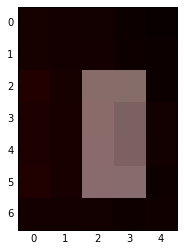

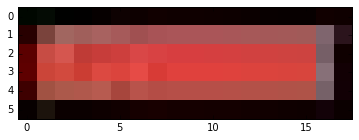

In [48]:
for p in pt.mover_prototypes:
    plt.imshow(p,interpolation='nearest')
    plt.show()

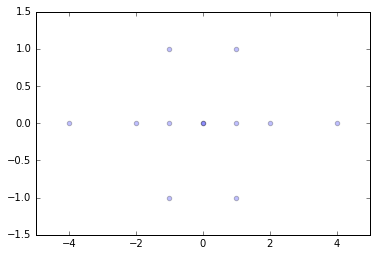

In [49]:
plt.scatter(*zip(*pt.all_disps),alpha=0.25)

### class protoQnetwork below is adapted from https://github.com/awjuliani/DeepRL-Agents

Network architecture is similar to that in the 2014 DeepMind paper.  This version uses piaget's mover images to form a first layer of convolutional filters, and their observed displacements to form the second.

### Some tests

In [57]:
from nets import protoQnetwork, protoModelnetwork

In [58]:
tf.reset_default_graph()

h_size = 32

with tf.Session() as sess:
    qn = protoModelnetwork(env, game_id, 'qn')
    #qn2 = protoQnetwork(env, h_size, mover_prototypes, 'qn2')
    init = tf.global_variables_initializer()
    sess.run(init)
    print(sess.run(tf.shape(qn.conv2_model),feed_dict={qn.scalarInput:[s]}))

[(-1, 1), (0, 0), (1, -1), (1, 1), (-1, -1)]
[(0, 0), (-2, 0), (-1, 0), (2, 0), (-4, 0), (1, 0), (4, 0)]
[  1 210 160  34]


## Training code below is adapted from https://github.com/awjuliani/DeepRL-Agents

### Experience Replay

In [59]:
def softmax10(x):
    e_x = np.exp(x)
    return e_x / (e_x + np.exp(10))

In [60]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        self.reward_prop_frames = 6
        
    def add(self,experience,reward_prop):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        if reward_prop and len(self.buffer) > self.reward_prop_frames:
            for i in range(1,self.reward_prop_frames+1):
                self.buffer[-i][2] += 2**(-i)*experience[0,2]
        self.buffer.extend(experience)
            
    def sample(self,size,attention=False,rate=1):
        if attention:
            cont_ind = np.random.rand(size)
            cont_ind_exp = (np.log(1+rate*cont_ind))*(len(self.buffer)/(np.log(1+rate)))
            disc_ind_exp = cont_ind_exp.astype('int32')
            
            np_buffer = np.array(self.buffer)
            sort_inds = np.argsort(np_buffer[:,6])
            sample_exps = np_buffer[sort_inds][disc_ind_exp]
            return sample_exps, sort_inds[disc_ind_exp]
        else:
            return np.reshape(np.array(random.sample(self.buffer,size)),[size,7])
        #TESTING continguous samples -- this is dangerous!
        #start_index = random.randint(0,len(self.buffer)-size)
        #return np.array(myBuffer.buffer[start_index:start_index+128])
    
    def set_losses(self,indices,losses):
        for ind, loss in zip(indices, losses):
            self.buffer[ind][6] = loss

In [61]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 1 #How often to perform a training step.
y = .75#.99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 1000000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
max_epLength = 5000 #The max allowed length of our episode.
pre_train_steps = 5000 #How many steps of random actions before training begins.
load_model = False #Whether to load a saved model.
path = "./dqn/piaget" #The path to save our model to.
h_size = 24 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
#tau = 0.001 #Rate to update target network toward primary network
reset_freq = 1000
reward_prop = False

act_repeat_len = 0
act_init_len = 0

learning_rate = 0.001
adam_eps = 1e-3

attn_start = 1e9
attn_rate = 100

burnin_frames = batch_size*5000
outlier_sample_min_size = batch_size*2500
new_mover_thresh = 5 # number of std deviations above the median

In [62]:
from nets import protoQnetwork, protoModelnetwork

In [63]:
tf.reset_default_graph()

#trainables = tf.trainable_variables()

#targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer(buffer_size=5000)

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#statistics on Q
Qpred_list = []
Qtarget_list = []
QrList = []

frame_err_list = np.zeros((0, pt.mt.n_base_movers))
reference_err_list = []
reward_err_list = []

mean_reward_pool = None

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

sess = tf.Session()

mainQN = protoModelnetwork(env, game_id,  'mainQN',
            dueling=True,
            lr=learning_rate, eps=adam_eps,
                           mean_reward_pool=None)

init = tf.global_variables_initializer()
sess.run(init)

saver = tf.train.Saver()

if load_model == True:
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.model_checkpoint_path)

#updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
for i in range(num_episodes):
    episodeBuffer = experience_buffer()
    #Reset environment and get first new observation(s)
    s_list, r, d, info = initial_obs(env, breakout)
    s_stack = np.dstack(s_list)
    s = processState(s_stack)
    if breakout:
        a = 1
    else:
        # fix this
        a = 0

    d = False
    rAll = 0
    j = 0

    # periodically evaluate
    if False:#i % 5 == 0 and total_steps  > pre_train_steps:
        eval_episode = True
        saved_e = e
        e = 0.1
    else:
        eval_episode = False
    
    act_repeat_countdown = 0
    breakout_requesting = False
    while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
        j+=1
        
        save_to_buffer = True
        old_a = a
        
        if breakout and breakout_requesting:
            # prevent from saving the frame pair where the ball appears
            save_to_buffer = False
            breakout_requesting = False
        if breakout and np.array_equal(s_list[0],s_list[1]):
            # breakout: requesting next ball
            a = 1
            save_to_buffer = False
            breakout_requesting = True
        elif act_repeat_countdown == 0:
            a = np.random.randint(0,env.action_space.n)
            for _ in range(act_init_len):
                s_next,r,d,info = env.step(a)
                s_list.pop(0)
                s_list.append(s_next)
                s_stack = np.dstack(s_list)
                s = processState(s_stack)
                old_a = a
            act_repeat_countdown = act_repeat_len
        else:
            act_repeat_countdown -= 1
            
        s_next,r,d,info = env.step(a)

        s_list.pop(0)
        s_list.append(s_next)

        s_stack = np.dstack(s_list)
        s1 = processState(s_stack)

        total_steps += 1
        
#         target = sess.run(mainQN.conv_movers_frame1,feed_dict={mainQN.scalarInput:[s1]})
#         loss = sess.run(mainQN.loss, \
#             feed_dict={mainQN.scalarInput:[s],
#                        mainQN.target:target, 
#                        mainQN.actions:[a],
#                        mainQN.old_actions:[old_a]})
#         frame_err_list.append(loss*batch_size)
        
        if (r > 0) or d:
            buffer_repeat = 1
        else:
            buffer_repeat = 1
        if save_to_buffer:
            for dummy in range(buffer_repeat):
                episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d,old_a,0]),
                                             [1,7]),reward_prop) #7th entry is loss if we are tracking it for every frame
                
        if total_steps > pre_train_steps and not eval_episode:
            if mean_reward_pool is None:
                
#                 bootstrapQN = protoModelnetwork(env, h_size, mover_prototypes, \
#                        mover_disps, md_equiv_classes, 5, 'bootstrapQN', dueling=True,
#                           lr=0.001, eps=1e-3, mean_reward_pool=None)
#                 init = tf.global_variables_initializer()
#                 sess.run(init)

                #reward_frames = [f[3] for f in myBuffer.buffer if f[2]>0.5]
                #reward_pools = sess.run(bootstrapQN.conv_dm,feed_dict={bootstrapQN.scalarInput:reward_frames})

                #mean_reward_pool = np.mean(reward_pools,axis=0)
                mean_reward_pool = True # hack, get rid of this once we care
                
            if e > endE:
                e -= stepDrop

            if total_steps % (update_freq) == 0:
                if True:#total_steps < attn_start:
                    trainBatch = myBuffer.sample(batch_size, attention=False)
                else:
                    trainBatch, _ = myBuffer.sample(batch_size, attention=True,
                                                           rate=attn_rate)
                target_pool = sess.run(mainQN.cm_pool,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                pred_pool = sess.run(mainQN.pred_pool,\
                                     feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]), 
                                                mainQN.actions:trainBatch[:,1],
                                               mainQN.old_actions:trainBatch[:,5]})
                previous_pool = sess.run(mainQN.cm_pool,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0])})
                mover_log_losses = sess.run(mainQN.mover_log_losses, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),
                                   mainQN.target:target_pool, 
                                   mainQN.actions:trainBatch[:,1],
                                   mainQN.old_actions:trainBatch[:,5]})
                frame_err_list = np.concatenate([frame_err_list, mover_log_losses])

                if len(frame_err_list) > burnin_frames + outlier_sample_min_size:
                    worst_frame_ind = np.unravel_index(np.argmax(mover_log_losses),
                                                       mover_log_losses.shape)
                    worst_mover = worst_frame_ind[1]
                    worst_frame = trainBatch[worst_frame_ind[0],:]
                    current_thresh = np.median(frame_err_list[burnin_frames:,worst_mover]) +\
                    new_mover_thresh*np.std(frame_err_list[burnin_frames:,worst_mover])
                    if mover_log_losses[worst_frame_ind] > current_thresh:
                        print 'threshold exceeded'
                        plt.figure(figsize=(12,4))
                        wf_s0 = np.reshape(worst_frame[0],(210,160,6))
                        wf_s1 = np.reshape(worst_frame[3],(210,160,6))
                        plt.subplot(131)
                        plt.imshow(wf_s0[:,:,3:] - wf_s0[:,:,:3])
                        plt.subplot(132)
                        plt.imshow(wf_s0[:,:,:3])
                        plt.subplot(133)
                        plt.imshow(wf_s0[:,:,3:])
                        plt.show()
                        print ('loss',mover_log_losses[worst_frame_ind],'threshold', current_thresh)
                        # take snapshots of outliers
                        n_movers_before = mt.n_movers
                        if n_movers_before != mainQN.n_movers:
                            print 'warning: mt has %d movers while QN has %d' % (n_movers_before, mainQN.n_movers)
                        wf_fp0 = FramePair(wf_s0[:,:,:3],wf_s0[:,:,3:],0,0)
                        wf_fp1 = FramePair(wf_s1[:,:,:3],wf_s1[:,:,3:],0,0)
                        mt.process_frame_pair(wf_fp0, base_movers=False)
                        mt.process_frame_pair(wf_fp1, base_movers=False)

                        n_movers_after = mt.n_movers
                        print 'found %d new movers' % (n_movers_after - n_movers_before)
                        with open(mt_filename,'w') as mt_file:
                            cPickle.dump(mt, mt_file)
                        pdb.set_trace()

                #frame_err_list.append(sum(((target_pool-pred_pool)**2).flatten()))
                #reference_err_list.append(sum(((target_pool-previous_pool)**2).flatten()))
                #update_ops = [mainQN.reward_loss, mainQN.updateModel, mainQN.reward_updateModel]
                
                update_ops = [mainQN.updateModel]
                (_) = \
                sess.run(update_ops, \
                    feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),
                               mainQN.target:target_pool, 
                               mainQN.actions:trainBatch[:,1],
                               mainQN.old_actions:trainBatch[:,5]})
                #reward_err_list.append(reward_loss)

        rAll += r
        s = s1

        if d == True:
            break
    if not eval_episode:
        myBuffer.add(episodeBuffer.buffer,False)
        jList.append(j)
        rList.append(rAll)
    else:
        print("Evaluated model")
        print(j, rAll)
        e = saved_e
    #Periodically save the model. 
    if i % 100 == 0 and i > 0:
        saver.save(sess,path+'/model-'+str(i)+'.cptk')
        print("Saved Model")
    print_rate = 1
    if len(rList) % print_rate == 0 and total_steps > pre_train_steps:
        print(total_steps, (32)*np.mean(frame_err_list[-batch_size*100:,:]))
        for _ in range(2):
            displayBatch = myBuffer.sample(1, attention=False)
            target_pool = sess.run(mainQN.cm_pool,feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,3])})
            pred_pool = sess.run(mainQN.pred_pool,\
                                 feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]), 
                                            mainQN.actions:displayBatch[:,1],
                                            mainQN.old_actions:displayBatch[:,5]})
            previous_pool = sess.run(mainQN.cm_pool,feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0])})

            pred_V = sess.run(mainQN.streamV,\
                     feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]),
                                mainQN.actions:displayBatch[:,1],
                                mainQN.old_actions:displayBatch[:,5]})
            pred_A = sess.run(tf.einsum('abcde,ae->abcd',mainQN.streamA,mainQN.actions_onehot),\
                                 feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]),
                                            mainQN.actions:displayBatch[:,1],
                                            mainQN.old_actions:displayBatch[:,5]})

            #print(total_steps, np.mean(reference_err_list[-100:]), np.mean(frame_err_list[-100:]))
            print('action: ', displayBatch[0][1],
                 'old_action: ', displayBatch[0][5])

            plt.figure(figsize=(12,4))
            s0 = np.reshape(displayBatch[0,0],(210,160,6))
            plt.subplot(131)
            plt.imshow(s0[:,:,3:] - s0[:,:,:3])
            plt.subplot(132)
            plt.imshow(s0[:,:,:3])
            plt.subplot(133)
            plt.imshow(s0[:,:,3:])
            i_max = target_pool.shape[3]
            plt.figure(figsize=(12,2*i_max))
            j_max = 5
            for ii in range(i_max):
                for jj in range(j_max//5):
                    #plt.subplot(i_max,2*j_max,jj+(ii*j_max)+1)
                    #plt.xticks([])
                    #plt.yticks([])
                    target_img = (target_pool[0,:,:,ii]>0.1)
                    pred_img = pred_pool[0,:,:,ii]
                    previous_img = (previous_pool[0,:,:,ii]>0.1)

                    predV_img = pred_V[0,:,:,ii]
                    predA_img = pred_A[0,:,:,ii]

                    vis_center = np.unravel_index(np.argmax(target_img), target_img.shape)
                    vis_center = (max(vis_center[0],5), max(vis_center[1],5))
                    target_img = target_img[vis_center[0]-5:vis_center[0]+5,
                                           vis_center[1]-5:vis_center[1]+5]
                    pred_img = pred_img[vis_center[0]-5:vis_center[0]+5,
                                           vis_center[1]-5:vis_center[1]+5]
                    previous_img = previous_img[vis_center[0]-5:vis_center[0]+5,
                                           vis_center[1]-5:vis_center[1]+5]
                    predV_img = predV_img[vis_center[0]-5:vis_center[0]+5,
                       vis_center[1]-5:vis_center[1]+5]
                    predA_img = predA_img[vis_center[0]-5:vis_center[0]+5,
                                           vis_center[1]-5:vis_center[1]+5]

                    #cmap_max = max(np.max(previous_img), np.max(target_img))
                    #cmap_min = min(np.min(previous_img), np.min(target_img))
                    cmap_max = 0.2; cmap_min = 0
                    cmap_max_VA = max(np.max(predV_img), np.max(predA_img)) 
                    cmap_min_VA = min(np.min(predV_img), np.min(predA_img))

                    plt.subplot(i_max,j_max,3*jj+(ii*j_max)+1)
                    plt.imshow(previous_img,cmap='gray',interpolation='nearest',
                              vmin=cmap_min, vmax=cmap_max)
                    plt.subplot(i_max,j_max,3*jj+(ii*j_max)+2)
                    plt.imshow(target_img,cmap='gray',interpolation='nearest',
                              vmin=cmap_min, vmax=cmap_max)
                    plt.subplot(i_max,j_max,3*jj+(ii*j_max)+3)
                    plt.imshow(softmax10(pred_img),cmap='gray',interpolation='nearest',
                              vmin=0, vmax=1)
                    plt.subplot(i_max,j_max,3*jj+(ii*j_max)+4)
                    plt.imshow(predV_img,cmap='gray',interpolation='nearest',
                              vmin=cmap_min_VA, vmax=cmap_max_VA)
                    plt.subplot(i_max,j_max,3*jj+(ii*j_max)+5)
                    plt.imshow(predA_img,cmap='gray',interpolation='nearest',
                              vmin=cmap_min_VA, vmax=cmap_max_VA)
                    print(np.max(previous_img),np.max(target_img),np.max(pred_img))
            plt.show()
        
        avg_window = batch_size*100
        if frame_err_list.shape[0] > 3*avg_window:
            plt.figure()

            for m_id in range(frame_err_list.shape[1]):
                sqMat = np.resize((32)*frame_err_list[:,m_id],
                                  [frame_err_list.shape[0]//avg_window,
                                                   avg_window])
                QsqAvgs = np.average(sqMat,1)
                plt.plot(QsqAvgs[1:])
            plt.show()
            
saver.save(sess,path+'/model-'+str(i)+'.cptk')

print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

[(-1, 1), (0, 0), (1, -1), (1, 1), (-1, -1)]
[(0, 0), (-2, 0), (-1, 0), (2, 0), (-4, 0), (1, 0), (4, 0)]


KeyboardInterrupt: 

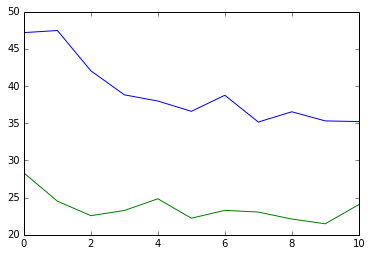

In [172]:
plt.figure()

for m_id in range(frame_err_list.shape[1]):
    sqMat = np.resize((32)*frame_err_list[:,m_id],
                      [frame_err_list.shape[0]//avg_window,
                                       avg_window])
    QsqAvgs = np.average(sqMat,1)
    plt.plot(QsqAvgs[1:])
plt.show()

In [170]:
total_steps

6222

In [171]:
print burnin_frames + outlier_sample_min_size
print len(frame_err_list)

24000
39072


In [108]:
avg_window = batch_size*100
sqMat = np.resize((32//batch_size)*np.array(frame_err_list),[len(frame_err_list)//avg_window,avg_window])
QsqAvgs = np.mean(sqMat,1)
q25 = np.percentile(sqMat,25,1)
q50 = np.percentile(sqMat,50,1)
q75 = np.percentile(sqMat,75,1)

qmax = np.max(sqMat,1)
qstd = np.std(sqMat,1)

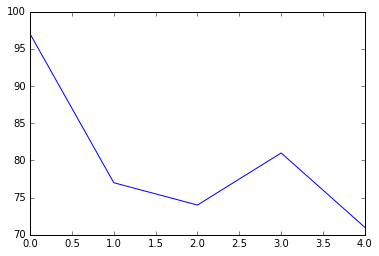

In [109]:
cur_thresh = np.median(frame_err_list[burnin_frames:]) +\
                    new_mover_thresh*np.std(frame_err_list[burnin_frames:])
plt.plot(np.sum((sqMat.T)>cur_thresh,0)[burnin_frames//avg_window:])

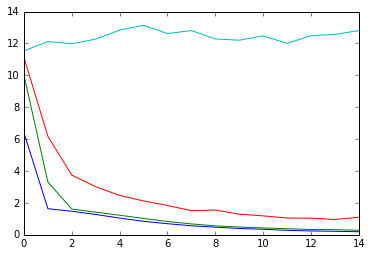

In [110]:
plt.plot(q25[0:])
#plt.plot(QsqAvgs[2:])
plt.plot(q50[0:])
plt.plot(q75[0:])
plt.plot(qmax[0:])

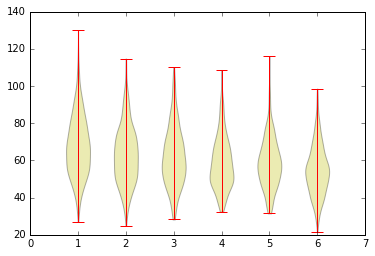

In [3282]:
plt.violinplot(sqMat[:,:].T);

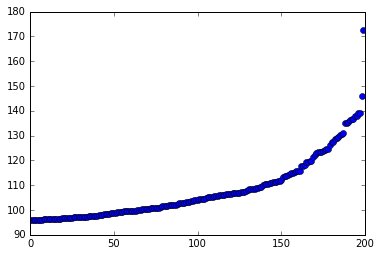

In [3017]:
test=frame_err_list[500:]
test.sort()
plt.plot(test[-200:],'o')

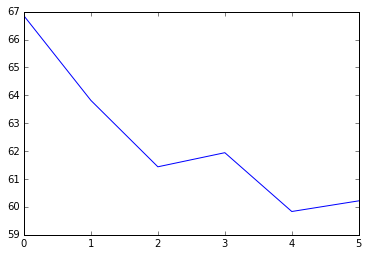

In [3004]:
pos = 0
iErrs = []
for game in jList:
    iErrs.append(np.mean(frame_err_list[pos:pos+game]))
    pos += game
plt.plot(iErrs[1:])

In [2735]:
def chained_pred(QN, action_gen, length, init_scalarInput, init_act, max_convs,
                 prob_roll=False, prob_cut_auto=True, prob_cutoff=0.9,
                return_prob=False, return_cm=True):
    f0_list = []
    pp_list = []
    cm_list = []
    
    cm = sess.run(QN.conv_movers,\
                 feed_dict={mainQN.scalarInput:np.vstack([init_scalarInput])})
    cm_f1 = sess.run(QN.conv_movers_frame1,\
                     feed_dict={mainQN.scalarInput:np.vstack([init_scalarInput])})
    old_a = init_act
    
    for step, a in enumerate(action_gen):
        cm_list.append(cm.copy())
        pred_logit = sess.run(mainQN.pred,\
                     feed_dict={mainQN.actions:[a],
                               mainQN.old_actions:[old_a],
                               mainQN.conv_movers:cm})
        pred_prob = softmax10(pred_logit)
        pp_list.append(pred_prob)
        rand_rolls = np.random.random_sample(pred_prob.shape)
        
        cm_f0[:,:,:,:] = cm_f1[:,:,:,:]
        for m_id in range(QN.n_movers):
            max_conv = max_convs[m_id]
            if prob_roll:
                cm_f1[:,...,m_id] = max_conv*(
                (pred_prob[:,...,m_id]>rand_rolls[:,...,m_id]).astype('float32'))
            elif prob_cut_auto:
                cm_f1[:,...,m_id] = max_conv*(
                    (pred_prob[:,...,m_id]>=np.max(pred_prob[:,...,m_id])).astype('float32'))
            else:
                cm_f1[:,...,m_id] = max_conv*(
                    (pred_prob[:,...,m_id]>prob_cutoff).astype('float32'))
        f0_list.append(cm_f0.copy())
        
        cm_f0_list = np.split(cm_f0,QN.n_movers,3)
        cm_f1_list = np.split(cm_f1,QN.n_movers,3)
        cm = np.concatenate([np.concatenate(tup,3) for tup in zip(cm_f0_list,
                                       cm_f1_list)], 3)
        
        old_a = a
        if step >= length:
            break
    ret_val = [f0_list]
    if return_prob:
        ret_val.append(pp_list)
    if return_cm:
        ret_val.append(cm_list)
    return ret_val

In [3049]:
testBatch = myBuffer.sample(1)

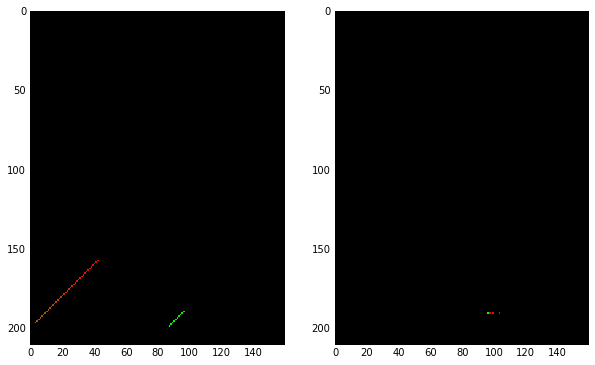

In [3050]:
prob_cut = 0.9

length = 100
f0_l, pp_l, cm_l = chained_pred(mainQN, [0 for i in range(length)], length,
                       testBatch[0,3], testBatch[0,1], [1 for i in range(mainQN.n_movers)],
                       prob_roll=False,
                       prob_cut_auto=True,
                       prob_cutoff=prob_cut,
                   return_prob=True, return_cm=True)

thresh = 0.1

channel = np.zeros_like(f0_l[0][0,:,:,:])
cm_color = np.stack([channel,channel,channel],2)
for i, cm in enumerate(f0_l):
    t = float(i)/len(f0_l)
    for m_id in range(cm.shape[3]):
        cm_mask = (cm[0,:,:,m_id]>thresh)
        cm_color[:,:,0,m_id][cm_mask] = (1-t)*(cm[0,:,:,m_id][cm_mask]>thresh)
        cm_color[:,:,1,m_id][cm_mask] =  t*(cm[0,:,:,m_id][cm_mask]>thresh)

plt.figure(figsize=(10,10))
for i in range(2):
        plt.subplot(1,2,i+1)
        plt.imshow(cm_color[:,:,:,i],interpolation='nearest')
plt.show()

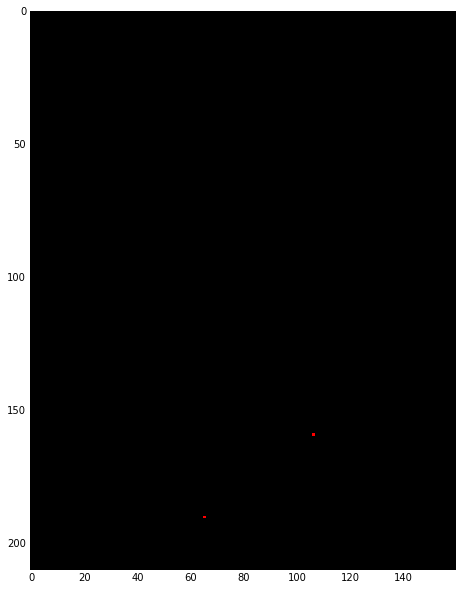

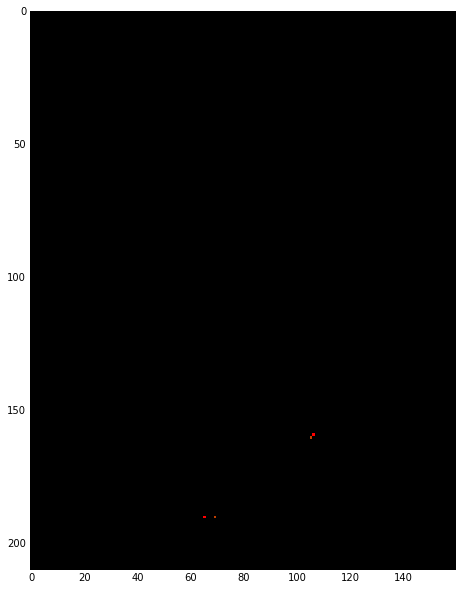

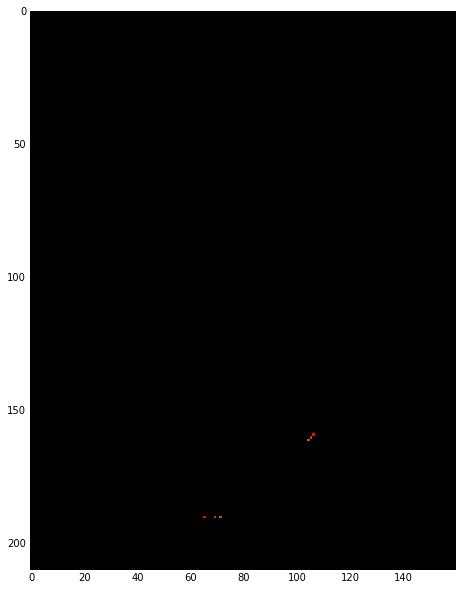

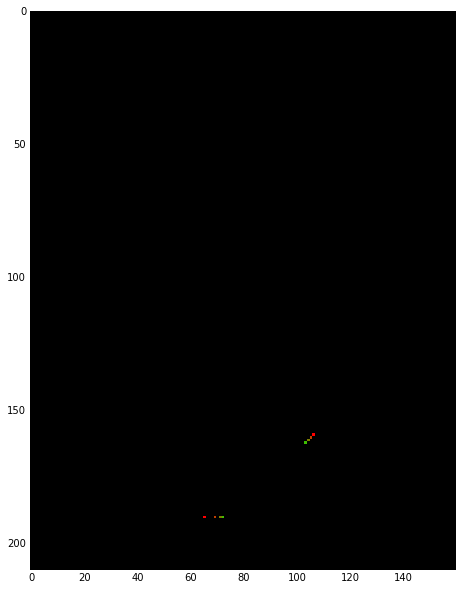

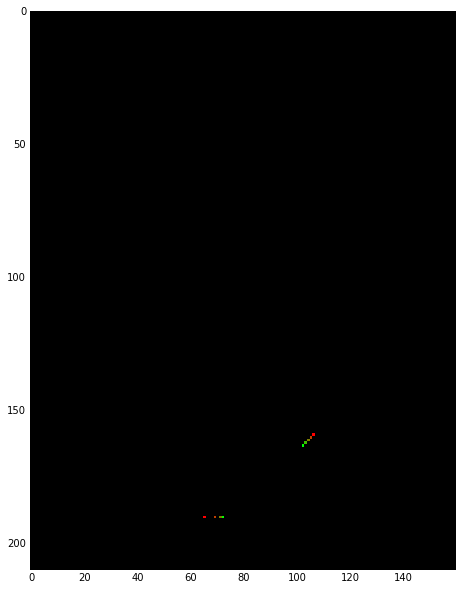

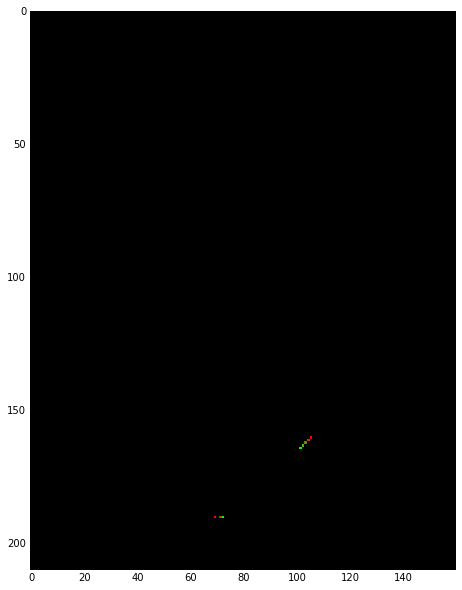

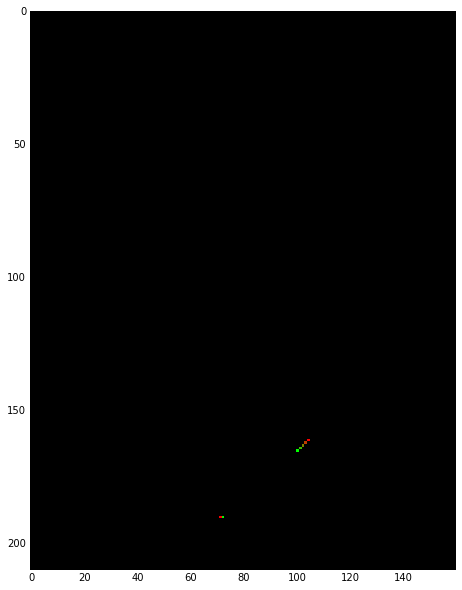

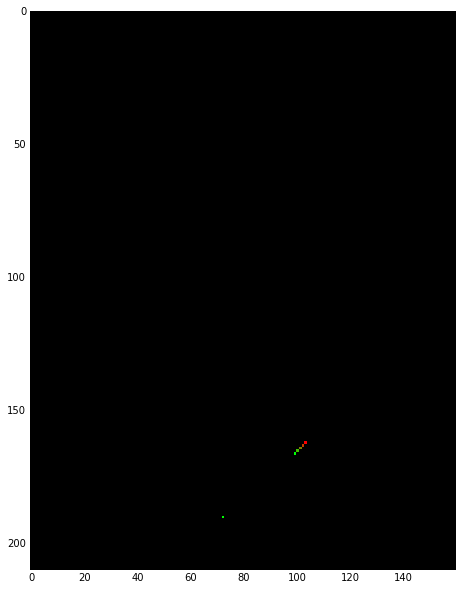

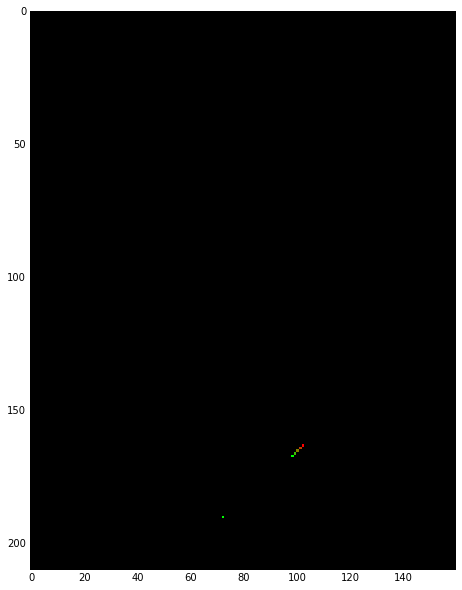

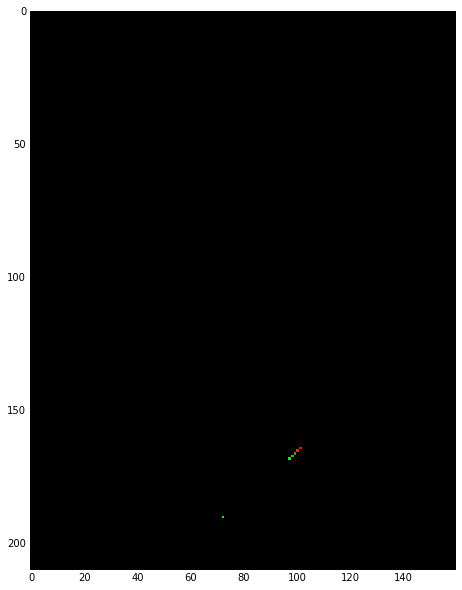

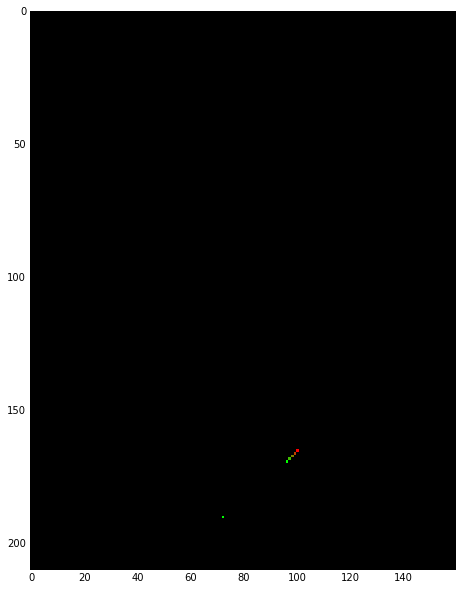

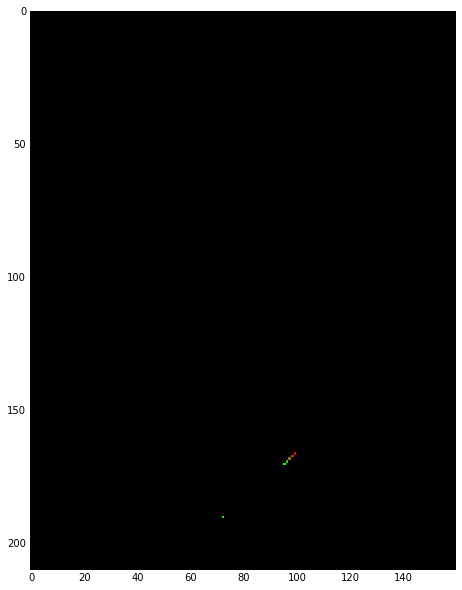

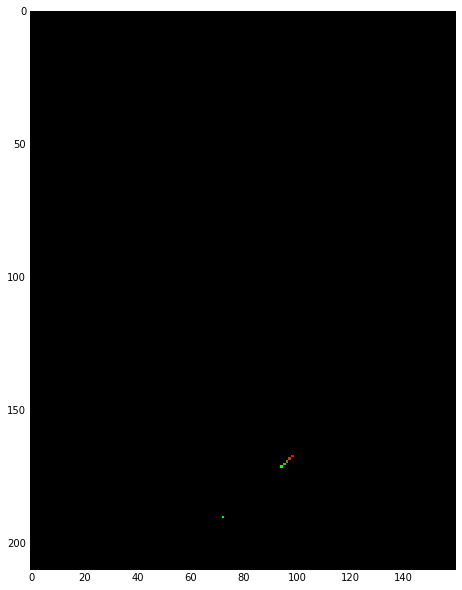

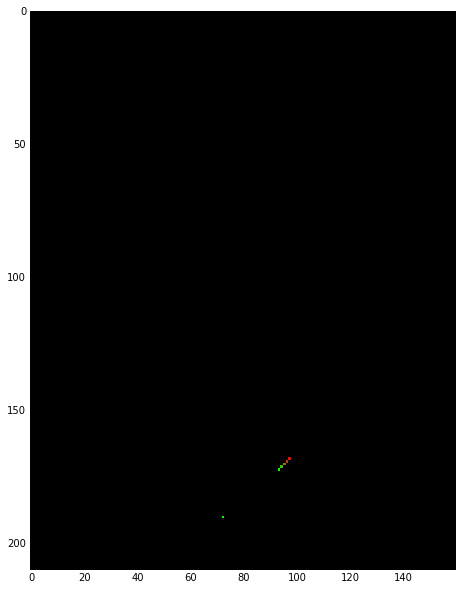

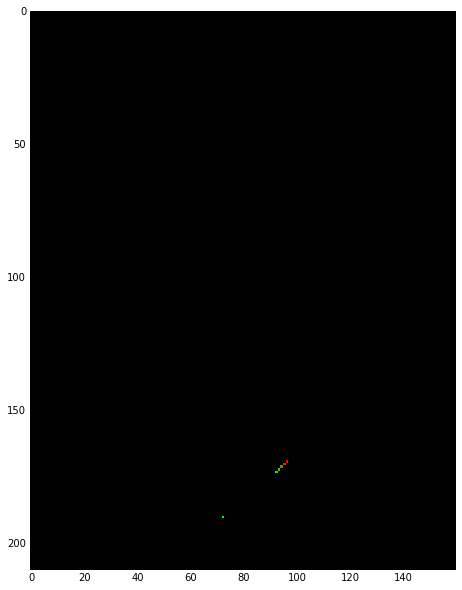

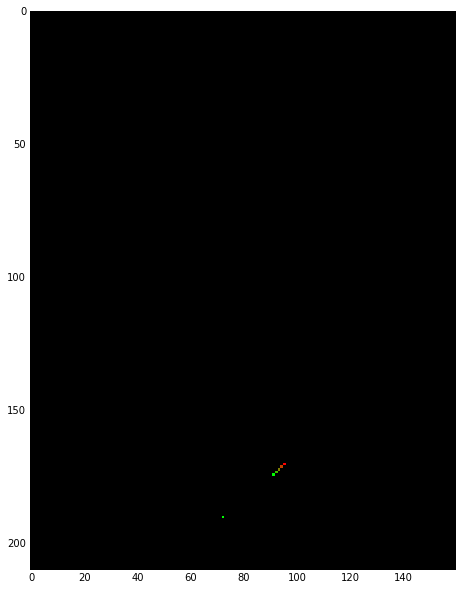

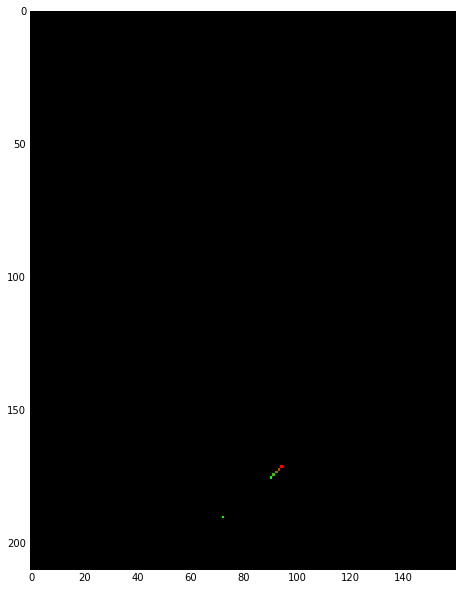

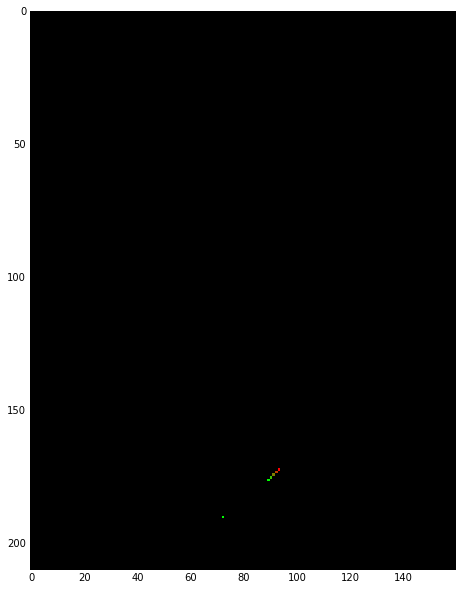

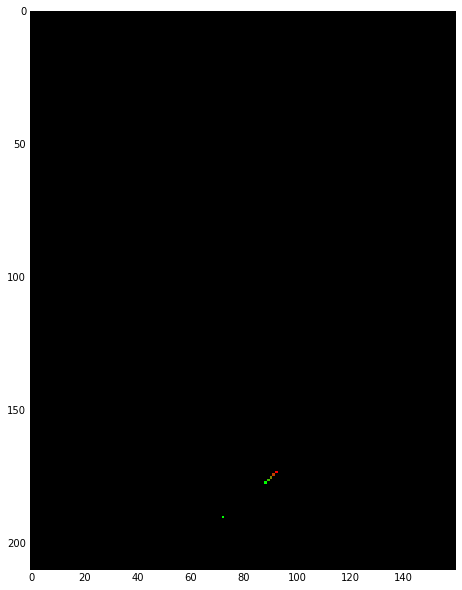

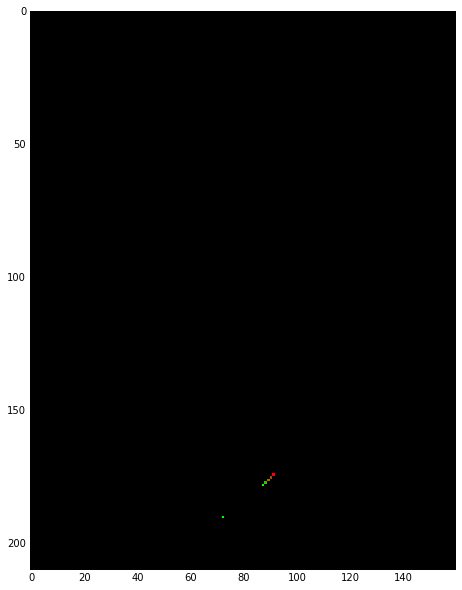

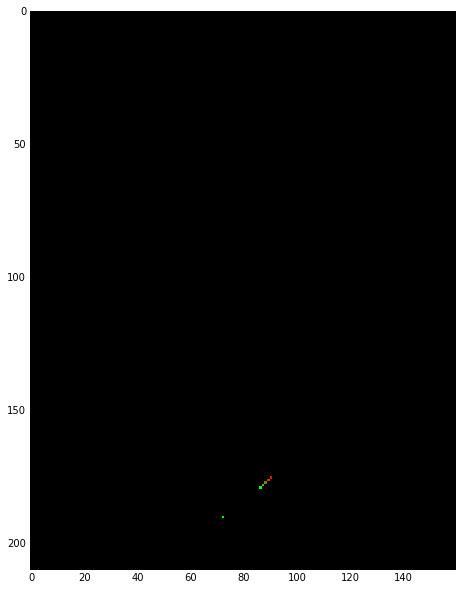

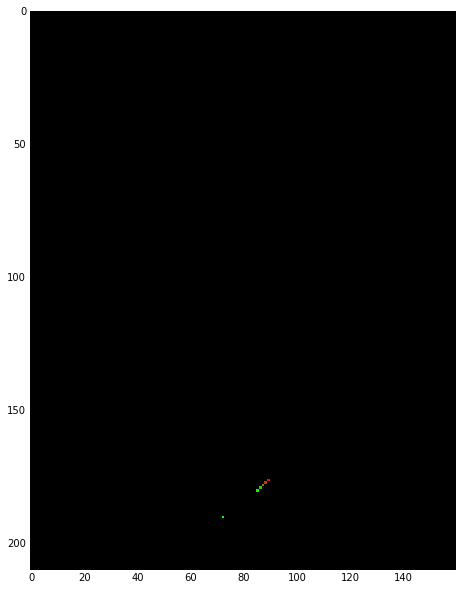

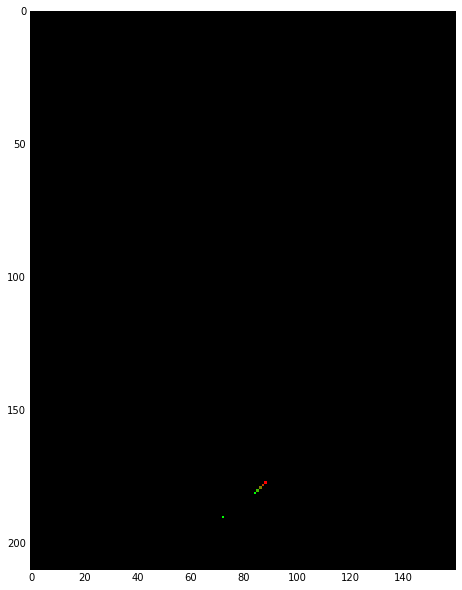

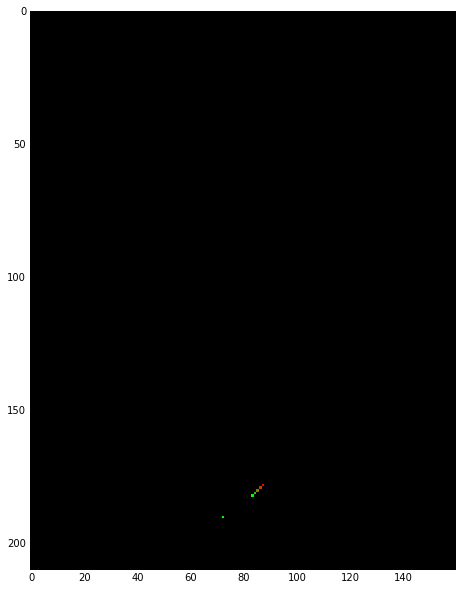

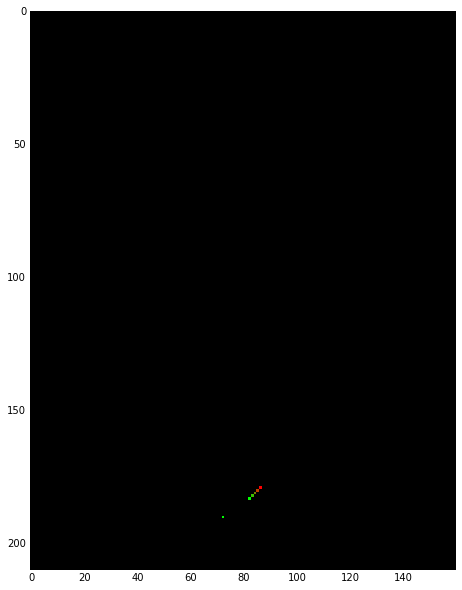

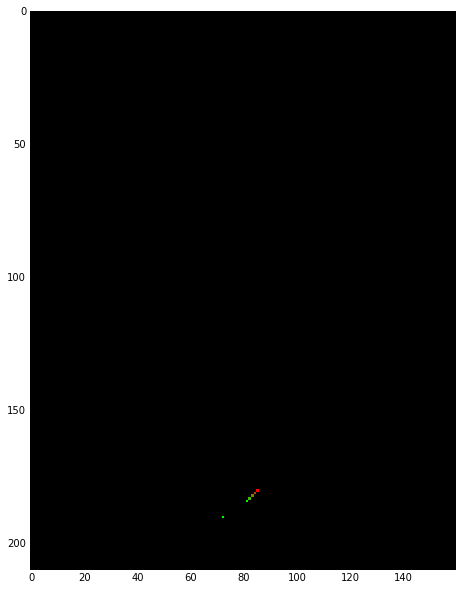

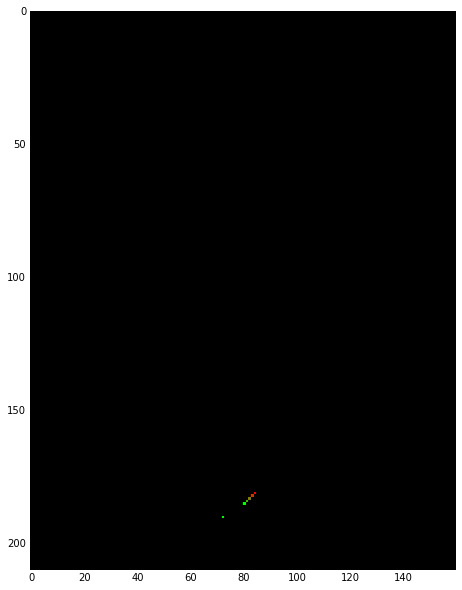

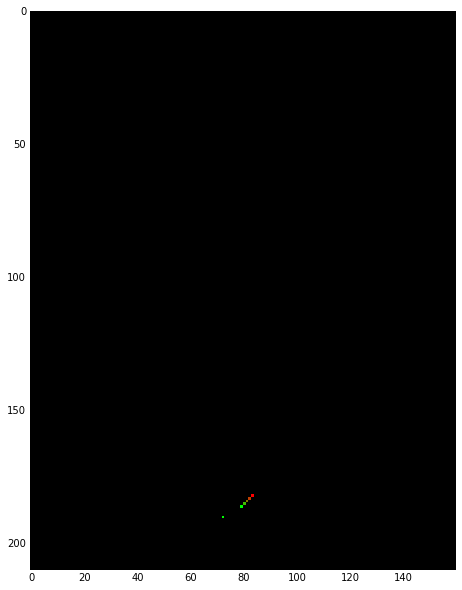

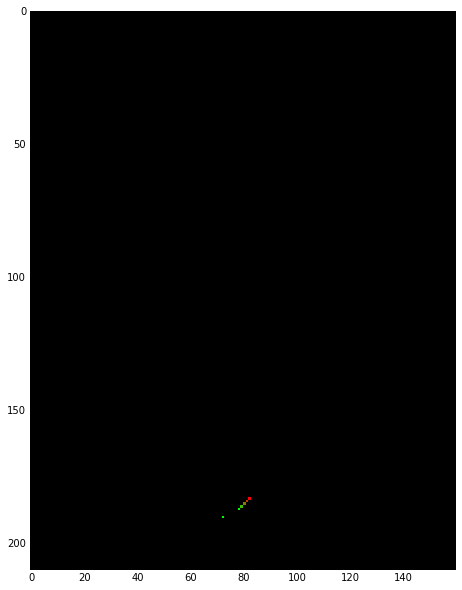

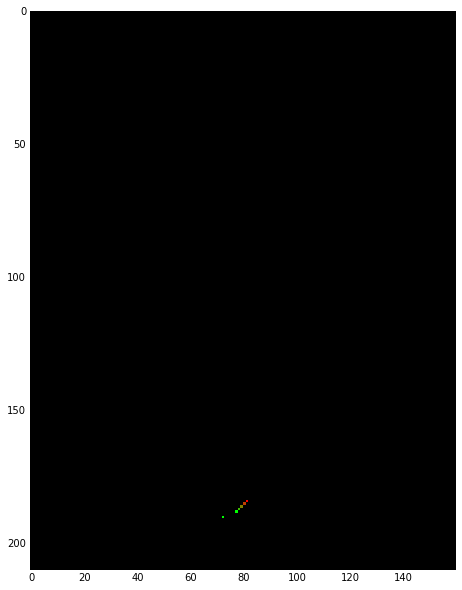

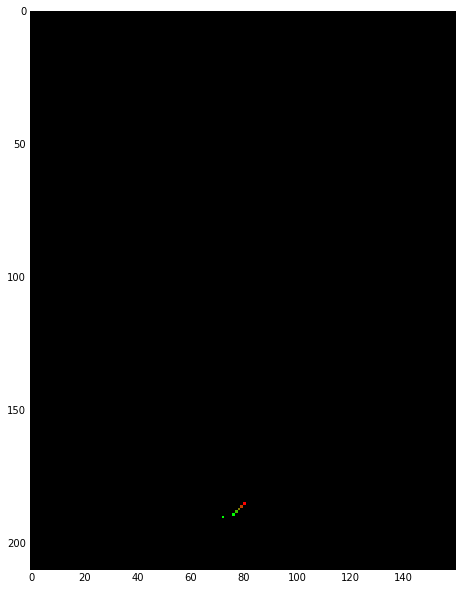

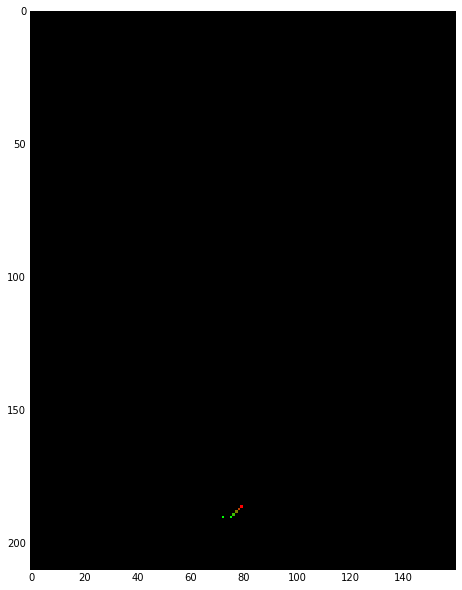

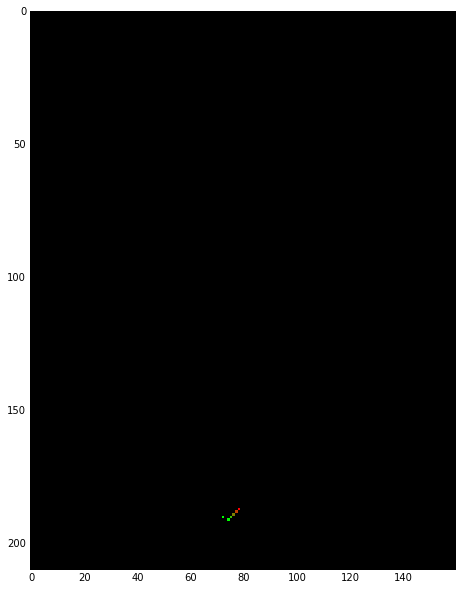

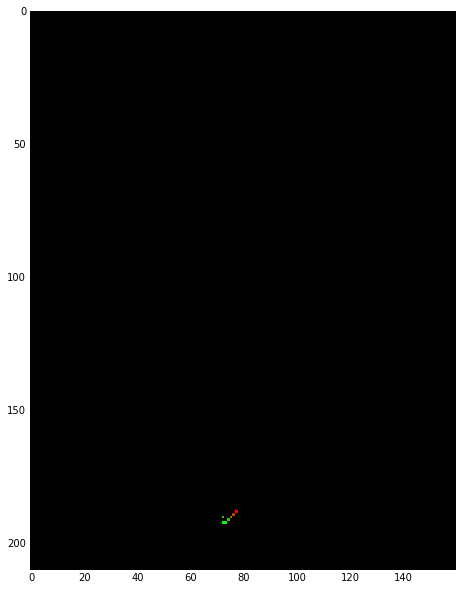

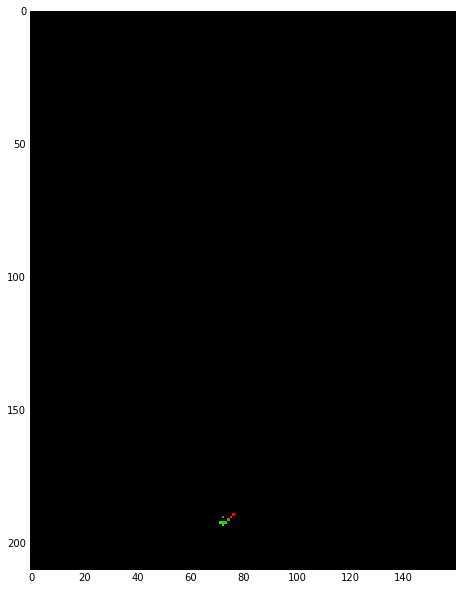

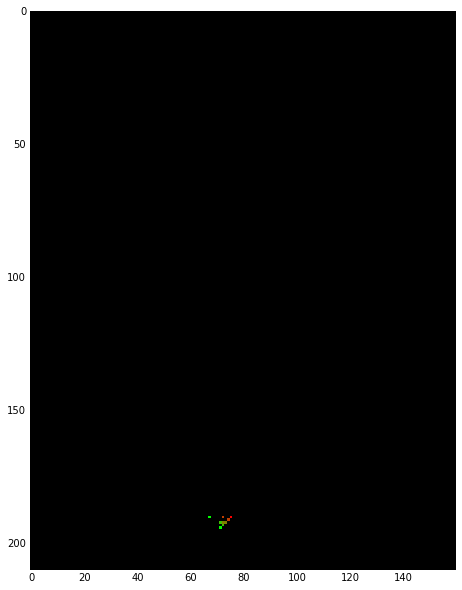

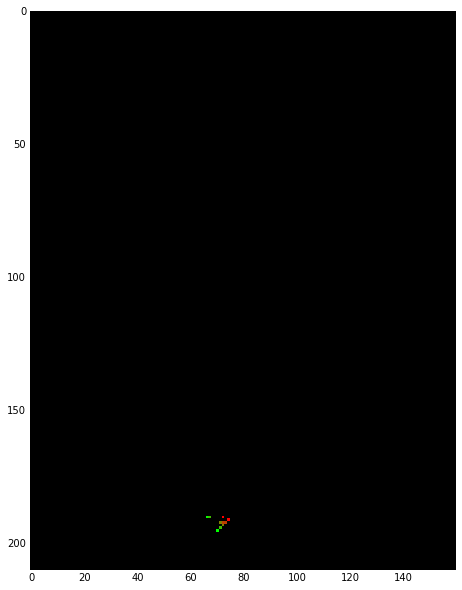

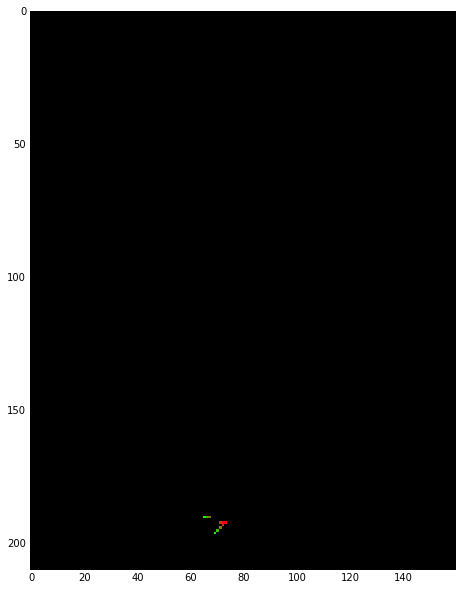

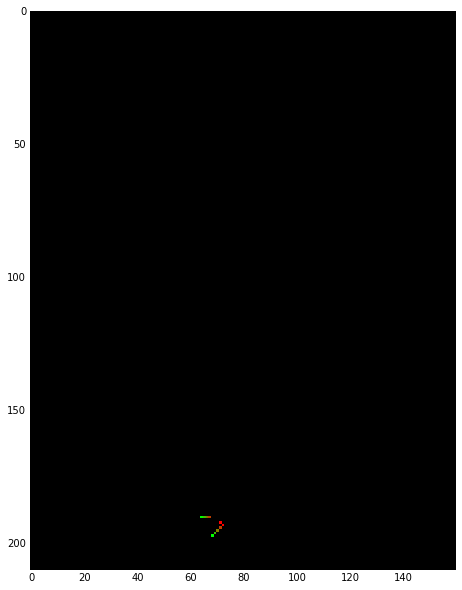

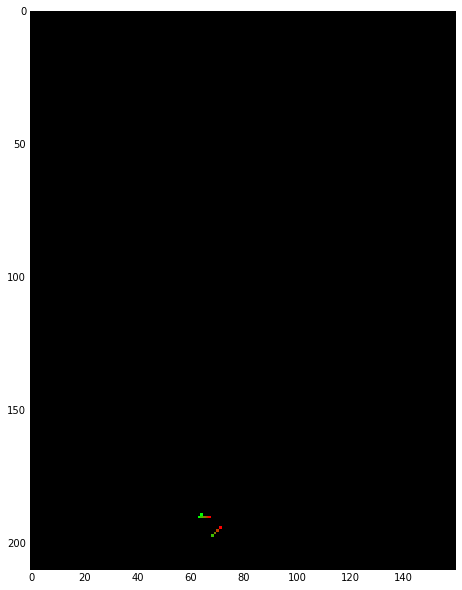

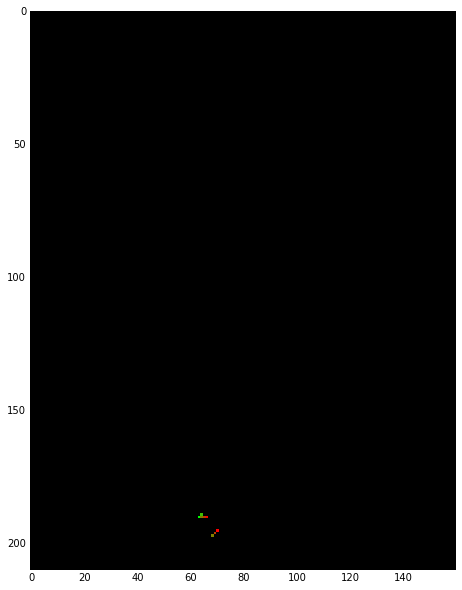

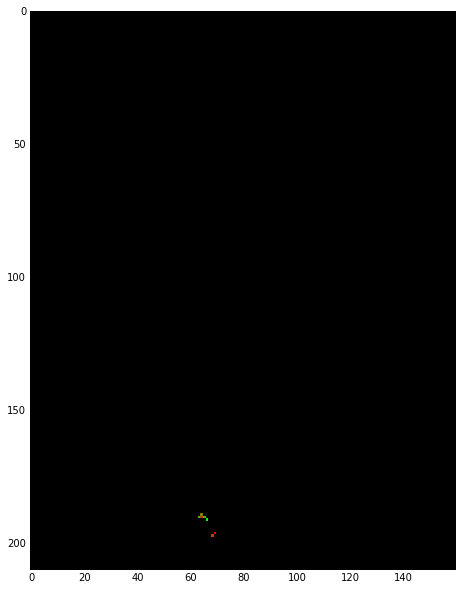

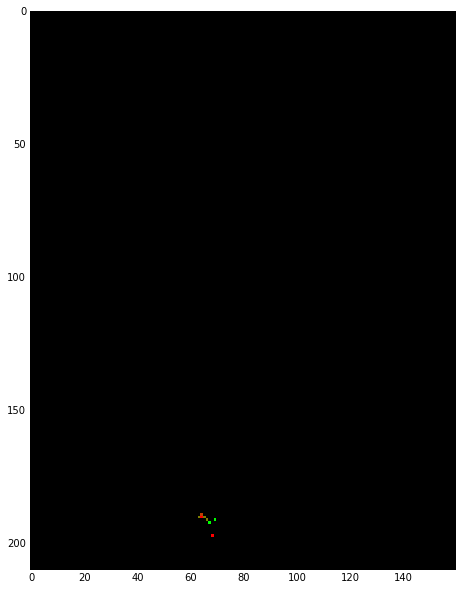

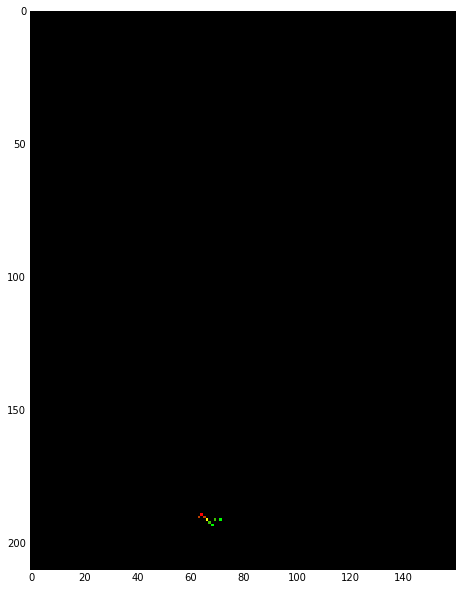

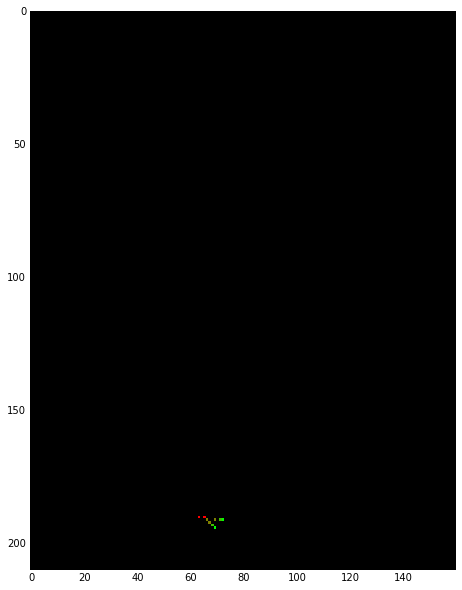

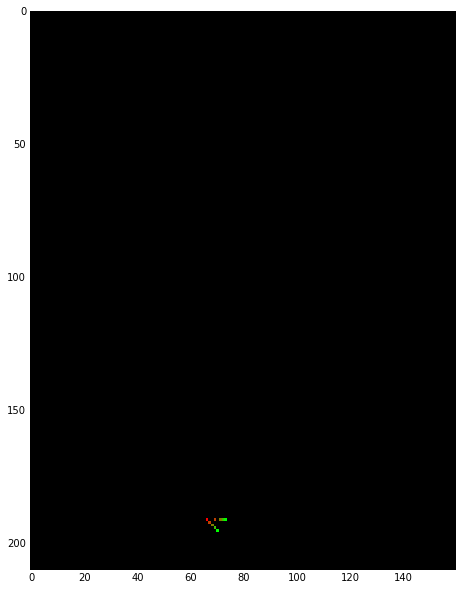

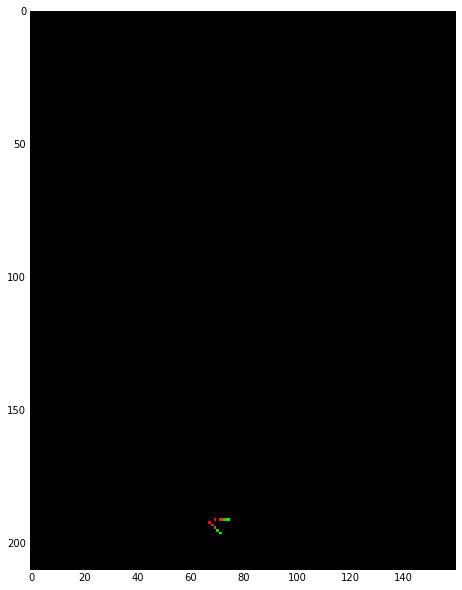

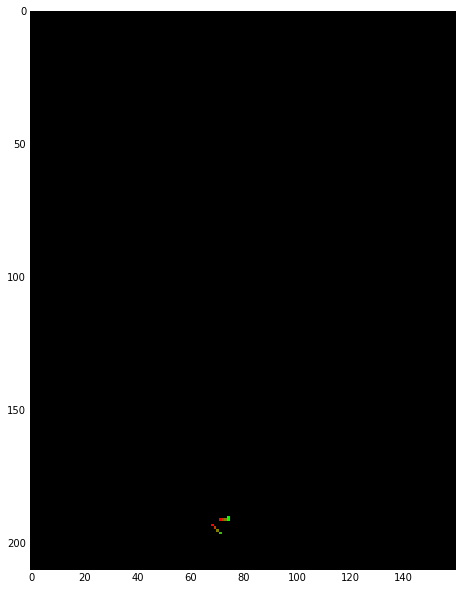

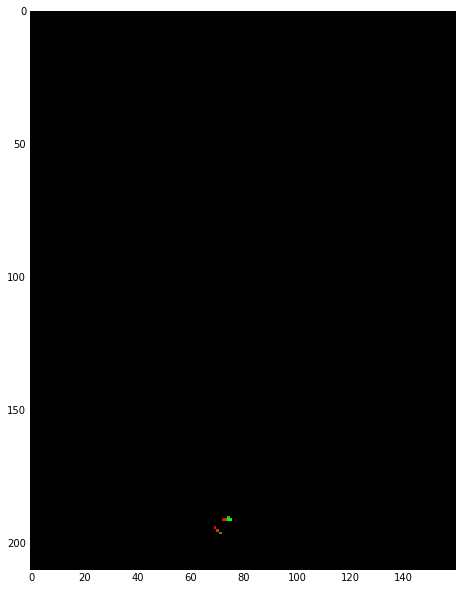

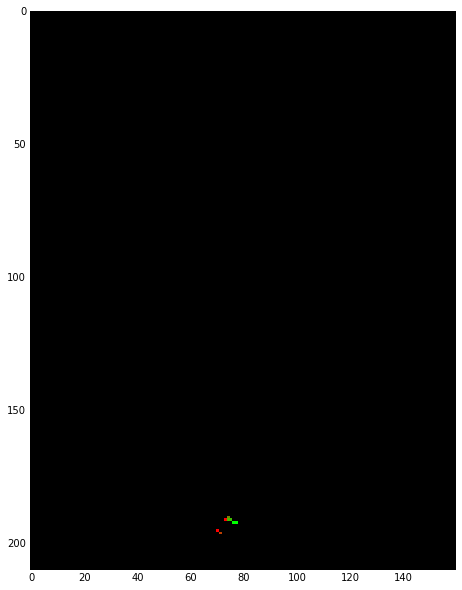

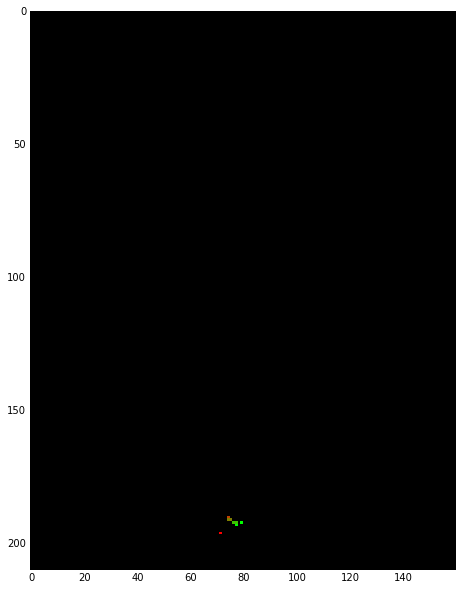

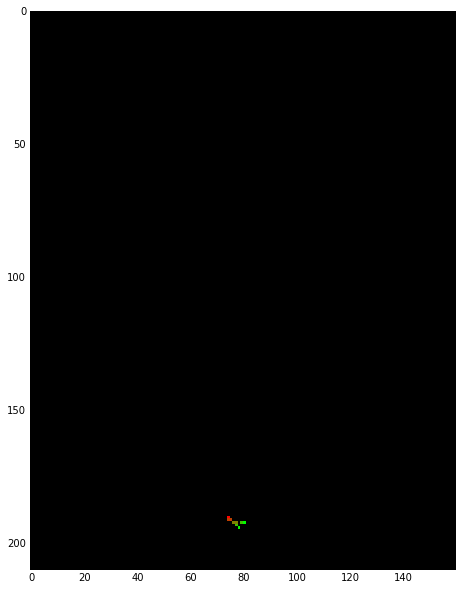

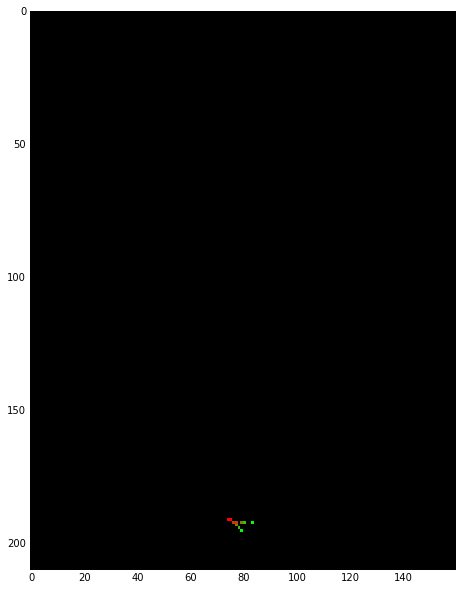

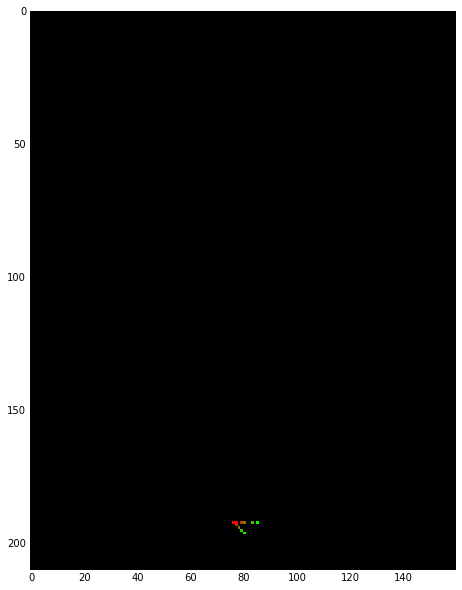

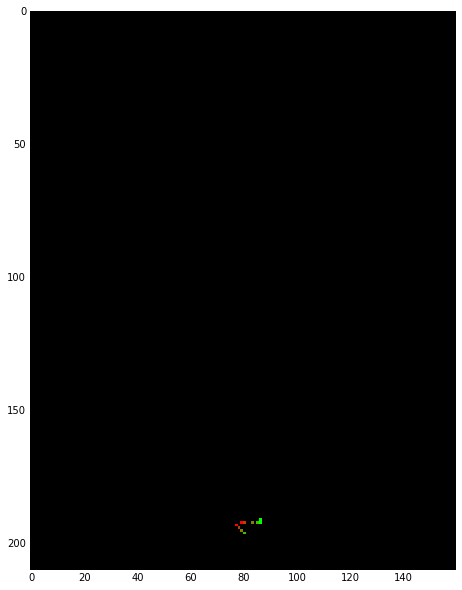

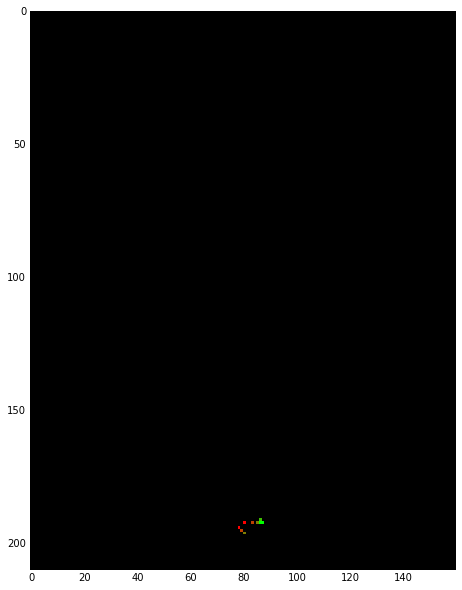

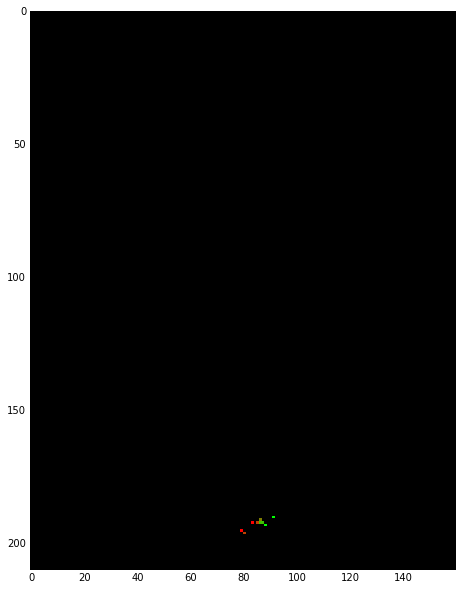

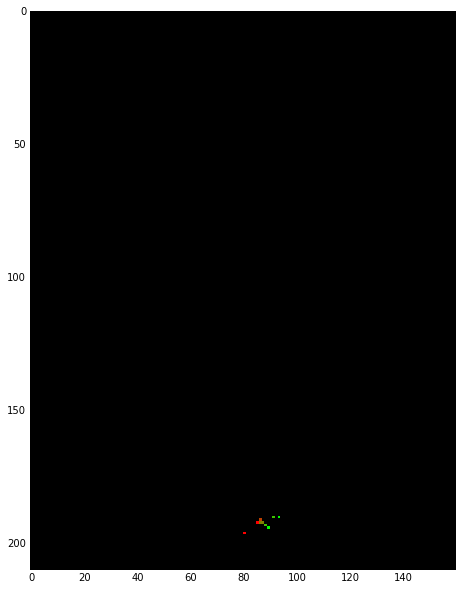

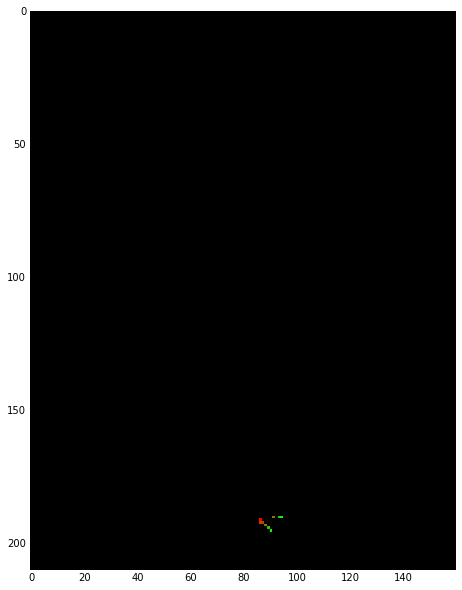

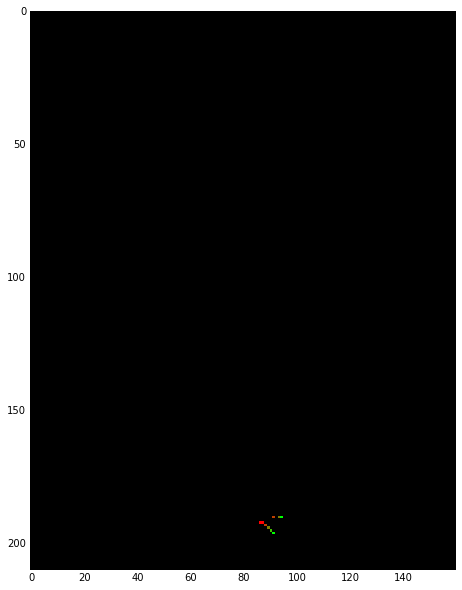

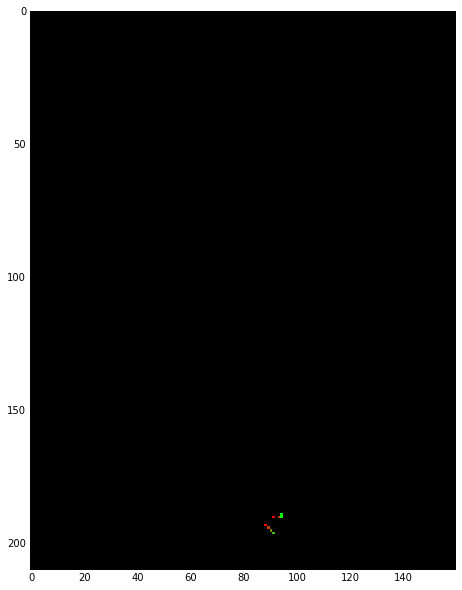

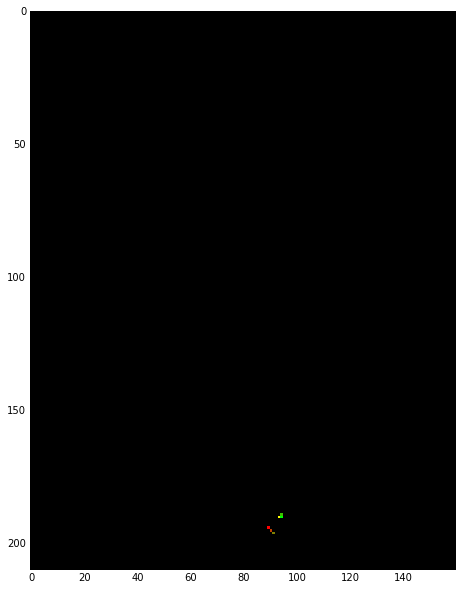

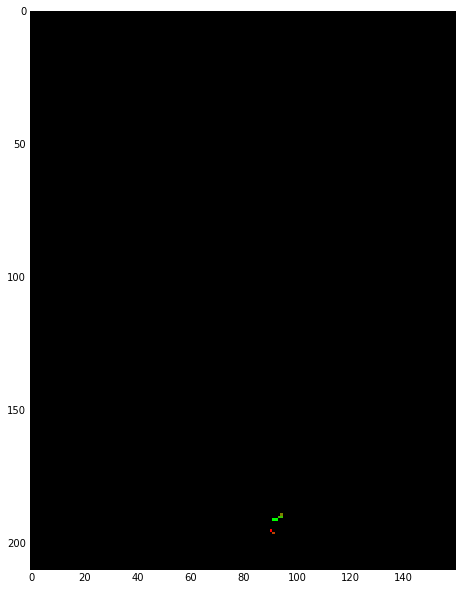

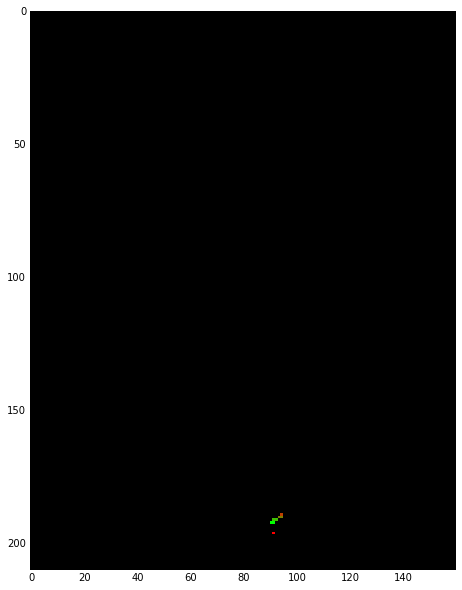

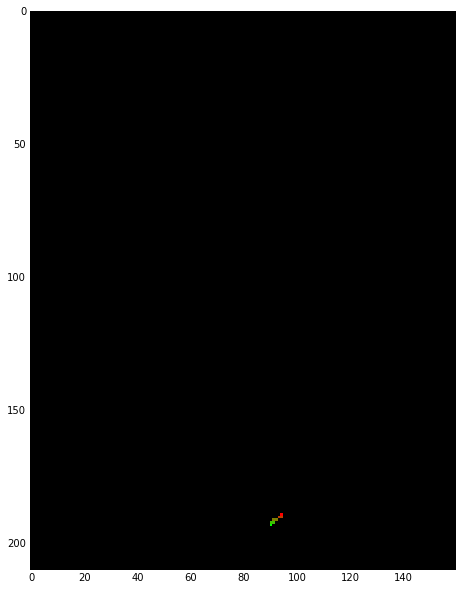

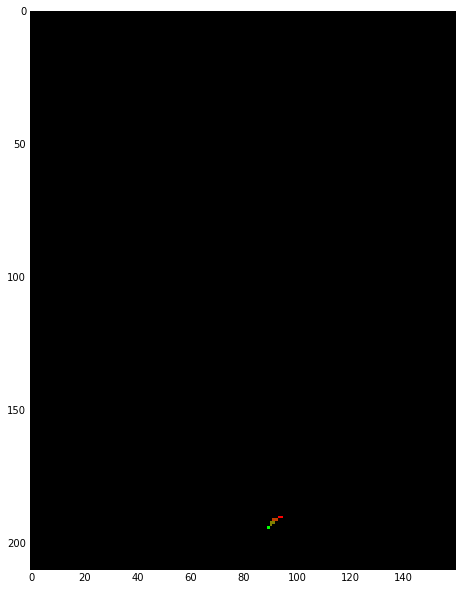

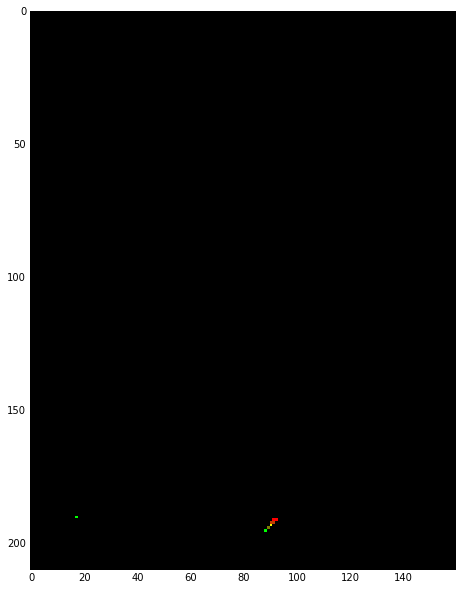

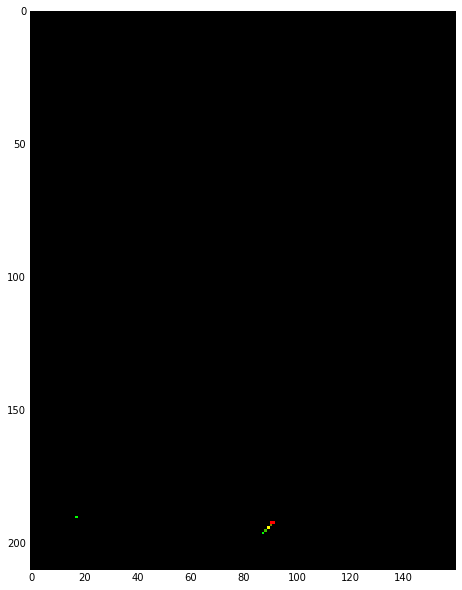

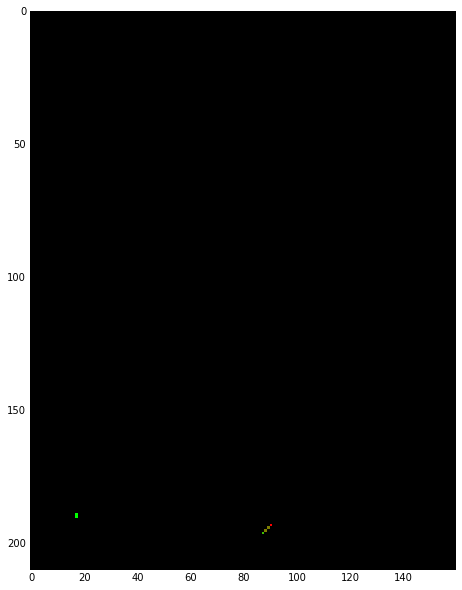

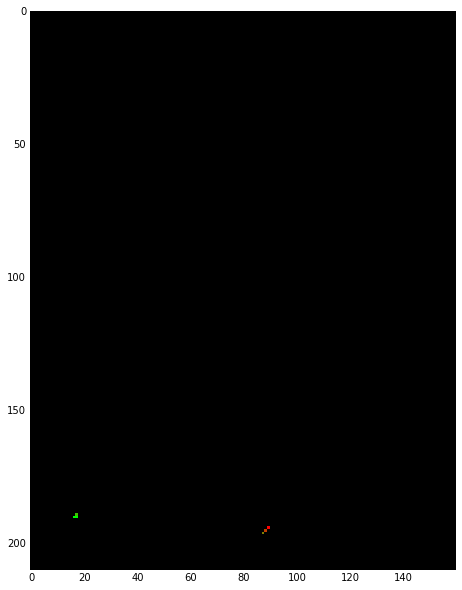

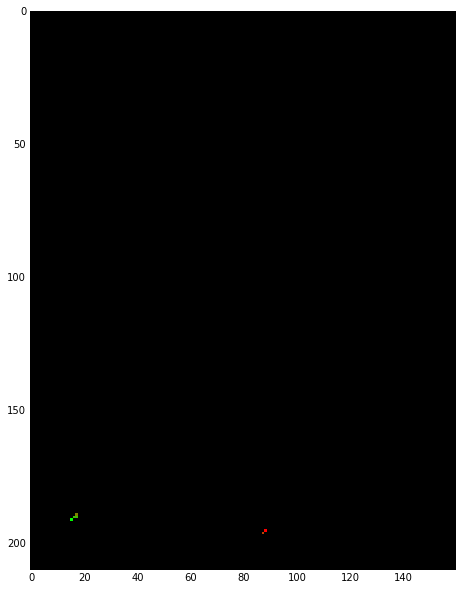

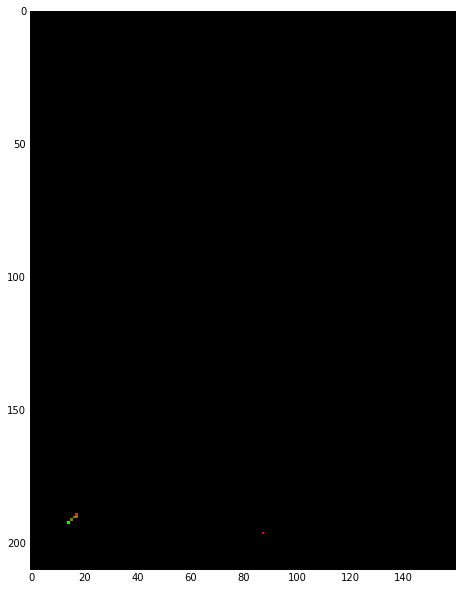

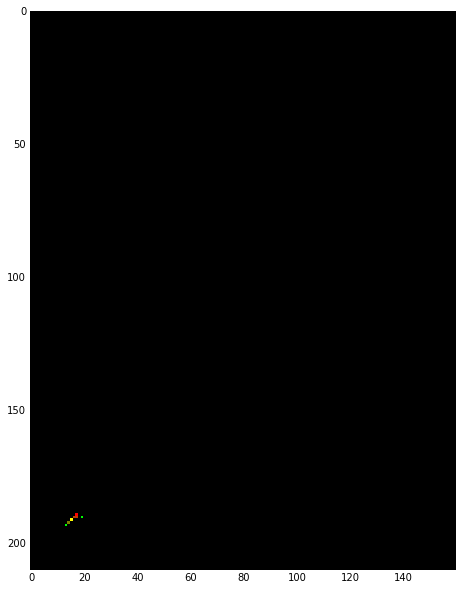

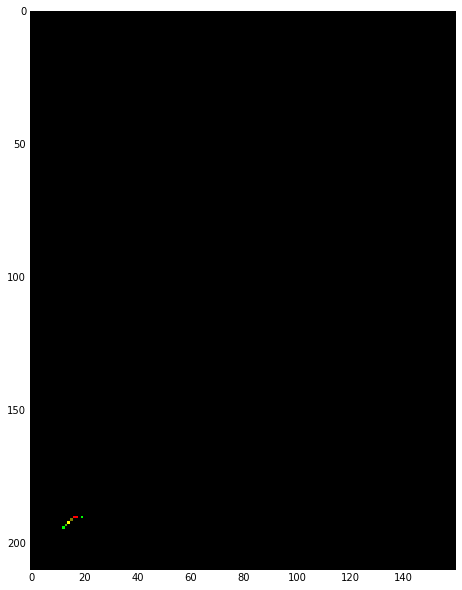

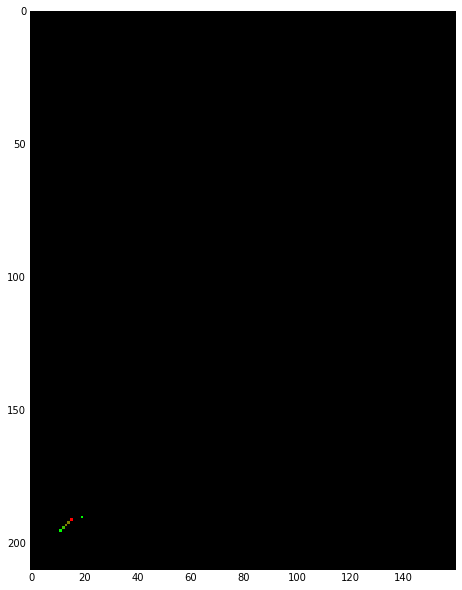

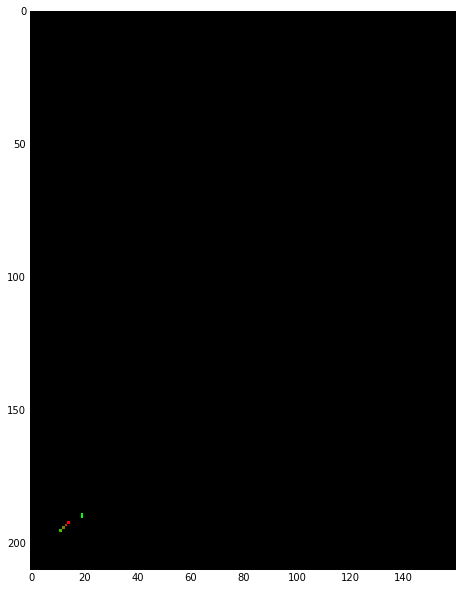

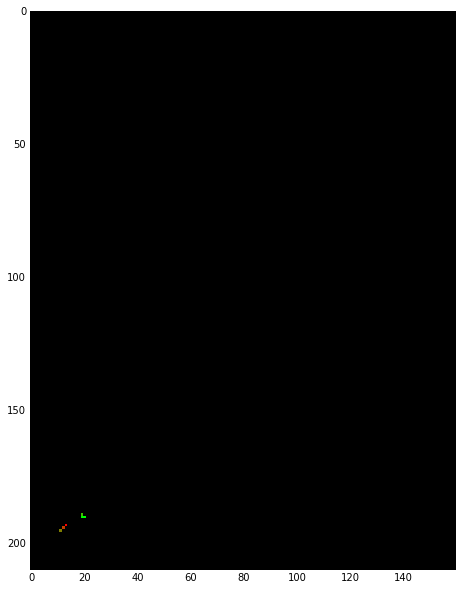

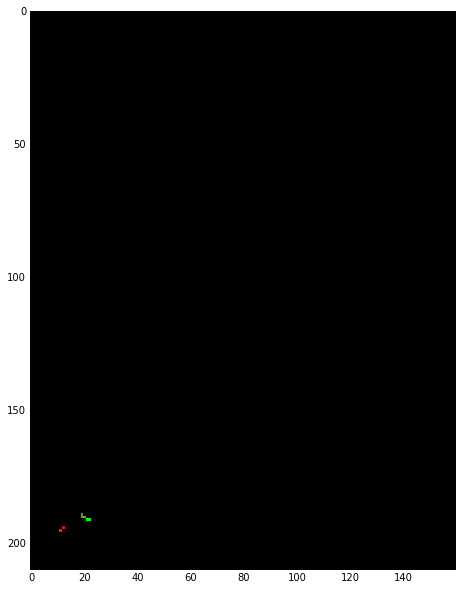

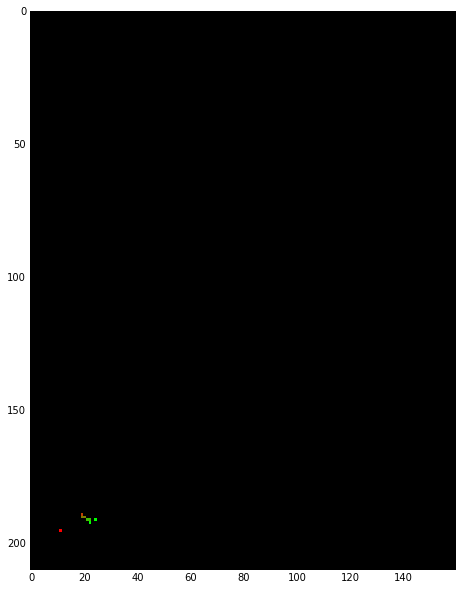

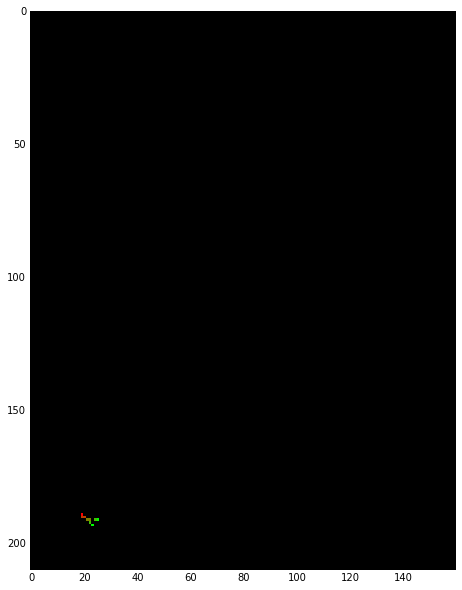

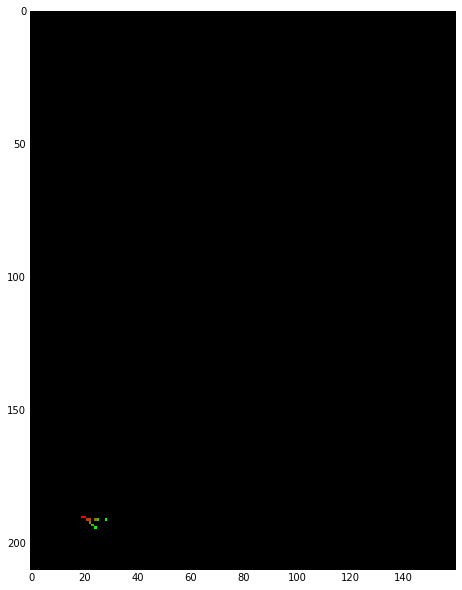

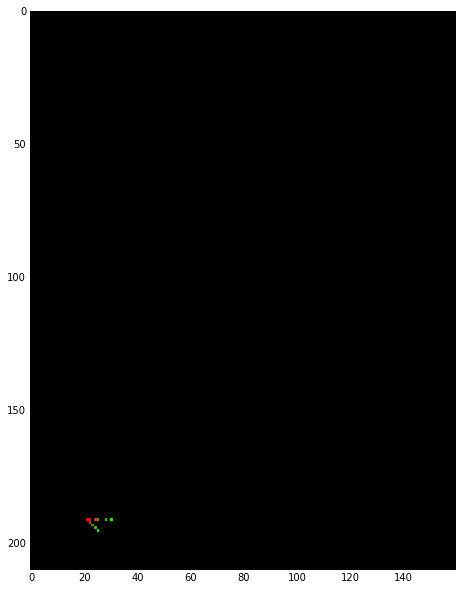

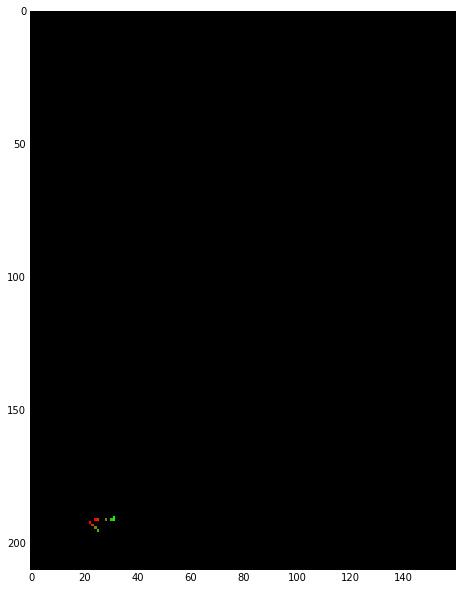

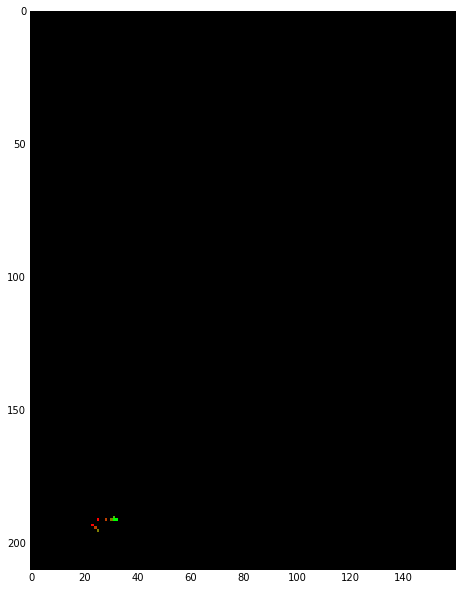

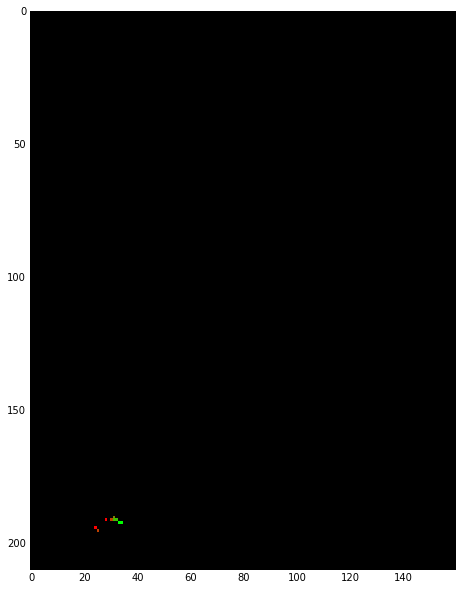

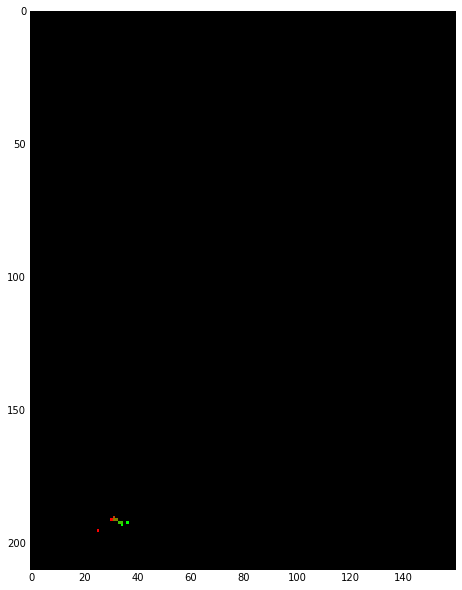

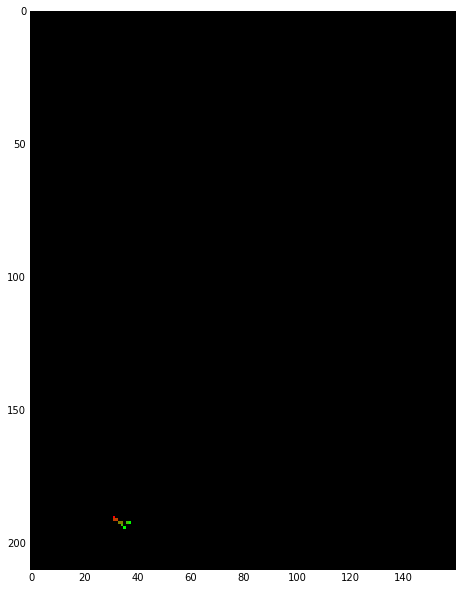

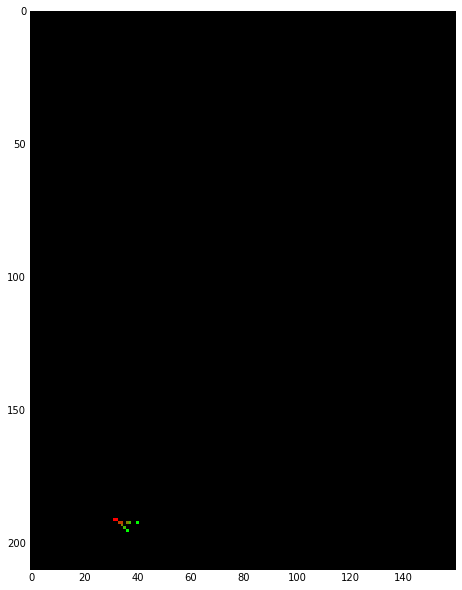

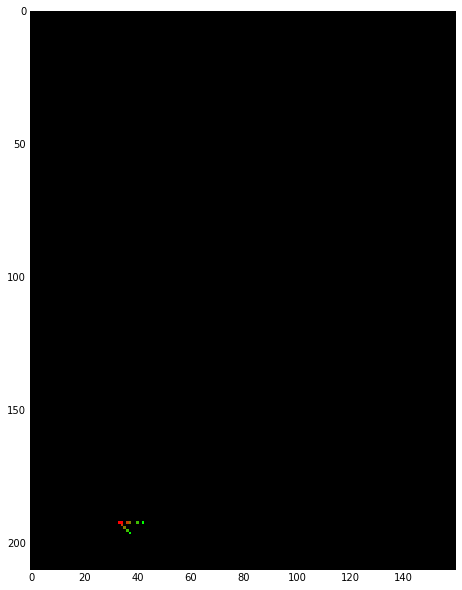

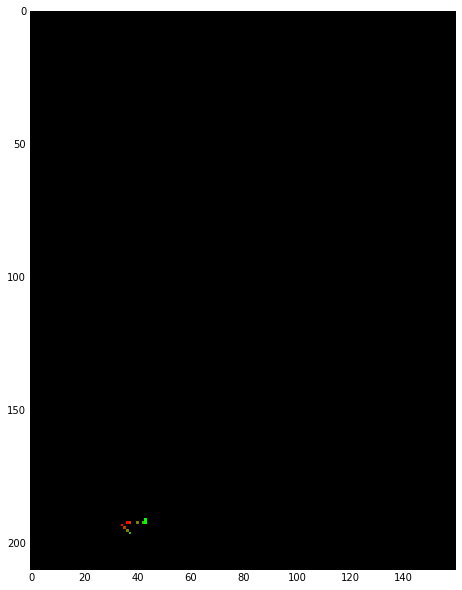

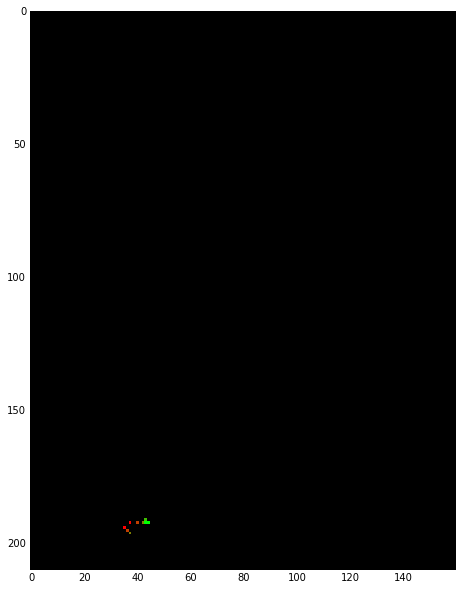

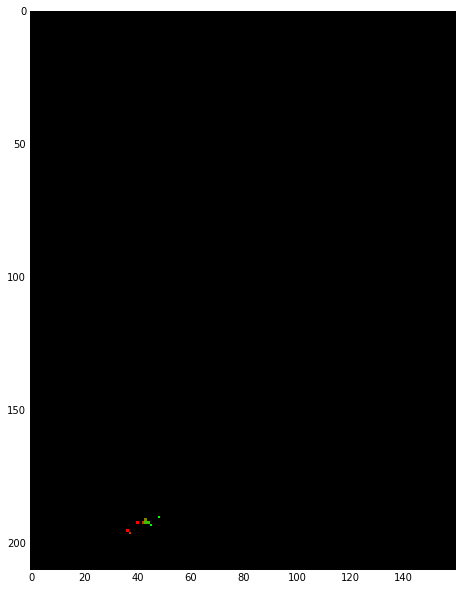

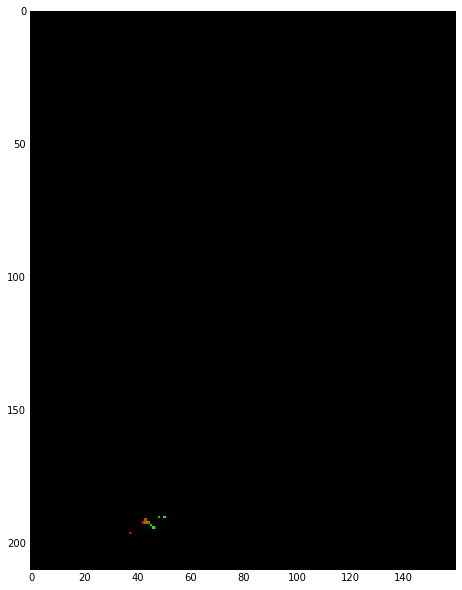

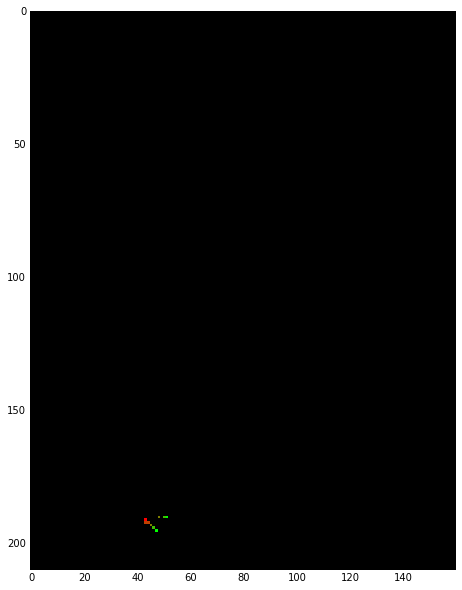

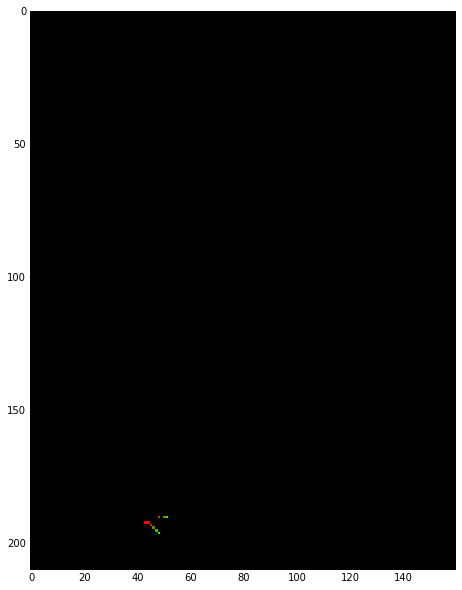

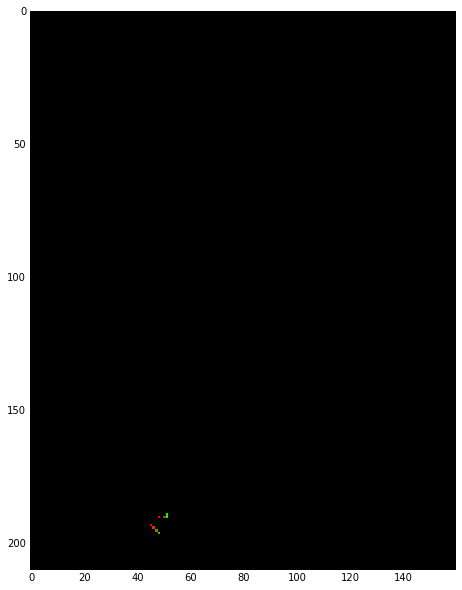

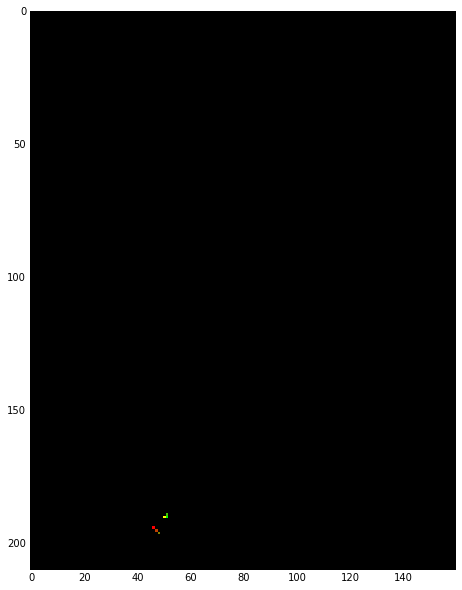

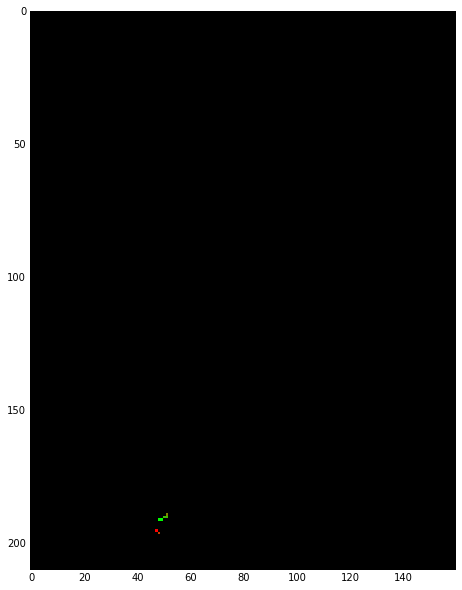

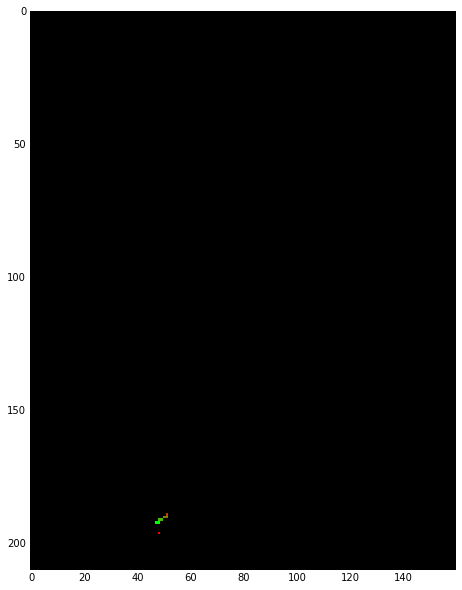

In [2970]:
trace_dur = 5

channel = np.zeros_like(f0_l[0][0,:,:,:])
for step in range(1,len(f0_l)):
    cm_color = np.stack([channel,channel,channel],2)
    for i, cm in enumerate(f0_l[max(0,step-trace_dur):step]):
        #t = float(i+max(0,step-trace_dur))/len(f0_l)
        t = float(i)/(trace_dur-1)
        for m_id in range(cm.shape[3]):
            cm_mask = (cm[0,:,:,m_id]>thresh)
            cm_color[:,:,0,m_id][cm_mask] = (1-t)*(cm[0,:,:,m_id][cm_mask]>thresh)
            cm_color[:,:,1,m_id][cm_mask] =  t*(cm[0,:,:,m_id][cm_mask]>thresh)

    plt.figure(figsize=(10,10))
    plt.imshow(np.sum(cm_color,3),interpolation='nearest')
#     for i in range(2):
#             plt.subplot(1,2,i+1)
#             plt.imshow(cm_color[:,:,:,i],interpolation='nearest')
    plt.show()

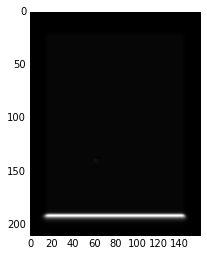

In [2918]:
plt.figure(figsize=(4,4))
pp_frame = pp_l[0][0,:,:,1]

vis_rad = 5
vis_center = np.unravel_index(np.argmax(pp_frame), pp_frame.shape)
pp_img = pp_frame#pp_frame[vis_center[0]-vis_rad:vis_center[0]+vis_rad,
                 #vis_center[1]-vis_rad:vis_center[1]+vis_rad]
plt.imshow(pp_img,interpolation='nearest',cmap='gray')
#np.unique(pp_img)

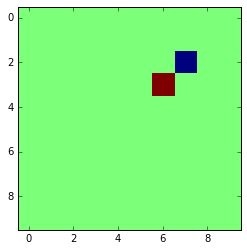

In [2710]:
plt.figure(figsize=(4,4))
cm_frame0 = cm_l[0][0,:,:,0]
cm_frame1 = cm_l[0][0,:,:,1]
f0_img = cm_frame0[vis_center[0]-vis_rad:vis_center[0]+vis_rad,
                 vis_center[1]-vis_rad:vis_center[1]+vis_rad]
f1_img = cm_frame1[vis_center[0]-vis_rad:vis_center[0]+vis_rad,
                 vis_center[1]-vis_rad:vis_center[1]+vis_rad]
plt.imshow(f1_img-f0_img,interpolation='nearest')
#plt.colorbar();

In [2474]:
np.unravel_index(np.argmax(f0_l[10][0,:,:,1]),f0_l[0][0,:,:,1].shape)

(190, 71)

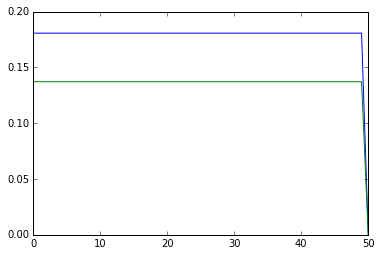

In [2379]:
mover_maxes = np.zeros((length+1,mainQN.n_movers))
for step, cm in enumerate(f0_l):
    for m_id in range(mainQN.n_movers):
        mover_maxes[step,m_id] = np.max(cm[0,:,:,m_id])
        
plt.plot(mover_maxes)

In [3324]:
displayBatch = myBuffer.sample(500)
target_pool = sess.run(mainQN.cm_pool,feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,3])})
pred_pool = sess.run(mainQN.pred_pool,\
                     feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]), 
                                mainQN.actions:displayBatch[:,1],
                                mainQN.old_actions:displayBatch[:,5]})
previous_pool = sess.run(mainQN.cm_pool,feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0])})

pred_V = sess.run(mainQN.streamV,\
         feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]),
                    mainQN.actions:displayBatch[:,1],
                    mainQN.old_actions:displayBatch[:,5]})
pred_A = sess.run(tf.einsum('abcde,ae->abcd',mainQN.streamA,mainQN.actions_onehot),\
                     feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]),
                                mainQN.actions:displayBatch[:,1],
                                mainQN.old_actions:displayBatch[:,5]})

collisions = sess.run(mainQN.conv_collisions,
                         feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0])})


actions = displayBatch[:,1]
old_actions = displayBatch[:,5]

In [3325]:
target = sess.run(mainQN.conv_movers_frame1,feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,3])})

loss = sess.run(mainQN.log_losses, \
                    feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]),
                               mainQN.target:target, 
                               mainQN.actions:displayBatch[:,1],
                               mainQN.old_actions:displayBatch[:,5]})

In [3327]:
loss_batch_mean = np.sum(np.reshape(loss,(500,len(loss)//500)),1)

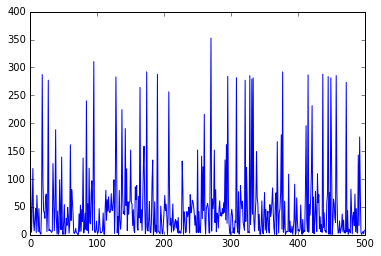

In [3329]:
plt.plot(batch_size*loss_batch_mean)

In [3330]:
import pandas as pd
df = pd.DataFrame(batch_size*loss_batch_mean)
df['actions'] = actions
df['old_actions'] = old_actions

#df.groupby(['actions']).mean()
df.groupby(['actions','old_actions']).mean()

0
actions old_actions            
0       0             23.981627
        1             48.477814
        2             55.093002
        3             52.986641
1       0             33.382236
        1             46.957508
        2             73.450043
        3             61.770267
2       0             32.975449
        1             40.795906
        2             62.082706
        3             66.305115
3       0             19.277609
        1             29.391916
        2             45.828499
        3            104.116058

In [3331]:
sort_inds = np.argsort(loss_batch_mean)[::-1]

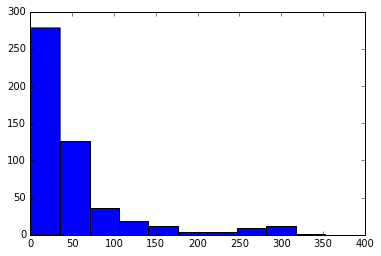

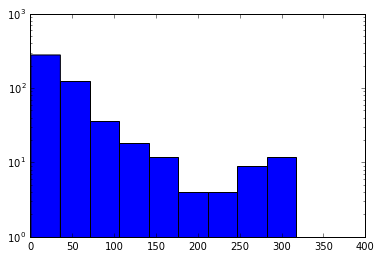

In [3332]:
plt.hist(batch_size*loss_batch_mean,bins=10,log=False); plt.show()
plt.hist(batch_size*loss_batch_mean,bins=10,log=True);

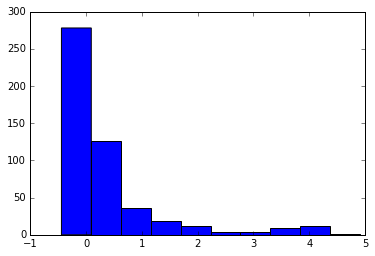

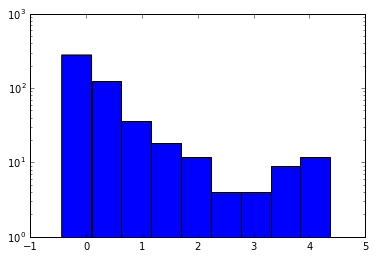

In [3333]:
plt.hist((loss_batch_mean-np.median(loss_batch_mean))/np.std(loss_batch_mean),bins=10,log=False); plt.show()
plt.hist((loss_batch_mean-np.median(loss_batch_mean))/np.std(loss_batch_mean),bins=10,log=True);

1
2
('loss', 4.9072542)


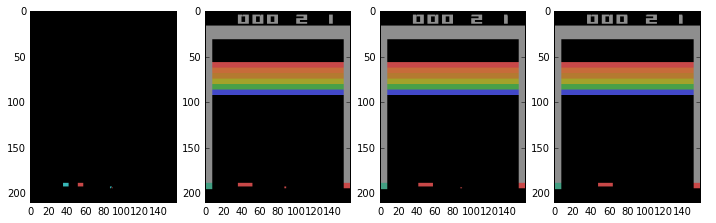

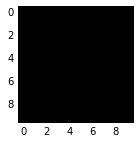

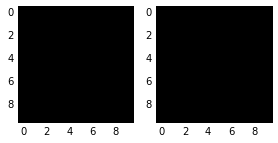

([0.0], [0.0])


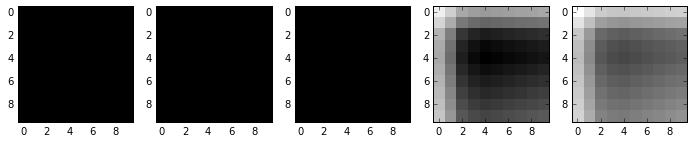

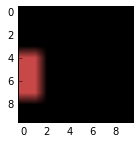

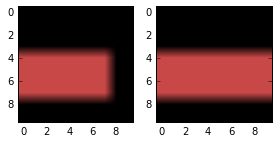

([0.0], [0.0, 1.0])


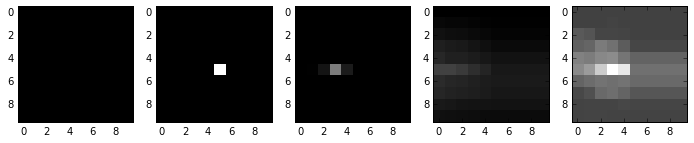

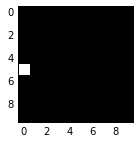

(0.0, 0.80000001)
0
1
('loss', 4.2696967)


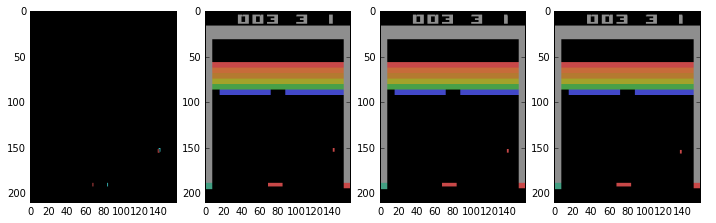

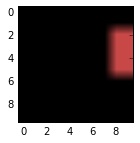

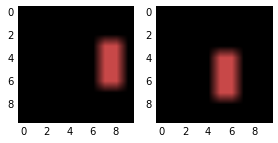

([0.0, 1.0], [0.0, 1.0])


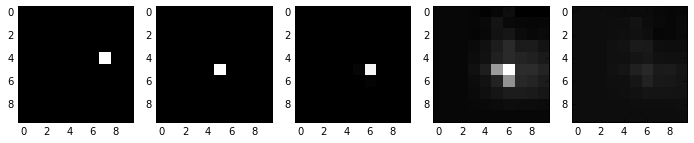

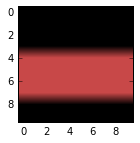

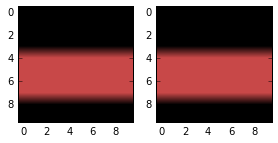

([0.0, 1.0], [0.0, 1.0])


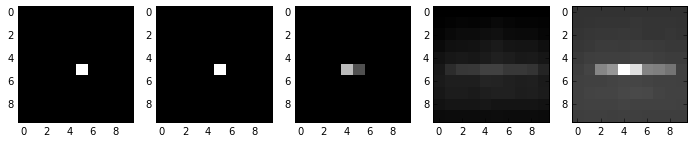

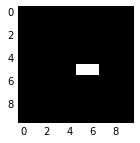

(0.0, 0.80000001)
0
3
('loss', 3.9890187)


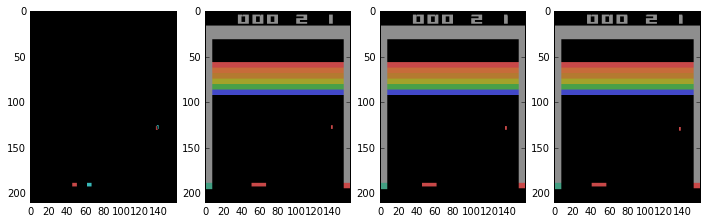

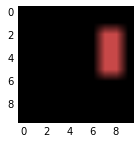

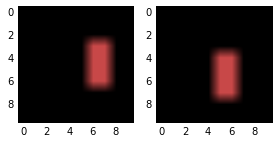

([0.0, 1.0], [0.0, 1.0])


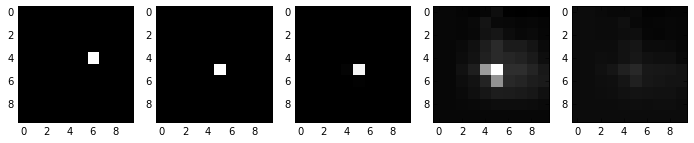

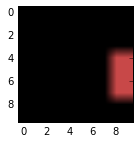

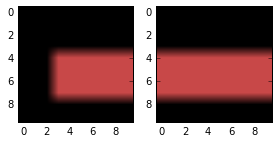

([0.0], [0.0, 1.0])


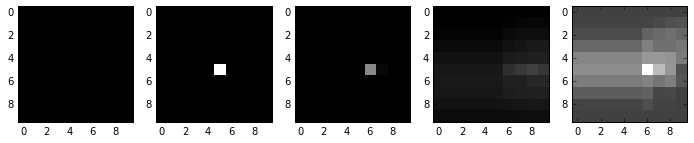

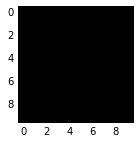

(0.0, 0.0)
0
3
('loss', 3.9862161)


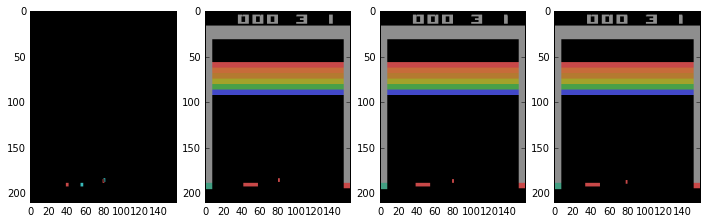

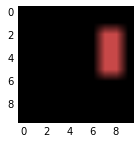

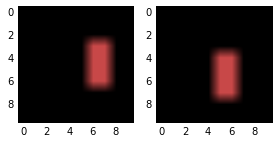

([0.0, 1.0], [0.0, 1.0])


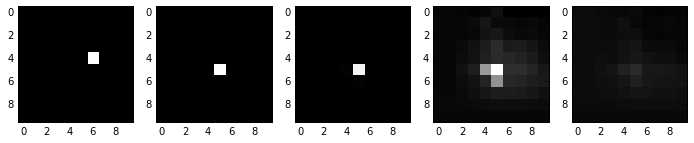

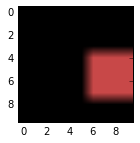

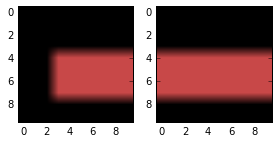

([0.0], [0.0, 1.0])


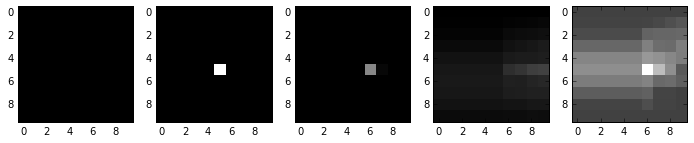

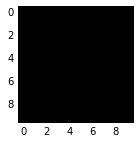

(0.0, 0.0)
1
3
('loss', 3.9244919)


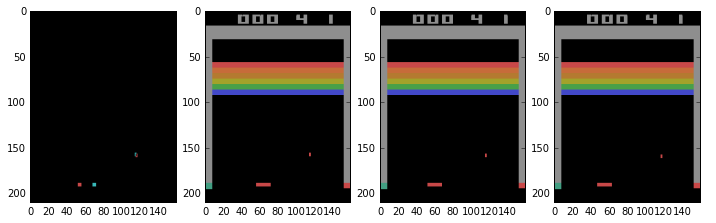

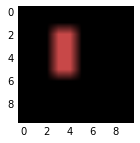

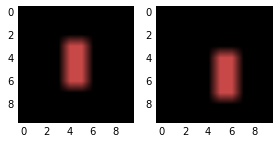

([0.0, 1.0], [0.0, 1.0])


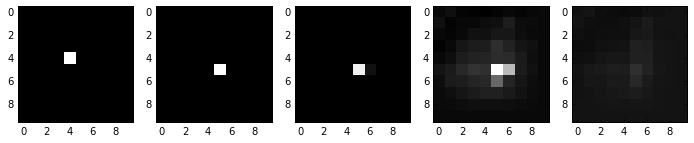

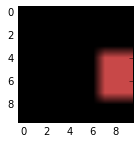

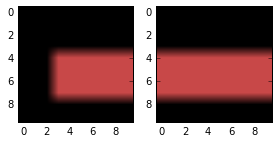

([0.0], [0.0, 1.0])


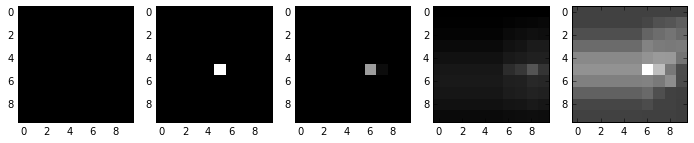

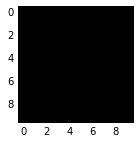

(0.0, 0.0)
1
3
('loss', 3.9233599)


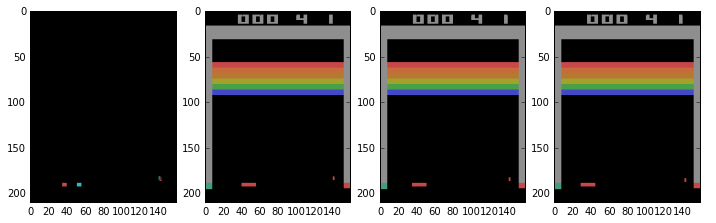

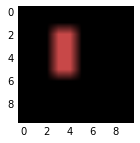

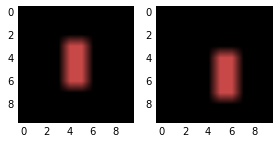

([0.0, 1.0], [0.0, 1.0])


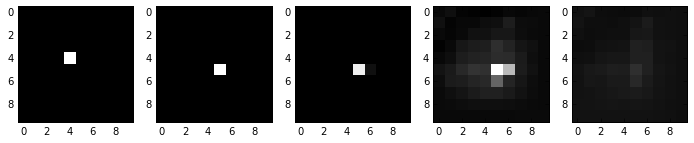

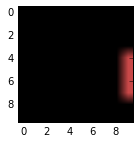

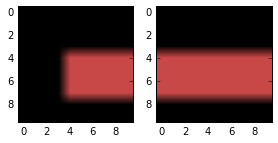

([0.0], [0.0, 1.0])


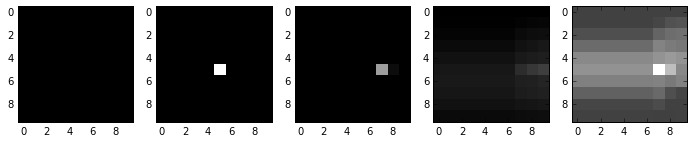

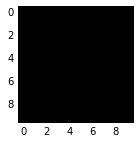

(0.0, 0.0)
1
3
('loss', 3.913167)


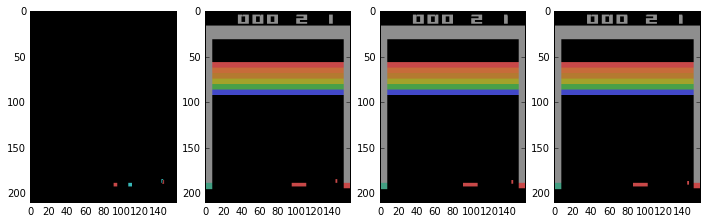

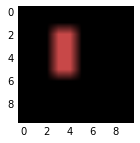

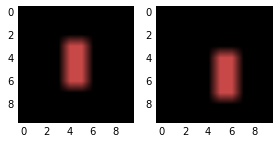

([0.0, 1.0], [0.0, 1.0])


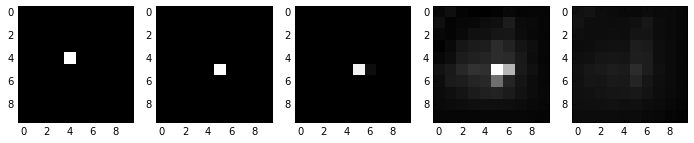

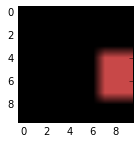

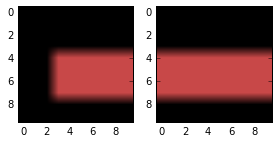

([0.0], [0.0, 1.0])


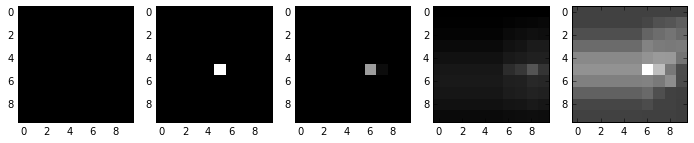

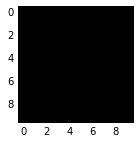

(0.0, 0.0)
3
3
('loss', 3.9080203)


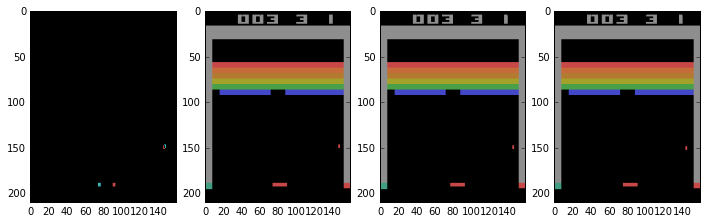

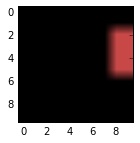

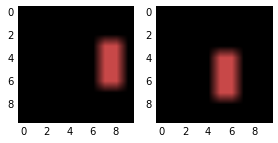

([0.0, 1.0], [0.0, 1.0])


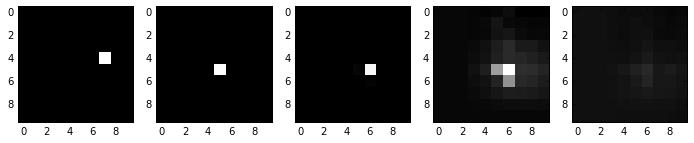

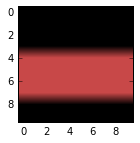

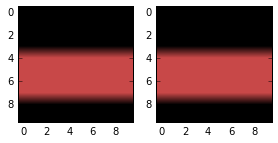

([0.0, 1.0], [0.0, 1.0])


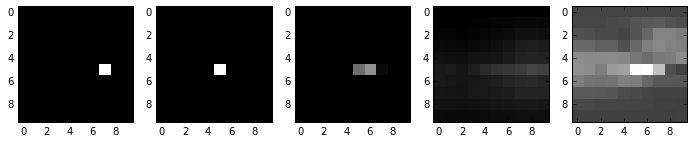

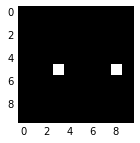

(0.0, 0.80000001)
2
3
('loss', 3.8859627)


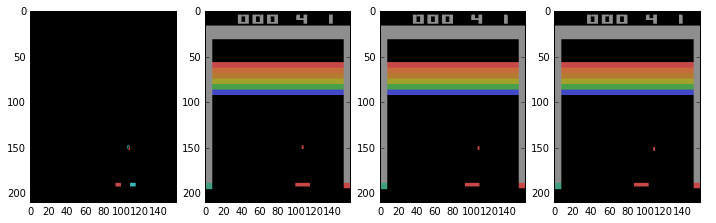

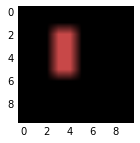

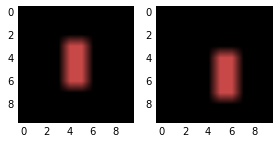

([0.0, 1.0], [0.0, 1.0])


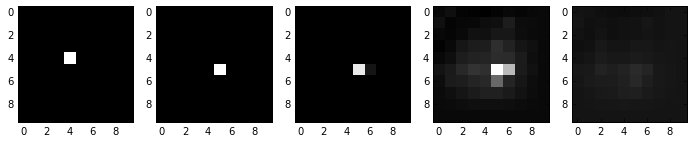

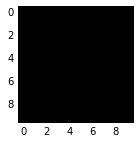

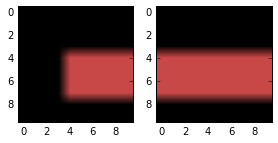

([0.0], [0.0, 1.0])


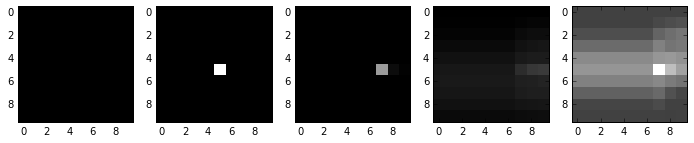

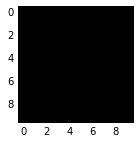

(0.0, 0.0)
1
3
('loss', 3.8847609)


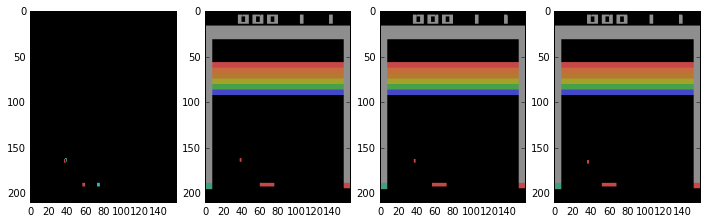

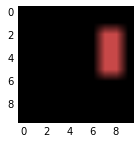

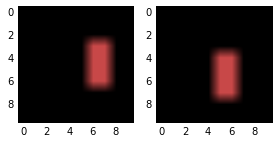

([0.0, 1.0], [0.0, 1.0])


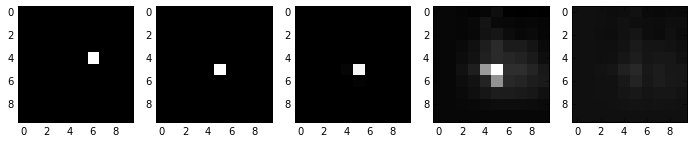

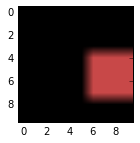

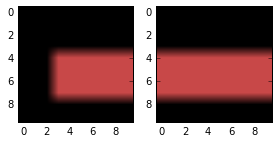

([0.0], [0.0, 1.0])


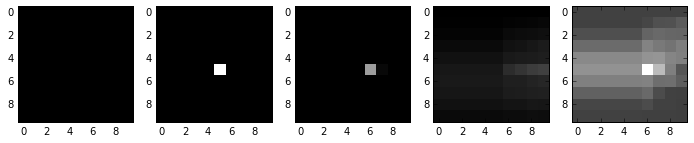

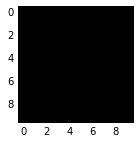

(0.0, 0.0)


In [3334]:
for ind in range(10):
    print(actions[sort_inds[ind]])
    print(old_actions[sort_inds[ind]])
    print('loss', (loss_batch_mean[sort_inds[ind]]-np.median(loss_batch_mean))/
         np.std(loss_batch_mean))
#     print(sort_inds1[ind])
#     if sort_inds1[ind] < len(equiv_ch):
#         print equiv_ch[sort_inds1[ind]]

    plt.figure(figsize=(12,4))
    s0 = np.reshape(displayBatch[sort_inds[ind],0],(210,160,6))
    plt.subplot(141)
    plt.imshow(s0[:,:,3:] - s0[:,:,:3])
    plt.subplot(142)
    plt.imshow(s0[:,:,:3])
    plt.subplot(143)
    plt.imshow(s0[:,:,3:])
    s1 = np.reshape(displayBatch[sort_inds[ind],3],(210,160,6))
    plt.subplot(144)
    plt.imshow(s1[:,:,3:])
    
    for ii in range(2):
        
        target_img = (target_pool[sort_inds[ind],:,:,ii])
        pred_img = pred_pool[sort_inds[ind],:,:,ii]
        previous_img = (previous_pool[sort_inds[ind],:,:,ii])

        predV_img = pred_V[sort_inds[ind],:,:,ii]
        predA_img = pred_A[sort_inds[ind],:,:,ii]

        vis_center = np.unravel_index(np.argmax(target_img), target_img.shape)
        vis_center = (max(vis_center[0],5), max(vis_center[1],5))
        target_img = target_img[vis_center[0]-5:vis_center[0]+5,
                               vis_center[1]-5:vis_center[1]+5]
        pred_img = pred_img[vis_center[0]-5:vis_center[0]+5,
                               vis_center[1]-5:vis_center[1]+5]
        previous_img = previous_img[vis_center[0]-5:vis_center[0]+5,
                               vis_center[1]-5:vis_center[1]+5]
        predV_img = predV_img[vis_center[0]-5:vis_center[0]+5,
           vis_center[1]-5:vis_center[1]+5]
        predA_img = predA_img[vis_center[0]-5:vis_center[0]+5,
                               vis_center[1]-5:vis_center[1]+5]

        #cmap_max = max(np.max(previous_img), np.max(target_img))
        #cmap_min = min(np.min(previous_img), np.min(target_img))
        cmap_max = 0.2; cmap_min = 0
        cmap_max_VA = max(np.max(predV_img), np.max(predA_img)) 
        cmap_min_VA = min(np.min(predV_img), np.min(predA_img))
        
        
        plt.figure(figsize=(12,2*2))
        plt.subplot(151)
        plt.imshow(s0[vis_center[0]-5:vis_center[0]+5, 
                      vis_center[1]-5:vis_center[1]+5,:3])
        plt.figure(figsize=(12,2*2))
        plt.subplot(151)
        plt.imshow(s0[vis_center[0]-5:vis_center[0]+5, 
                      vis_center[1]-5:vis_center[1]+5,3:])
        plt.subplot(152)
        plt.imshow(s1[vis_center[0]-5:vis_center[0]+5, 
                      vis_center[1]-5:vis_center[1]+5,3:]) 
        plt.show()
        
        plt.figure(figsize=(12,2*2))
        plt.subplot(151)
        plt.imshow(previous_img,cmap='gray',interpolation='nearest',vmin=cmap_min,
                  vmax=cmap_max)
        plt.subplot(152)
        plt.imshow(target_img,cmap='gray',interpolation='nearest',vmin=cmap_min,
                  vmax=cmap_max)
        plt.subplot(153)
        plt.imshow(softmax10(pred_img),cmap='gray',interpolation='nearest',vmin=0,
                  vmax=1)
        
        print(list(np.unique(previous_img)), list(np.unique(target_img)))

        plt.subplot(154)
        plt.imshow(predV_img,cmap='gray',interpolation='nearest',vmin=cmap_min_VA,
                  vmax=cmap_max_VA)
        plt.subplot(155)
        plt.imshow(predA_img,cmap='gray',interpolation='nearest',vmin=cmap_min_VA,
                  vmax=cmap_max_VA)
        plt.show()
        
    collision_img = collisions[sort_inds[ind],:,:,0]

    collision_img = collision_img[vis_center[0]-5:vis_center[0]+5,
       vis_center[1]-5:vis_center[1]+5]
    plt.figure(figsize=(12,2*2))
    plt.subplot(151)
    plt.imshow(collision_img,cmap='gray',interpolation='nearest')
    plt.show()
    print(np.min(collision_img),np.max(collision_img))

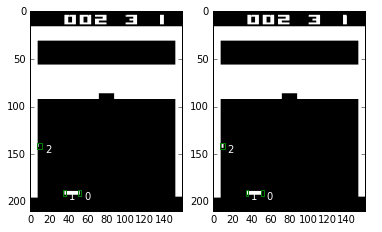

Join (0,), Shift (0, 0) Score 1.0
score_forwards: 510.0, score_backwards: 510.0
Crop: (0, 0), crop_backwards: (0, 0)

Join (0,), Shift (1, 0) Score 1.22474487139
score_forwards: 624.61988441, score_backwards: 624.61988441
Crop: (1, 0), crop_backwards: (-1, 0)

Join (0,), Shift (0, 1) Score 1.73205080757
score_forwards: 883.34591186, score_backwards: 883.34591186
Crop: (0, 1), crop_backwards: (0, -1)

Join (0,), Shift (1, -2) Score 1.73205080757
score_forwards: 883.34591186, score_backwards: 883.34591186
Crop: (1, -2), crop_backwards: (-1, 2)

Join (0,), Shift (0, 3) Score 1.0
score_forwards: 510.0, score_backwards: 510.0
Crop: (0, 3), crop_backwards: (0, -3)

Join (0,), Shift (1, 3) Score 1.22474487139
score_forwards: 624.61988441, score_backwards: 624.61988441
Crop: (1, 3), crop_backwards: (-1, -3)

Join (0,), Shift (0, 4) Score 1.73205080757
score_forwards: 883.34591186, score_backwards: 883.34591186
Crop: (0, 4), crop_backwards: (0, -4)

Join (0,), Shift (1, 4) Score 1.73205080757
s

piaget.py:507: RuntimeWarning: Degrees of freedom <= 0 for slice
  var_crop = ((f1_crop + gt_crop).flatten()**2).var()


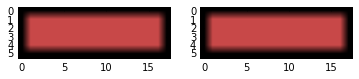

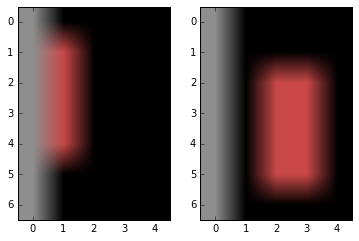

In [3058]:
fp = FramePair(s0[:,:,:3],s0[:,:,3:],actions[sort_inds[ind]],displayBatch[sort_inds[1],1])
mt.process_frame_pair(fp)

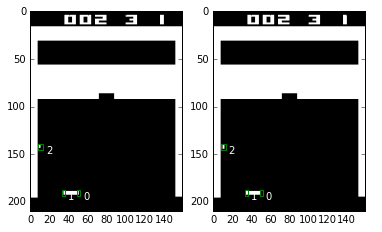

Join (0,), Shift (0, 0) Score 1.0
score_forwards: 510.0, score_backwards: 510.0
Crop: (0, 0), crop_backwards: (0, 0)

Join (0,), Shift (1, 0) Score 1.22474487139
score_forwards: 624.61988441, score_backwards: 624.61988441
Crop: (1, 0), crop_backwards: (-1, 0)

Join (0,), Shift (0, 1) Score 1.73205080757
score_forwards: 883.34591186, score_backwards: 883.34591186
Crop: (0, 1), crop_backwards: (0, -1)

Join (0,), Shift (1, -2) Score 1.73205080757
score_forwards: 883.34591186, score_backwards: 883.34591186
Crop: (1, -2), crop_backwards: (-1, 2)

Join (0,), Shift (0, 3) Score 1.0
score_forwards: 510.0, score_backwards: 510.0
Crop: (0, 3), crop_backwards: (0, -3)

Join (0,), Shift (1, 3) Score 1.22474487139
score_forwards: 624.61988441, score_backwards: 624.61988441
Crop: (1, 3), crop_backwards: (-1, -3)

Join (0,), Shift (0, 4) Score 1.73205080757
score_forwards: 883.34591186, score_backwards: 883.34591186
Crop: (0, 4), crop_backwards: (0, -4)

Join (0,), Shift (1, 4) Score 1.73205080757
s

piaget.py:506: RuntimeWarning: Degrees of freedom <= 0 for slice
  var_crop = ((f1_crop + gt_crop).flatten()**2).var()


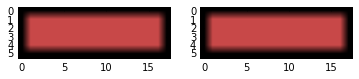

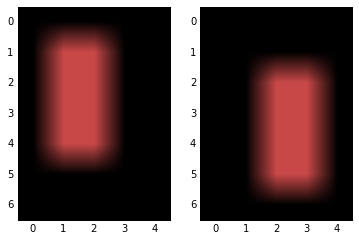

In [3080]:
fp1 = FramePair(s1[:,:,:3],s1[:,:,3:],0,0)
mt.process_frame_pair(fp1)

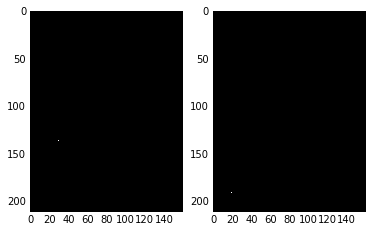

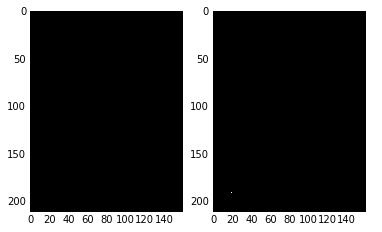

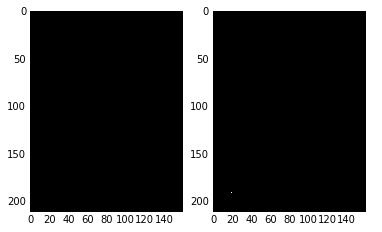

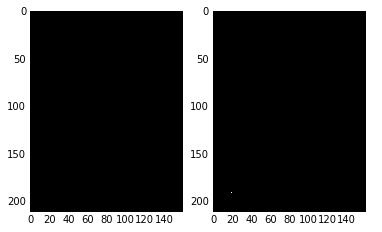

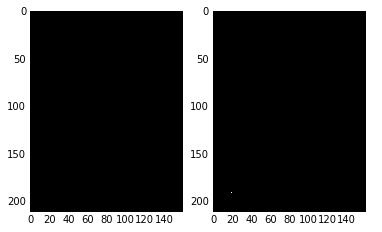

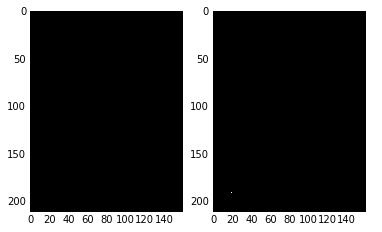

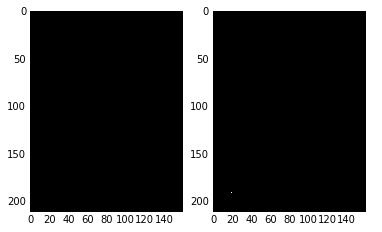

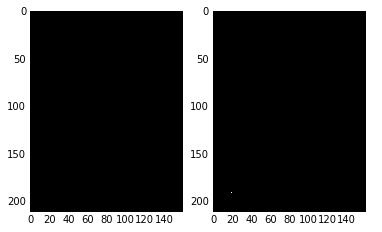

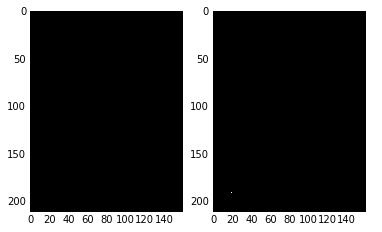

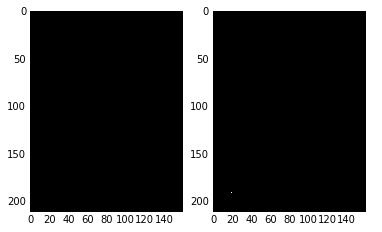

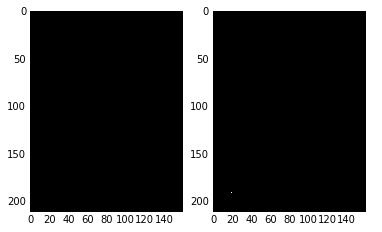

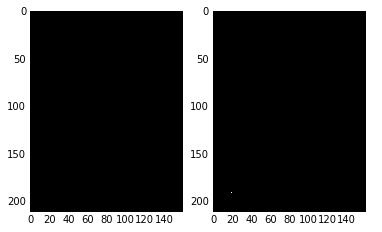

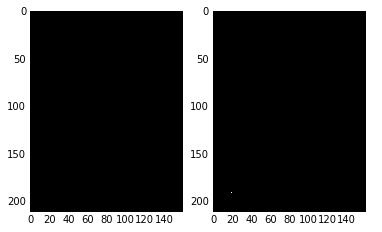

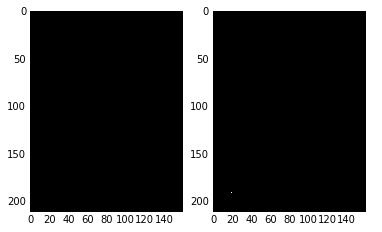

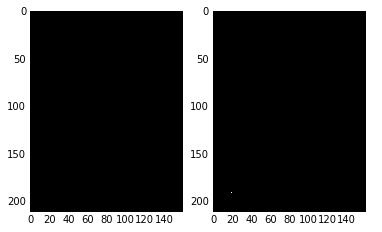

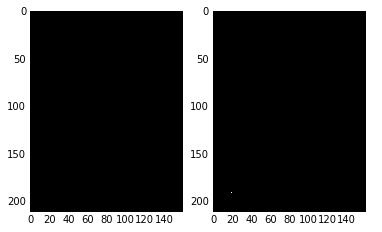

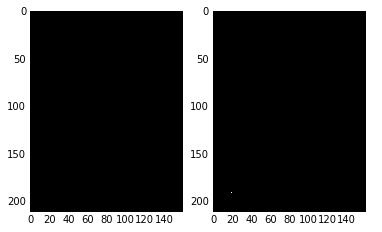

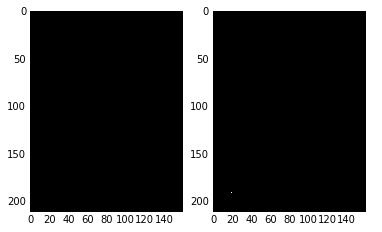

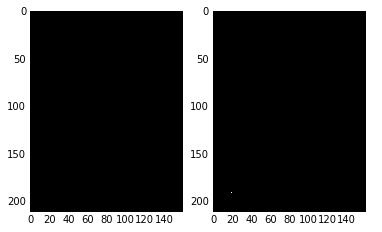

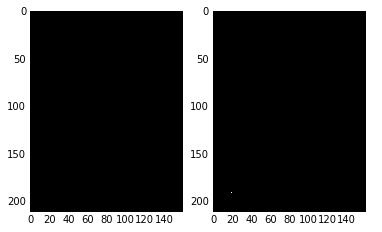

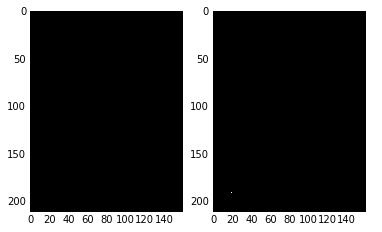

In [1574]:
for cm in cm_list:
    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.imshow(cm[0,:,:,i]>0.1,cmap='gray',interpolation='nearest')
    plt.show()

In [633]:
total_steps

11974

In [2733]:
meansT = []
meansF = []
for _ in range(1000):
    batch = myBuffer.sample(1,attention=False)
    meansF.append(np.mean(batch[:,6]))

    batch2, _ = myBuffer.sample(1, attention=True,rate=100)
    meansT.append(np.mean(batch2[:,6]))
print np.mean(meansF)
print np.mean(meansT)

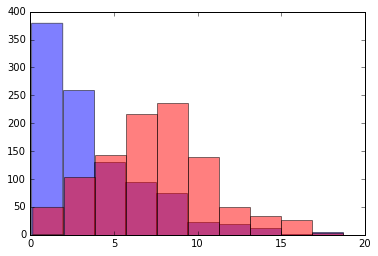

In [2617]:
plt.hist(meansF,alpha=0.5);
plt.hist(meansT,alpha=0.5,color='r');

In [2618]:
meansFp = pd.Series(meansF)
meansTp = pd.Series(meansT)

print meansFp.describe()
print meansTp.describe()

print len(np.unique(meansF))
print len(np.unique(meansT))

count    1000.000000
mean        3.649242
std         3.334161
min         0.080408
25%         0.973740
50%         2.772045
75%         5.474707
max        18.694601
dtype: float64
count    1000.000000
mean        7.488884
std         3.392913
min         0.151871
25%         5.227248
50%         7.547748
75%         9.634660
max        18.694601
dtype: float64
639
440


In [2835]:
testBatch = myBuffer.sample(1000)
frames = testBatch[:,0]
cm = sess.run(mainQN.conv_movers_frame1,\
                 feed_dict={mainQN.scalarInput:np.vstack(frames)})
max_convs = [np.max(cm[:,...,m_id]) for m_id in range(mainQN.n_movers)]
unique_convs = [np.unique(cm[:,...,m_id]) for m_id in range(mainQN.n_movers)]

In [2838]:
unique_convs_tol = []
for m_uc in unique_convs:
    tol_uc = [m_uc[0]]
    for uc in m_uc[1:]:
        if min([abs(t-uc) for t in tol_uc]) > 1e-3:
            tol_uc.append(uc)
    unique_convs_tol.append(tol_uc)

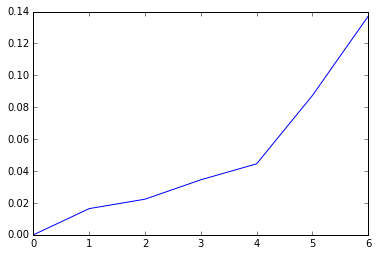

In [2840]:
plt.plot(unique_convs_tol[1])

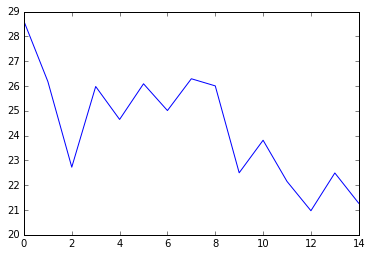

In [635]:
plt.plot(QsqAvgs[1:])

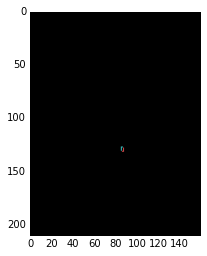

In [636]:
trainBatch = myBuffer.sample(1)

plt.imshow(np.reshape(trainBatch[0][0],(210,160,6))[:,:,3:] -
           np.reshape(trainBatch[0][0],(210,160,6))[:,:,:3])

In [637]:
l1 = sess.run(mainQN.conv_movers,feed_dict={mainQN.scalarInput: [trainBatch[0][0]]})[0]
l2 = sess.run(mainQN.conv_disps,feed_dict={mainQN.scalarInput: [trainBatch[0][0]]})[0]
l_equiv = sess.run(mainQN.cdp_equiv,feed_dict={mainQN.scalarInput: [trainBatch[0][0]]})[0]

AttributeError: protoModelnetwork instance has no attribute 'cdp_equiv'

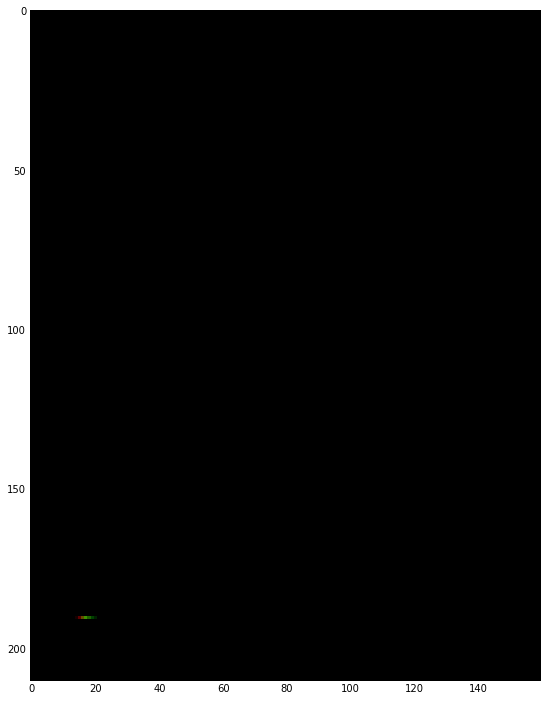

In [958]:
plt.figure(figsize=(12,12))
l1_img = 2*np.stack([l1[:,:,1],l1[:,:,0],np.zeros_like(l1[:,:,0])],2)
plt.imshow(l1_img,interpolation='nearest')

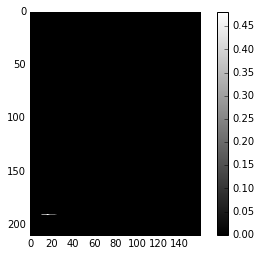

In [960]:
plt.imshow(l_equiv[:,:,0],cmap='gray',interpolation='nearest')
plt.colorbar()

In [955]:
mover_disps[0]

[(-5, 0),
 (9, 0),
 (7, 0),
 (-2, 0),
 (-11, 0),
 (12, 0),
 (-6, 0),
 (6, 0),
 (-12, 0),
 (11, 0),
 (2, 0),
 (-7, 0),
 (-9, 0),
 (5, 0),
 (1, 0),
 (-1, 0)]

In [880]:
#init = tf.global_variables_initializer()
#sess.run(init)
act_frames = sess.run(mainQN.act_frames,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]), mainQN.actions:trainBatch[:,1]})
mainQN.get_Q(act_frames)

AttributeError: protoModelnetwork instance has no attribute 'act_frames'

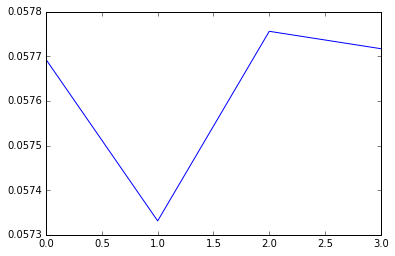

In [158]:
plt.plot(mainQN.Qout[0]);

[2017-06-08 21:30:31,131] Making new env: BreakoutNoFrameskip-v4


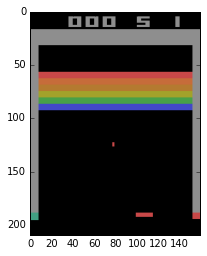

action: 0
0
0


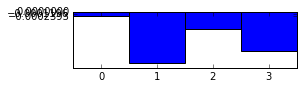

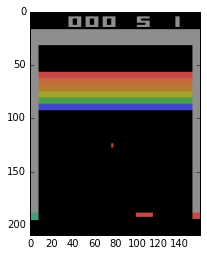

action: 0
0
0


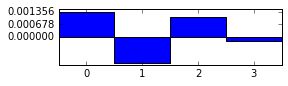

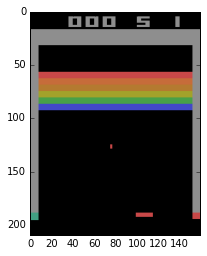

action: 0
0
0


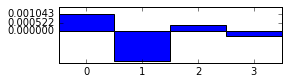

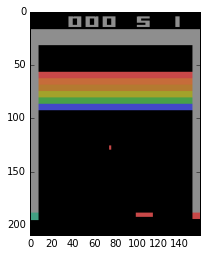

action: 0
0
0


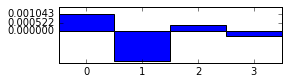

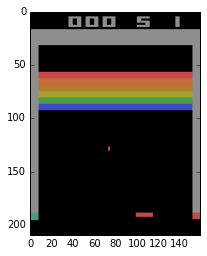

action: 0
0
0


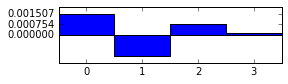

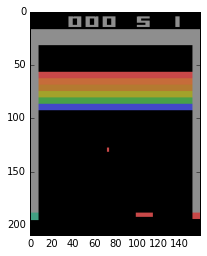

action: 0
0
0


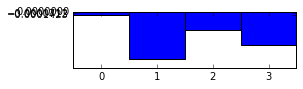

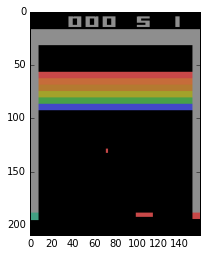

action: 0
0
0


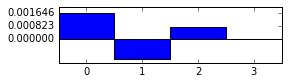

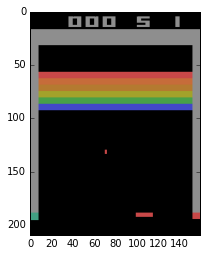

action: 0
0
0


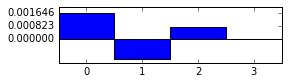

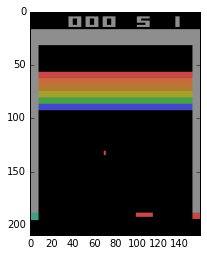

action: 0
0
0


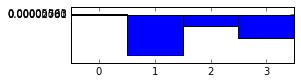

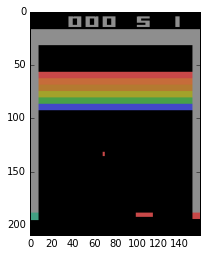

action: 0
0
0


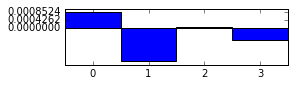

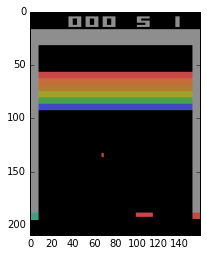

action: 0
0
0


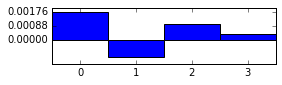

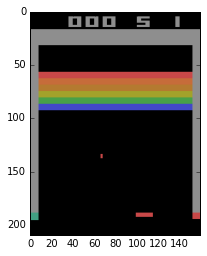

action: 0
0
0


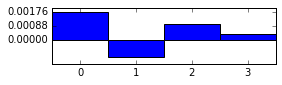

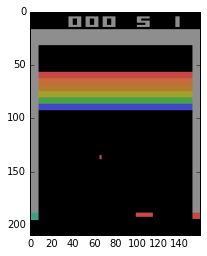

action: 0
0
0


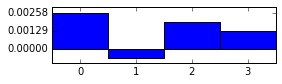

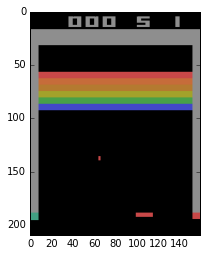

action: 0
0
0


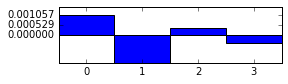

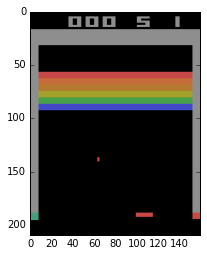

action: 0
0
0


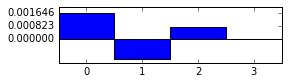

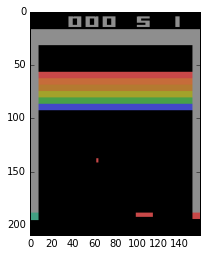

action: 0
0
0


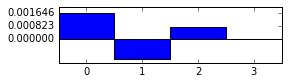

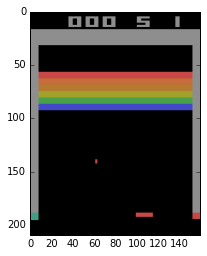

action: 0
0
0


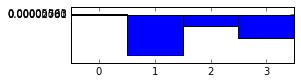

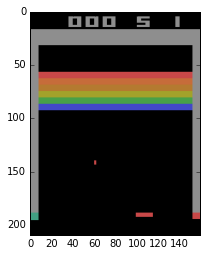

action: 0
0
0


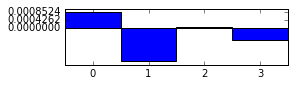

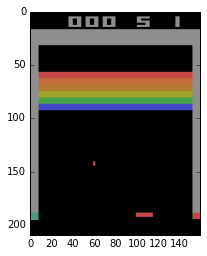

action: 0
0
0


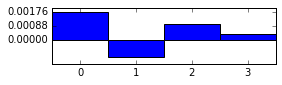

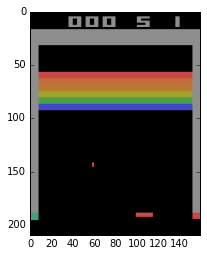

action: 0
0
0


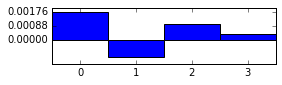

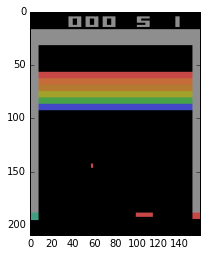

action: 0
0
0


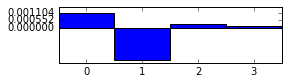

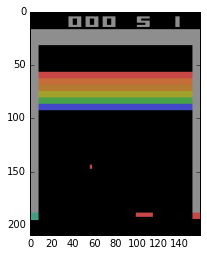

action: 0
0
0


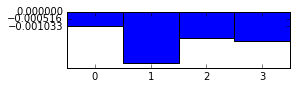

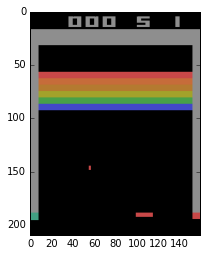

action: 0
0
0


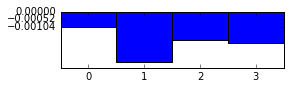

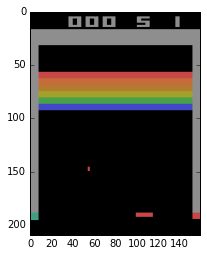

action: 0
0
0


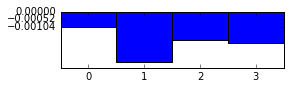

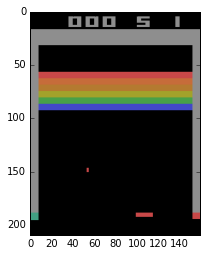

action: 0
0
0


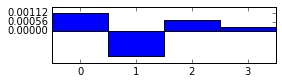

q


In [1546]:
env = gym.make(env_title)
s_list, r, d, info = initial_obs(env, breakout)
s_stack = np.dstack(s_list)
s = processState(s_stack)


d = False
rAll = 0
j = 0

e = 0

while j < max_epLength:
    j+=1

    plt.figure()
    plt.imshow(s_stack[:,:,3:])
    plt.show()

    #Choose an action by greedily (with e chance of random action) from the Q-network
    if np.random.rand(1) < e or total_steps < pre_train_steps:
        a = np.random.randint(0,env.action_space.n)
        print 'random action: ' + str(a)
    else:
#         act_frames = sess.run(mainQN.act_frames,feed_dict={mainQN.scalarInput:[s]})
#         mainQN.get_Q(act_frames)
#         Qout = mainQN.Qout[0]
#         a = mainQN.predict[0]
        a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
        print 'action: ' + str(a)
    if np.array_equal(s_list[0],s_list[1]):
        a = 1
    
    Qout = sess.run(mainQN.Qout,feed_dict={mainQN.scalarInput:[s]})[0]
    Qout_target = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:[s]})[0]
    print(np.sum([sess.run(mainQN.streamV,feed_dict={mainQN.scalarInput:[s]})>0]))
    print(np.sum([sess.run(mainQN.streamA,feed_dict={mainQN.scalarInput:[s]})>0]))
    if j % 1 == 0:#np.var(Qout) > 0:
        plt.figure(figsize=(4,1))
        plt.bar(np.arange(4)-0.5,Qout,width=1)
        plt.xticks(range(4));
        plt.yticks(np.linspace(0,max(Qout),3));
        plt.show()
        if j%1 == 0:
            if raw_input() == 'q':
                break

    
    s_next,r,d,info = env.step(a)
    
    
    s_list.pop(0)
    s_list.append(s_next)

    s_stack = np.dstack(s_list)
    s1 = processState(s_stack)

    rAll += r
    s = s1

    if d == True:
        break

In [910]:

sess.run(mainQN.streamA,\
         feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]), mainQN.actions:displayBatch[:,1]})

array([[ 0.        ,  0.        ,  0.        ,  0.00067102,  0.04917433,
         0.        ,  0.        ,  0.        ,  0.02195593,  0.        ,
         0.0250507 ,  0.00795321,  0.02916563,  0.01147852,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.09755917,
         0.        ,  0.        ,  0.        ,  0.02563024,  0.        ,
         0.        ,  0.03858812,  0.00206866,  0.        ,  0.03718561,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.04855313,  0.03562154,
         0.00140339,  0.        ,  0.        ,  0.01872141,  0.        ,
         0.03155626,  0.        ,  0.        ,  0.05205956,  0.        ,
         0.        ],
       [ 0.01677665,  0.02403419,  0.        ,  0.        ,  0.03196315,
         0.        ,  0.        ,  0.        ,  0.04861519,  0.        ,
         0.        ,  0.03577914,  0.        ,  0.04531803,  0.        ,
         0.02614394],
       [ 0.        ,  0.        ,  0

In [ ]:
testBatch = myBuffer.sample(500)
reward_preds = sess.run(mainQN.pred_reward, feed_dict={mainQN.scalarInput:np.vstack(testBatch[:,0]),
                               mainQN.actions:testBatch[:,1],
                               mainQN.target_reward:testBatch[:,2]})

(array([ 8.33333333,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 0.  ,  0.12,  0.24,  0.36,  0.48,  0.6 ,  0.72,  0.84,  0.96,
         1.08,  1.2 ]),
 <a list of 10 Patch objects>)

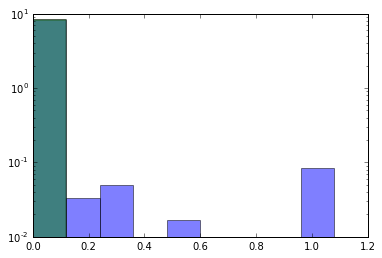

In [304]:
plt.hist(testBatch[:,2],normed=True,log=True,range=(0,1.2),alpha=0.5)
plt.hist(reward_preds,normed=True,log=True,range=(0,1.2),alpha=0.5)

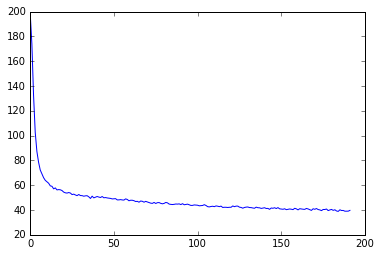

In [299]:
avg_window = 100

sqMat = np.resize(np.array(frame_err_list),[len(frame_err_list)//avg_window,avg_window])
QsqAvgs = np.average(sqMat,1)
plt.plot(QsqAvgs)

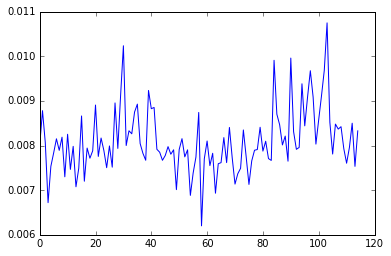

In [272]:
avg_window = 1000

sqMat = np.resize(np.array(reward_err_list),[len(reward_err_list)//avg_window,avg_window])
QsqAvgs = np.average(sqMat,1)
plt.plot(QsqAvgs)

In [2796]:
sort_inds0, sort_inds1 = np.unravel_index(np.argsort(errs,None),errs.shape)
sort_inds0 = sort_inds0[::-1]
sort_inds1 = sort_inds1[::-1]

all_disps = reduce(lambda a,b: list(a)+list(b), mover_disps)

NameError: name 'errs' is not defined

In [22]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [19]:
tf.reset_default_graph()

mainQN = protoQnetwork(env, h_size, mover_prototypes, \
                       mover_disps, md_equiv_classes,
                       1, 'mainQN', True,
                      lr=0.01, eps=1e-4)
targetQN = protoQnetwork(env, h_size, mover_prototypes, \
                       mover_disps, md_equiv_classes,
                         1, 'targetQN', True)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

#targetOps = updateTargetGraph(trainables,tau)
targetOps = updateTargetGraph(trainables,1)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0
n_resets = 0

#statistics on Q
Qpred_list = []
Qtarget_list = []
QrList = []

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

sess = tf.Session()
#with tf.Session() as sess:
sess.run(init)
if load_model == True:
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.model_checkpoint_path)

updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
for i in range(num_episodes):
    episodeBuffer = experience_buffer()
    #Reset environment and get first new observation(s)
    s_list, r, d, info = initial_obs(env, breakout)

    s_stack = np.dstack(s_list)
    s = processState(s_stack)

    d = False
    rAll = 0
    j = 0
    # periodically evaluate
    if i % 5 == 0 and total_steps  > pre_train_steps:
        eval_episode = True
        saved_e = e
        e = 0.1
    else:
        eval_episode = False
    #The Q-Network
    while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
        j+=1
        
        #plt.imshow(env.render('rgb_array'))
        #plt.show()
        
        #Choose an action by greedily (with e chance of random action) from the Q-network
        if np.random.rand(1) < e or total_steps < pre_train_steps:
            a = np.random.randint(0,env.action_space.n)
        else:
            a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
        
        if breakout and np.array_equal(s_list[0],s_list[1]):
            # breakout: requesting next ball
            a = 1
        
        s_next,r,d,info = env.step(a)
        #s_next = cv2.cvtColor(s_next, cv2.COLOR_BGR2GRAY)

        s_list.pop(0)
        s_list.append(s_next)

        s_stack = np.dstack(s_list)
        s1 = processState(s_stack)

        total_steps += 1
        if (r > 0) or d:
            buffer_repeat = 1
        else:
            buffer_repeat = 1
        for dummy in range(buffer_repeat):
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]),reward_prop) #Save the experience to our episode buffer.

        if total_steps > pre_train_steps and not eval_episode:
            if e > endE:
                e -= stepDrop

            if total_steps % (update_freq) == 0:
                trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                #Below we perform the Double-DQN update to the target Q-values
                Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                end_multiplier = -(trainBatch[:,4] - 1)
                doubleQ = Q2[range(batch_size),Q1]
                targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                Qtarget_list.extend(targetQ)
                predQ = sess.run(mainQN.Q, \
                    feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]), mainQN.actions:trainBatch[:,1]})
                Qpred_list.extend(predQ)
                QrList.extend(trainBatch[:,2])
                #Update the network with our target values.
                _ = sess.run(mainQN.updateModel, \
                    feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                if (total_steps//update_freq) % reset_freq == 0:
                    n_resets += 1
                    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
#                 print('value')
#                 print(np.sum([sess.run(mainQN.streamV,\
#                  feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:1,0]), mainQN.actions:trainBatch[:1,1]})>0]))
#                 print(np.max(sess.run(mainQN.streamV,\
#                  feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:1,0]), mainQN.actions:trainBatch[:1,1]})))
#                 print('action')
#                 print(np.sum([sess.run(mainQN.streamA,\
#                  feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:1,0]), mainQN.actions:trainBatch[:1,1]})>0]))
#                 print(np.max(sess.run(mainQN.streamA,\
#                  feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:1,0]), mainQN.actions:trainBatch[:1,1]})))

        rAll += r
        s = s1

        if d == True:
            break
    #print(j)
    if not eval_episode:
        myBuffer.add(episodeBuffer.buffer,False)
        jList.append(j)
        rList.append(rAll)
    else:
        print("Evaluated model")
        print(j, rAll)
        e = saved_e
    #Periodically save the model. 
    if i % 100 == 0 and i > 0:
        saver.save(sess,path+'/model-'+str(i)+'.cptk')
        print("Saved Model")
    print_rate = 5
    if len(rList) % print_rate == 0 and total_steps > pre_train_steps:
        displayBatch = myBuffer.sample(1)
        
        print(total_steps,
              np.mean(jList[-print_rate:]),
              np.mean(rList[-print_rate:]), 
              e)
        all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        
        test_weights=[v for v in all_vars \
         if v.name == 'Conv/weights:0'][0]\
        .eval(session=sess)
        
        q_weights=[v for v in all_vars \
         if v.name == 'Conv_1/weights:0'][0]\
        .eval(session=sess)

#         q_weights=[v for v in all_vars \
#          if v.name == 'Conv/weights:0'][0]\
#         .eval(session=sess)

        for ch_ind in range(1) + range(h_size//2,h_size//2+3):
            i_max=1
            j_max=8
            plt.figure(figsize=(j_max, i_max))
            for ii in range(i_max):
                for jj in range(j_max):
                    cmap_max = max(np.max(q_weights[:,:,:,ch_ind]),
                                  -np.min(q_weights[:,:,:,ch_ind]))
                    plt.subplot(i_max,j_max,jj+(ii*j_max)+1)
                    plt.xticks([])
                    plt.yticks([])
                    plt.imshow(q_weights[:,:,jj+(ii*j_max),ch_ind],cmap='gray',
                    interpolation='nearest',
                    vmin=-cmap_max,vmax=cmap_max)
            plt.show()
            
        for ch_ind in range(8):

            i_max=1
            j_max=8
            plt.figure(figsize=((4./6)*j_max, (4./8)*i_max))
            for ii in range(i_max):
                for jj in range(j_max):
                    cmap_max = max(np.max(test_weights[:,:,:,ch_ind]),
                                  -np.min(test_weights[:,:,:,ch_ind]))
                    plt.subplot(i_max,j_max,jj+(ii*j_max)+1)
                    plt.xticks([])
                    plt.yticks([])
                    plt.imshow(test_weights[:,:,jj+(ii*j_max),ch_ind],cmap='gray',
                    interpolation='nearest',
                              vmin=-cmap_max,vmax=cmap_max)

            plt.show()
        
        displayBatch = myBuffer.sample(100)
        print((1./100)*np.sum([sess.run(mainQN.streamV,\
            feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]), mainQN.actions:displayBatch[:,1]})>0]))
        print((1./100)*np.sum([sess.run(mainQN.streamA,\
            feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]), mainQN.actions:displayBatch[:,1]})>0]))
        print('n_resets', n_resets)
saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

[<tf.Tensor 'gradients/split_1_grad/concat:0' shape=(?, 1, 1, 32) dtype=float32>, None, None]
[<tf.Tensor 'gradients_1/split_1_grad/concat:0' shape=(?, 1, 1, 32) dtype=float32>, None, None]
[<tf.Tensor 'gradients_2/split_3_grad/concat:0' shape=(?, 1, 1, 32) dtype=float32>, None, None]
[<tf.Tensor 'gradients_3/split_3_grad/concat:0' shape=(?, 1, 1, 32) dtype=float32>, None, None]


NameError: name 'startE' is not defined

In [20]:
m_id_shift = 0
for m_id, m_eq in enumerate(md_equiv_classes):
    for eq in m_eq:
        print [all_disps[m_id_shift + d_id] for d_id in eq]
        print ''
    m_id_shift += len(mover_disps[m_id])

[(-5, 0), (-2, 0), (-3, 0), (-4, 0), (-1, 0)]

[(4, 0), (3, 0), (2, 0), (5, 0), (1, 0)]

[(1, 1)]

[(-1, 1)]

[(-1, -1)]

[(1, -1)]



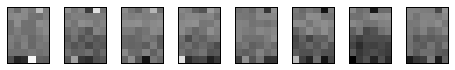

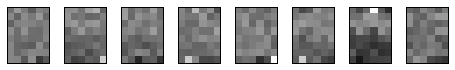

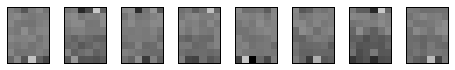

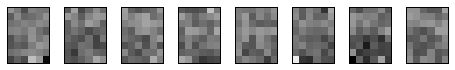

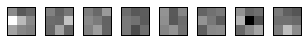

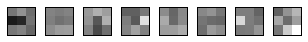

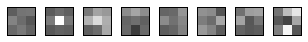

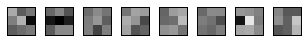

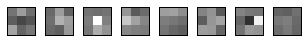

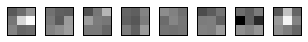

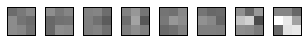

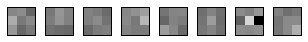

In [1545]:
for ch_ind in range(1) + range(h_size//2,h_size//2+3):
    i_max=1
    j_max=8
    plt.figure(figsize=(j_max, i_max))
    for ii in range(i_max):
        for jj in range(j_max):
            cmap_max = max(np.max(q_weights[:,:,:,ch_ind]),
                          -np.min(q_weights[:,:,:,ch_ind]))
            plt.subplot(i_max,j_max,jj+(ii*j_max)+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(q_weights[:,:,jj+(ii*j_max),ch_ind],cmap='gray',
            interpolation='nearest',
            vmin=-cmap_max,vmax=cmap_max)
    plt.show()

for ch_ind in range(8):

    i_max=1
    j_max=8
    plt.figure(figsize=((4./6)*j_max, (4./8)*i_max))
    for ii in range(i_max):
        for jj in range(j_max):
            cmap_max = max(np.max(test_weights[:,:,:,ch_ind]),
                          -np.min(test_weights[:,:,:,ch_ind]))
            plt.subplot(i_max,j_max,jj+(ii*j_max)+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(test_weights[:,:,jj+(ii*j_max),ch_ind],cmap='gray',
            interpolation='nearest',
                      vmin=-cmap_max,vmax=cmap_max)



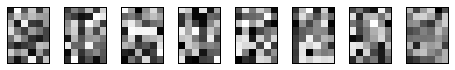

In [1338]:
q_weights=[v for v in all_vars \
 if v.name == 'Conv/weights:0'][0]\
.eval(session=sess)

for ch_ind in range(1):
    i_max=1
    j_max=8
    plt.figure(figsize=(j_max, i_max))
    for ii in range(i_max):
        for jj in range(j_max):
            cmap_max = max(np.max(q_weights[:,:,jj+(ii*j_max),ch_ind]),
                          -np.min(q_weights[:,:,jj+(ii*j_max),ch_ind]))
            plt.subplot(i_max,j_max,jj+(ii*j_max)+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(q_weights[:,:,jj+(ii*j_max),ch_ind],cmap='gray',
            interpolation='nearest',
            vmin=-cmap_max,vmax=cmap_max)
    plt.show()

In [1219]:
equiv_ch = []
m_id_shift = 0
for m_id, m_eq in enumerate(md_equiv_classes):
    for eq in m_eq:
        equiv_ch.append([all_disps[m_id_shift + d_id] for d_id in eq])
    m_id_shift += len(mover_disps[m_id])

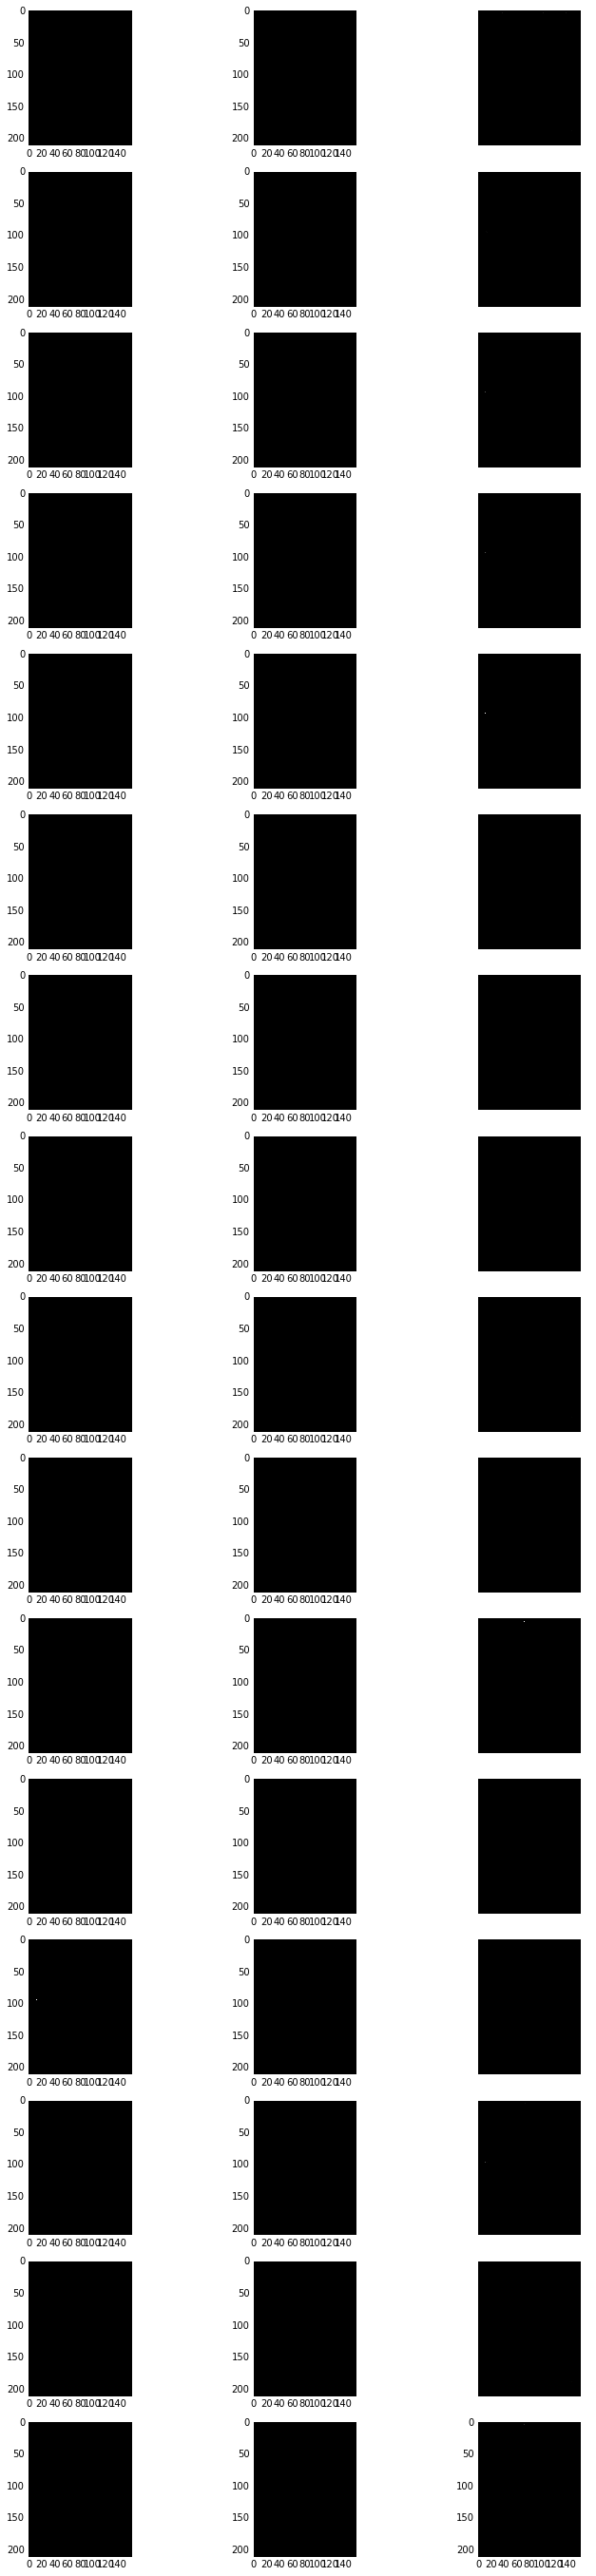

In [1221]:
plt.figure(figsize=(12,48))
i_max = 16
j_max = 3
for ii in range(i_max):
    for jj in range(j_max//3):
        #plt.subplot(i_max,2*j_max,jj+(ii*j_max)+1)
        plt.xticks([])
        plt.yticks([])
        target_img = target_pool[0,:,:,ii]
        pred_img = pred_pool[0,:,:,ii]
        previous_img = previous_pool[0,:,:,ii]
        pred_img = (pred_img + np.abs(pred_img)) / 2
        diff = target_img - pred_img
        tgp = np.abs(target_img)*(target_img>0)*(pred_img<=0)#(np.abs(diff) + diff)/2
        tlp = np.abs(pred_img)*(target_img<=0)*(pred_img>0)#(np.abs(diff) - diff)/2
        agreement = ((1-np.abs(target_img-pred_img))*(target_img>0)*(pred_img>0))#(target_img+pred_img)/2.
#         vis_img = (1.*np.stack([tlp, tgp, agreement],2))
#         plt.imshow(vis_img,interpolation='nearest')
        plt.subplot(i_max,j_max,3*jj+(ii*j_max)+1)
        vis_img = np.stack(
             [np.zeros_like(previous_img), np.zeros_like(previous_img), previous_img],2)
        plt.imshow(previous_img,cmap='gray',interpolation='nearest')
        plt.subplot(i_max,j_max,3*jj+(ii*j_max)+2)
        vis_img = np.stack(
             [np.zeros_like(target_img), target_img, np.zeros_like(target_img)],2)
        plt.imshow(target_img,cmap='gray',interpolation='nearest')
        plt.subplot(i_max,j_max,3*jj+(ii*j_max)+3)
        vis_img = np.stack(
             [pred_img, np.zeros_like(pred_img), np.zeros_like(pred_img)],2)
        plt.imshow(pred_img,cmap='gray',interpolation='nearest')
plt.show()


In [445]:
reward_frames = [f[3] for f in myBuffer.buffer if f[2]>0.5]
reward_pools = sess.run(mainQN.conv_dm_pool,feed_dict={mainQN.scalarInput:reward_frames})

mean_reward_pool = np.mean(reward_pools,axis=0)

non_reward_frames = [f[3] for f in myBuffer.buffer if f[2]<0.6][115:125]
non_reward_pools = sess.run(mainQN.conv_dm_pool,feed_dict={mainQN.scalarInput:non_reward_frames})

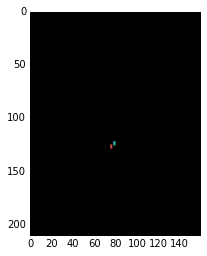

(-5, 0)


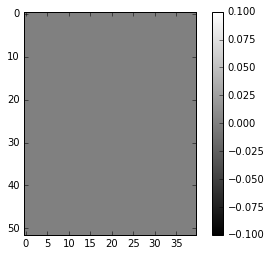

(9, 0)


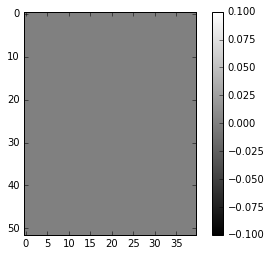

(0, 0)


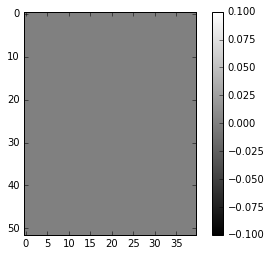

(7, 0)


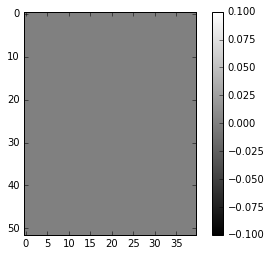

(-2, 0)


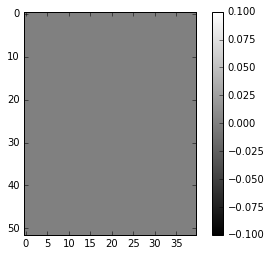

(-11, 0)


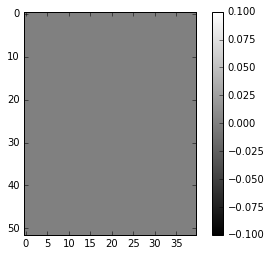

(12, 0)


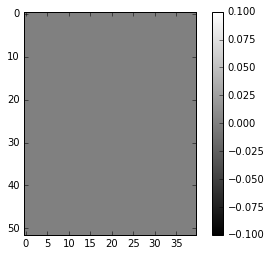

(-6, 0)


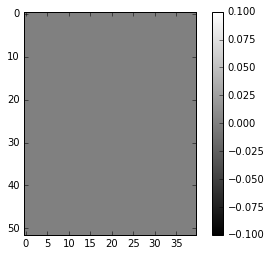

(1, 0)


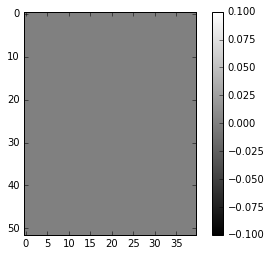

(-3, 3)


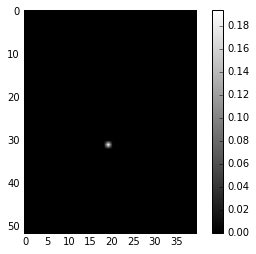

(-4, 4)


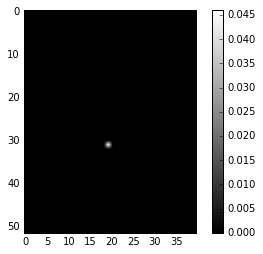

(2, 2)


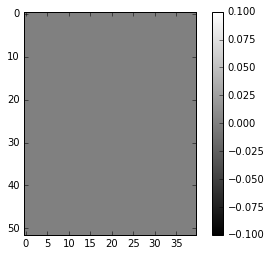

In [453]:
f = non_reward_frames[1]
plt.imshow(np.reshape(f,(210,160,6))[:,:,3:]-np.reshape(f,(210,160,6))[:,:,:3])
plt.show()
for ch_ind in range(12):
    print all_disps[ch_ind]
    plt.imshow(non_reward_pools[1][:,:,ch_ind],cmap='gray')
    plt.colorbar()
    plt.show()

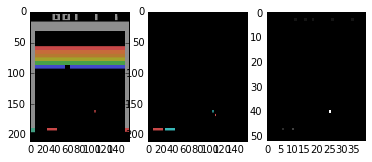

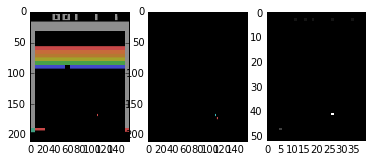

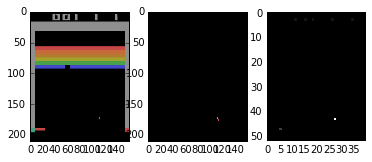

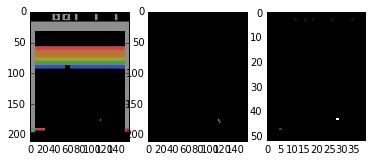

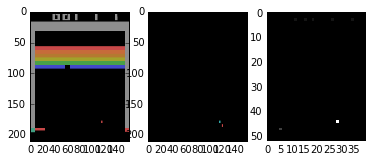

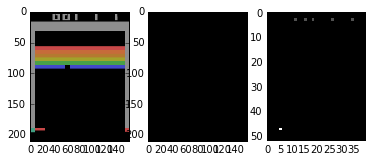

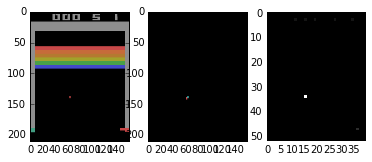

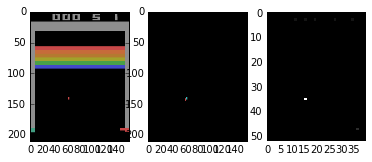

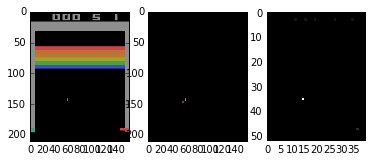

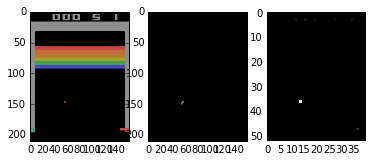

In [433]:
for f, pool in zip(non_reward_frames, non_reward_pools):
    plt.subplot(131)
    plt.imshow(np.reshape(f,(210,160,6))[:,:,:3])
    plt.subplot(132)
    plt.imshow(np.reshape(f,(210,160,6))[:,:,3:]-np.reshape(f,(210,160,6))[:,:,:3])
    plt.subplot(133)
    plt.imshow(pool[:,:,-2],cmap='gray', interpolation='nearest')
    plt.show()

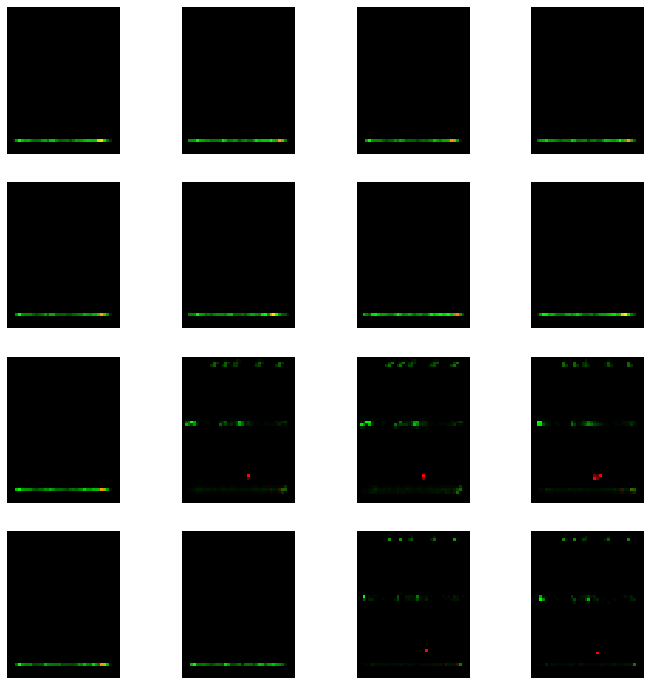

In [1158]:
plt.figure(figsize=(12,12))
i_max = 4
j_max = 4
for ii in range(i_max):
    for jj in range(j_max):
        plt.subplot(i_max,j_max,jj+(ii*j_max)+1)
        plt.xticks([])
        plt.yticks([])
        ch0 = non_reward_pools[0][:,:,jj+(ii*j_max)]
        ch1 = mean_reward_pool[:,:,jj+(ii*j_max)]
        
        if np.max(ch0) > 0:
            ch0 = ch0 / np.max(ch0)
        if np.max(ch1) > 0:
            ch1 = ch1 / np.max(ch1)
            
        vis_img = np.stack([ch0, ch1,
                  np.zeros_like(ch0)],2)

        #vis_img = (vis_img > 0).astype('float32')
        plt.imshow(vis_img, interpolation='nearest')
plt.show()

In [1152]:
x_coords = np.array([[j for j in range(40)] for i in range(52)])
y_coords = np.array([[i for j in range(40)] for i in range(52)])

x_flat = np.reshape(x_coords,(52*40,))
y_flat = np.reshape(y_coords,(52*40,))
coords_flat = [[x,y] for x, y in zip(x_flat, y_flat)]

dists = distance_matrix(coords_flat,coords_flat)
dists = np.asarray(dists, order='C')

In [44]:
test=np.zeros((5,5,5,5))
test[:,...,0].shape

(5, 5, 5)

In [1211]:
ch_dists = np.zeros((10,16))
start_index = 0

for f_ind in range(10):
    for ii in range(start_index,16):
        demand = np.asarray(np.reshape(mean_reward_pool[:,:,ii], (52*40,)).astype('float64'), order='C')

        supply = np.asarray(np.reshape(non_reward_pools[f_ind][:,:,ii], (52*40,)).astype('float64'), order='C')
        
        if min(np.sum(demand), np.sum(supply)) > 0:
            demand = demand / np.sum(demand)
            supply = supply / np.sum(supply)

            ch_dists[f_ind, ii-start_index] = pyemd.emd(supply, demand, dists)

In [1212]:
for jj in range(ch_dists.shape[1]):
    for ii in range(ch_dists.shape[0]):
        if ch_dists[ii,jj] == 0:
            ch_dists[ii,jj] = np.mean(ch_dists[:,jj][ch_dists[:,jj] > 0])

In [1213]:
ch_dists

array([[ 12.87229567,  12.78212569,  12.93780308,  12.85030202,
         12.84565956,  12.88327515,  12.56757058,  13.02539156,
         12.96242313,  14.85618359,  15.26092944,  15.88967421,
         13.07956944,  13.09409468,  15.59735507,  15.10561764],
       [ 12.87229567,  12.78212569,  12.93780308,  12.85030202,
         12.84565956,  12.88327515,  12.56757058,  13.02539156,
         12.96242313,  14.18070138,  13.81898886,  16.42902207,
         13.07956944,  13.09409468,  14.89366705,  14.75136397],
       [ 15.85949685,  14.3335012 ,  15.28453767,  14.51945408,
         15.40867098,  16.41293647,  13.91338464,  16.04920297,
         15.24111011,  14.00055791,  13.55668937,  14.39545793,
         13.07956944,  15.59017417,  14.60190981,  15.16689896],
       [ 15.01483974,  14.95707408,  15.07734739,  15.106797  ,
         14.95399149,  14.88170679,  15.02429008,  15.20439452,
         15.09787999,  15.15238115,  14.14919074,  15.50813298,
         15.05122402,  15.20973847,  

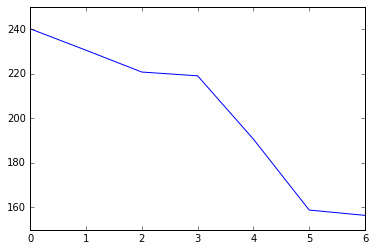

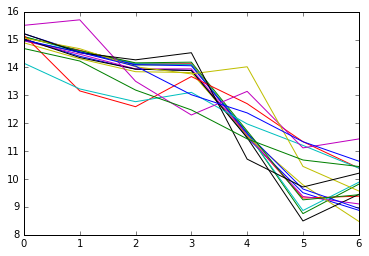

In [1214]:
plt.plot(np.sum(ch_dists[3:],axis=1))
plt.show()
plt.plot(ch_dists[3:])

In [1507]:
all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

test_weights=[v for v in all_vars \
 if v.name == 'Conv/weights:0'][0]\
.eval(session=sess)

np.std(test_weights[:,:,:,:16])

0.34266943

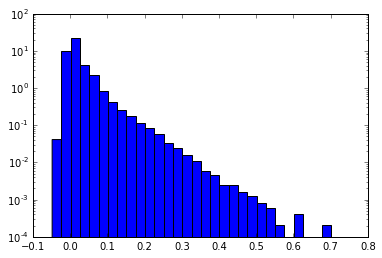

In [1526]:
plt.hist(Qpred_list,log=True,normed=True,bins=30);

In [1527]:
avg_reward = np.mean([e[2] for e in myBuffer.buffer])
avg_stable_q = avg_reward / (1-y)
print avg_stable_q

0.0150826235961


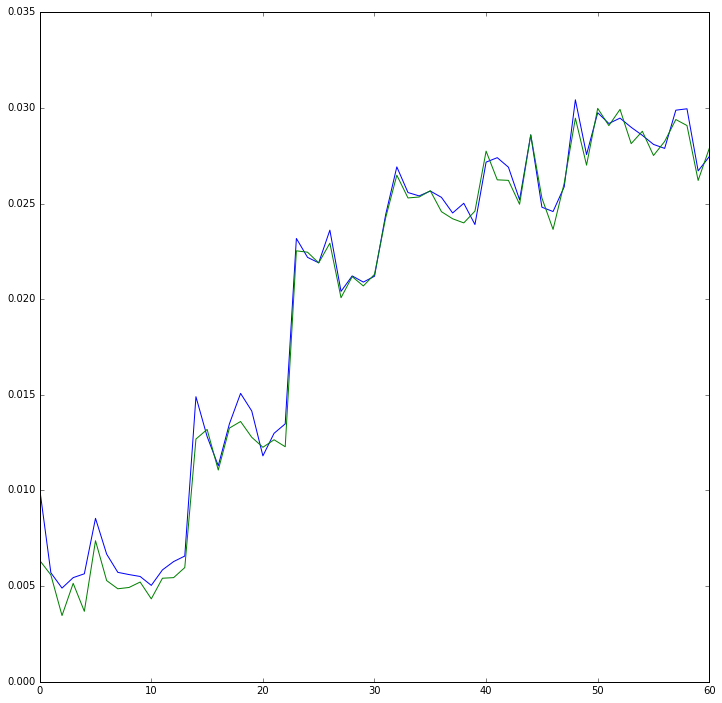

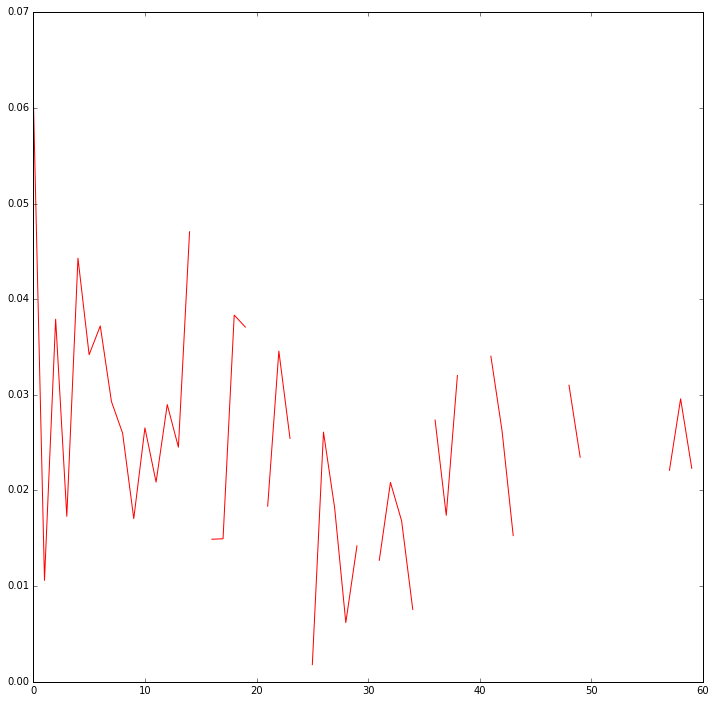

In [1529]:
sync_length = min(len(Qpred_list), len(Qtarget_list))
Qpred_list = Qpred_list[:sync_length]
Qtarget_list = Qtarget_list[:sync_length]

avg_window = 32*100

plt.figure(figsize=(12,12))
QtMat = np.resize(np.array(Qtarget_list),[len(Qtarget_list)//avg_window,avg_window])
QtAvgs = np.average(QtMat,1)
plt.plot(QtAvgs)

QpMat = np.resize(np.array(Qpred_list),[len(Qpred_list)//avg_window,avg_window])
QpAvgs = np.average(QpMat,1)
plt.plot(QpAvgs)

plt.figure(figsize=(12,12))
losses = np.array(Qtarget_list)-np.array(Qpred_list)
lossMat = np.resize(losses,[len(losses)//avg_window,avg_window])
lossAvgs = np.sqrt(np.average(lossMat,1))
plt.plot(lossAvgs,'r')

In [1530]:
len(Qtarget_list)

196704

[[ 1.          0.52966405]
 [ 0.52966405  1.        ]]


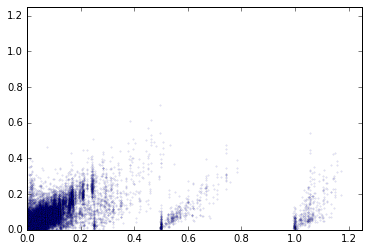

In [1531]:
plt.plot(Qtarget_list,Qpred_list,'o',markersize=1.5,alpha=0.1)
plt.axis([0,1.25,0,1.25])
print np.corrcoef(Qtarget_list,Qpred_list)

In [1532]:
cols = []
Qpred_list = np.array(Qpred_list)
rOptions = np.unique(QrList)
for r in rOptions:
    cols.append(Qpred_list[QrList==r])

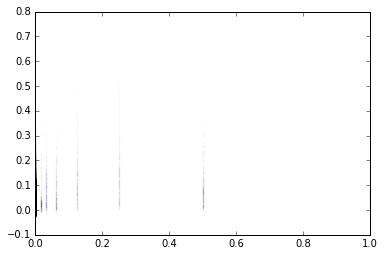

In [1533]:
plt.plot(QrList,Qpred_list,'o',markersize=1,alpha=0.01)

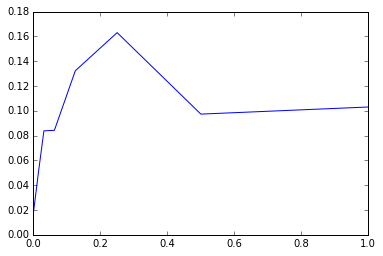

In [1539]:
plt.plot(rOptions, [np.mean(col) for col in cols])

In [845]:
buffer_all = np.array(myBuffer.buffer)
(buffer_all[:,2]>0).mean()

0.0058999999999999999

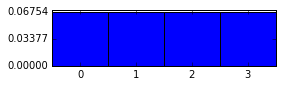

In [112]:
plt.figure(figsize=(4,1))
plt.bar(np.arange(4)-0.5,Qout,width=1)
plt.xticks(range(4));
plt.yticks(np.linspace(0,max(Qout),3));

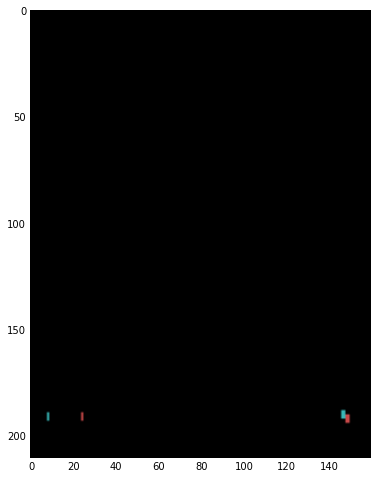

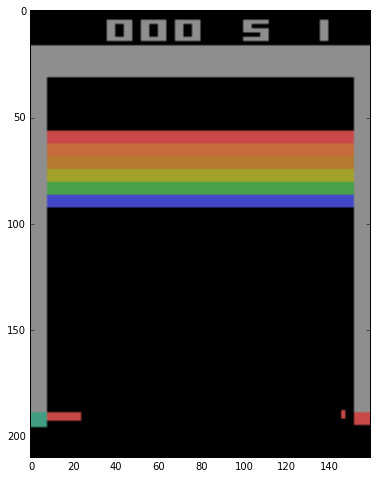

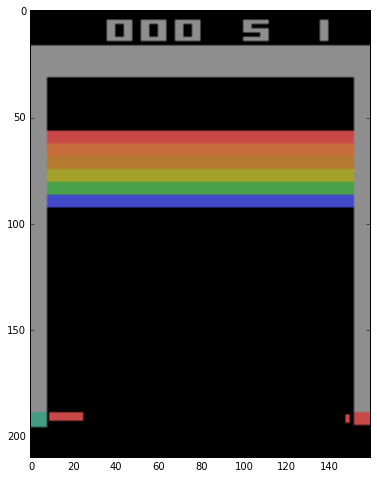

In [901]:
plt.figure(figsize=(12,8))
plt.imshow(s_stack[:,:,3:]-s_stack[:,:,:3])
plt.figure(figsize=(12,8))
plt.imshow(s_stack[:,:,:3])
plt.figure(figsize=(12,8))

plt.imshow(s_stack[:,:,3:])

In [902]:
sess.run(mainQN.conv2,feed_dict={mainQN.scalarInput:[s]})

array([[[[-0.00875617, -0.01546426, -0.00618444, -0.00656676, -0.00902274,
          -0.02128692, -0.01523175,  0.11306629]]]], dtype=float32)

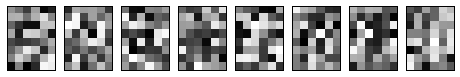

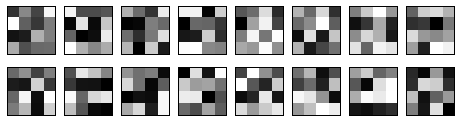

In [147]:
all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

#test_kernel=[v for v in all_vars \
# if v.name == 'mainQN/piaget/mover_disps/mover0/disp2/kernel:0'][0]\
#.eval(session=sess)

test_weights=[v for v in all_vars \
 if v.name == 'Conv/weights:0'][0]\
.eval(session=sess)

q_weights=[v for v in all_vars \
 if v.name == 'Conv_1/weights:0'][0]\
.eval(session=sess)

i_max=1
j_max=8
plt.figure(figsize=(8,2))
for i in range(i_max):
    for j in range(j_max):
        cmap_max = max(np.max(q_weights[:,:,i,j]),
                      -np.min(q_weights[:,:,i,j]))
        plt.subplot(i_max,j_max,j+(i*j_max)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(q_weights[:,:,i,j],cmap='gray',
        interpolation='nearest',
        vmin=-cmap_max,vmax=cmap_max)
plt.show()

i_max=2
j_max=8
plt.figure(figsize=(8,2))
for i in range(i_max):
    for j in range(j_max):
        cmap_max = max(np.max(test_weights[:,:,j+(i*j_max),0]),
                      -np.min(test_weights[:,:,j+(i*j_max),0]))
        plt.subplot(i_max,j_max,j+(i*j_max)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(test_weights[:,:,j+(i*j_max),0],cmap='gray',
        interpolation='nearest',
                  vmin=-cmap_max,vmax=cmap_max)
plt.show()

In [144]:
plt.axis?

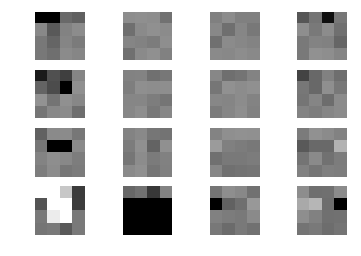

In [904]:
test_weights.shape
i_max=4
j_max=4
for i in range(i_max):
    for j in range(j_max):
        plt.subplot(i_max,j_max,j+(i*j_max)+1)
        plt.axis('off')
        plt.imshow(test_weights[:,:,j+(i*j_max),0],cmap='gray',
        interpolation='nearest',
                  vmin=-1,vmax=1)

In [905]:
#c0=sess.run(mainQN.conv_movers,feed_dict={mainQN.scalarInput:[s]})
c1=sess.run(mainQN.conv_dm_pool,feed_dict={mainQN.scalarInput:[s]})
c2=sess.run(mainQN.conv1_pool,feed_dict={mainQN.scalarInput:[s]})
c3=sess.run(mainQN.conv2,feed_dict={mainQN.scalarInput:[s]})

In [906]:
print c1.shape
print c2.shape
print c3.shape

(1, 52, 40, 16)
(1, 8, 6, 4)
(1, 1, 1, 8)


In [907]:
[[mover_disps[0][j],np.max(c1[0,:,:,j])] for j in range(10)]

IndexError: list index out of range

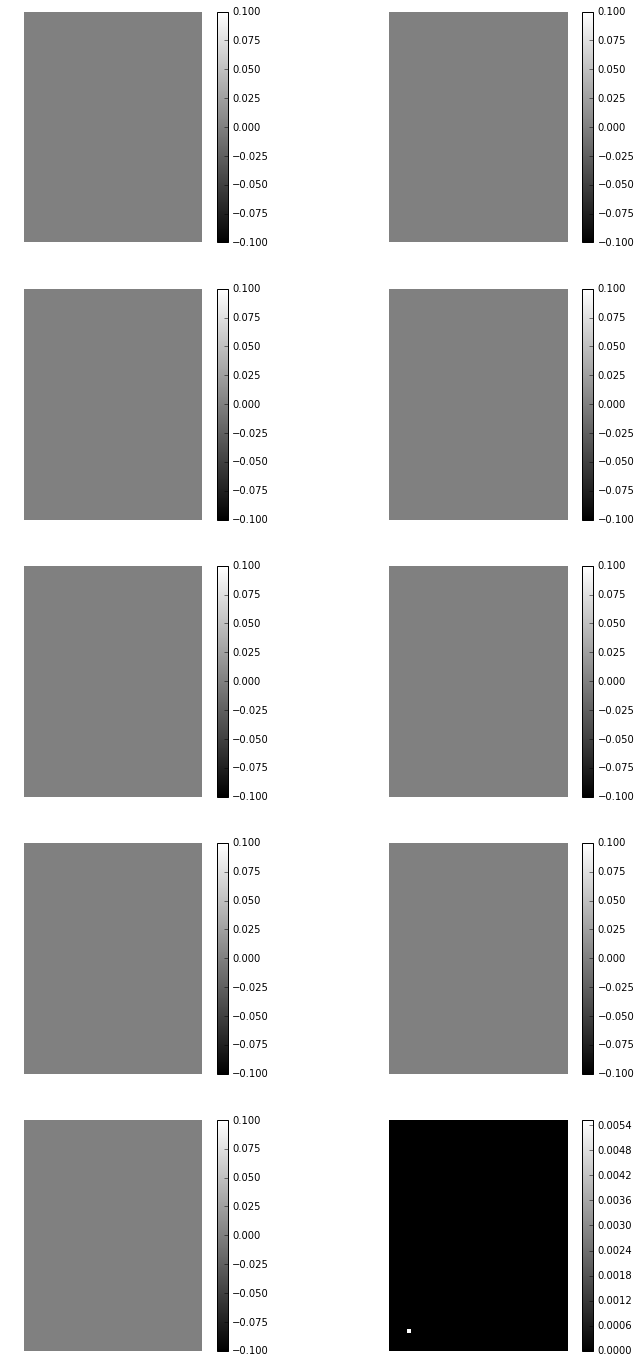

In [908]:
plt.figure(figsize=(12,24))
i_max=5
j_max=2
for i in range(i_max):
    for j in range(j_max):
        plt.subplot(i_max,j_max,j+(i*j_max)+1)
        plt.axis('off')
        im = c1[0,:,:,j+(i*j_max)]
        plt.imshow(im,cmap='gray',
        interpolation='nearest')
        plt.colorbar()

In [ ]:
[(i, np.max(c3[0,:,:,i])) for i in range(16)]

In [602]:
test = reduce(lambda a,b: a+b, mover_disps)
test[8]

(-2, 2)

In [603]:
for index in range(16):
    #print(test[index])
    plt.figure(figsize=(12,8))
    plt.imshow(c1[0,:,:,3]-c0[0,:,:,2],interpolation='nearest')
    plt.colorbar()
    plt.figure(figsize=(6,4))
    plt.imshow(c3[0,:,:,index],interpolation='nearest')
    plt.colorbar()

NameError: name 'c0' is not defined

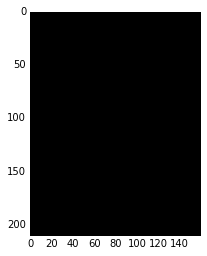

In [971]:
plt.imshow(s_stack[:,:,3:]-s_stack[:,:,:3])

### Checking network learning

Mean reward over time

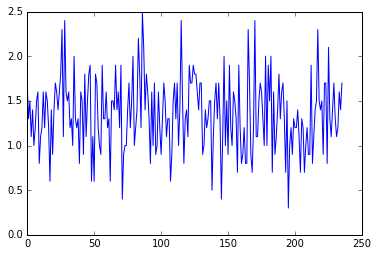

In [205]:
rMat = np.resize(np.array(rList),[len(rList)//10,10])
rMean = np.average(rMat,1)
plt.plot(rMean)